## Цель работы

Есть небольшой тестовый датасет с данными о машинах, их признаках и стоимости. Необходимо проанализировать датасет, а также собрать данные для обучения, провести разведывательный анализ и построить модель для предсказания стоимости на тестовом датасете. Качество модели предлагается измерять с помощью метрики MAPE. Данная задача является задачей регрессии.

## Импорт библиотек

Импортируем библиотеки, которые понадобятся в ходе анализа данных. Остальные будут добавляться по мере надобности, в зависимости от результатов анализа.

In [670]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

import warnings
import json
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

%matplotlib inline

## Вспомогательные функции

In [671]:
# функция для нахождения значимых различий для признака по тесту Стьюдента
def get_stat_dif(column):
    cols = df_train.loc[:, column].value_counts().index[:10]
    has_importance = False
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_train.loc[df_train.loc[:, column] == comb[0], 'price'],
                     df_train.loc[df_train.loc[:, column] == comb[1], 'price']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            has_importance = True
            print('Найдены статистически значимые различия для колонки', column)
            break
    if not has_importance:
        print('Статистически значимых различий для колонки {} не найдено'.format(column))


# функция отрисовки боксплота для конкретной колонки
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='price',
                data=df_train.loc[df_train.loc[:, column].isin(
                    df_train.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


# функция для проверки на выбросы
def check_for_outliers(column, bins_number):
    median = df_train[column].median()
    IQR = df_train[column].quantile(0.75) - df_train[column].quantile(0.25)
    perc25 = df_train[column].quantile(0.25)
    perc75 = df_train[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    df_train[column].loc[df_train[column].between(
        perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=bins_number, label='IQR')
    plt.legend()

## Изучение датасетов, вычищение данных и приведение их к единому формату

Датасет для обучения был взят с kaggle по ссылке https://www.kaggle.com/macsunmood/autoru-parsed-0603-1304

In [672]:
df_train = pd.read_csv('train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109080 entries, 0 to 109079
Data columns (total 22 columns):
Unnamed: 0              109080 non-null int64
bodyType                109079 non-null object
brand                   109080 non-null object
color                   109080 non-null object
fuelType                109080 non-null object
modelDate               109079 non-null float64
name                    109079 non-null object
numberOfDoors           109079 non-null float64
productionDate          109080 non-null int64
vehicleConfiguration    109079 non-null object
engineDisplacement      109079 non-null object
enginePower             109079 non-null float64
description             105829 non-null object
mileage                 109080 non-null int64
Комплектация            109080 non-null object
Привод                  109079 non-null object
Руль                    109080 non-null object
Владельцы               109073 non-null float64
ПТС                     109078 non-null ob

Посмотрим, сколько пропусков в столбцах.

In [673]:
df_train.isna().sum().sort_values(ascending=False)

Владение                69191
description              3251
Владельцы                   7
ПТС                         2
engineDisplacement          1
name                        1
bodyType                    1
Привод                      1
enginePower                 1
vehicleConfiguration        1
modelDate                   1
numberOfDoors               1
brand                       0
color                       0
fuelType                    0
Price                       0
productionDate              0
mileage                     0
Комплектация                0
Руль                        0
Таможня                     0
Unnamed: 0                  0
dtype: int64

Больше всего у нас пропусков в признаках "Владение", "description". В остальных столбцах пропусков совсем немного или вовсе нет.

In [674]:
df_test = pd.read_csv('test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 23 columns):
bodyType                3837 non-null object
brand                   3837 non-null object
color                   3837 non-null object
fuelType                3837 non-null object
modelDate               3837 non-null float64
name                    3837 non-null object
numberOfDoors           3837 non-null float64
productionDate          3837 non-null float64
vehicleConfiguration    3837 non-null object
vehicleTransmission     3837 non-null object
engineDisplacement      3837 non-null object
enginePower             3837 non-null object
description             3837 non-null object
mileage                 3837 non-null float64
Комплектация            3837 non-null object
Привод                  3837 non-null object
Руль                    3837 non-null object
Состояние               3837 non-null object
Владельцы               3837 non-null object
ПТС                     3837 non-n

In [675]:
df_test.isna().sum().sort_values(ascending=False)

Владение                2084
id                         0
engineDisplacement         0
brand                      0
color                      0
fuelType                   0
modelDate                  0
name                       0
numberOfDoors              0
productionDate             0
vehicleConfiguration       0
vehicleTransmission        0
enginePower                0
description                0
mileage                    0
Комплектация               0
Привод                     0
Руль                       0
Состояние                  0
Владельцы                  0
ПТС                        0
Таможня                    0
bodyType                   0
dtype: int64

В тестовом датасете у нас всего 1 столбец с пропусками. Пропусков больше половины, и скорее всего, этот столбец не будет нам нужен.

Далее приведем названия колонок в обоих датасетах к единообразному виду.

In [676]:
df_train.columns = ['id', 'body_type', 'brand', 'color', 'fuel_type', 'model_date', 'name',
                    'doors_number', 'production_date', 'vehicle_configuration',
                    'engine_displacement', 'engine_power', 'description', 'mileage', 'complectation',
                    'drive_type', 'steering_wheel', 'owners', 'technical_passport',
                    'customs', 'ownership', 'price']

df_test.columns = ['body_type', 'brand', 'color', 'fuel_type', 'model_date', 'name',
                   'doors_number', 'production_date', 'vehicle_configuration', 'vehicle_transmission',
                   'engine_displacement', 'engine_power', 'description', 'mileage', 'complectation',
                   'drive_type', 'steering_wheel', 'condition', 'owners', 'technical_passport',
                   'customs', 'ownership', 'id']

Сразу удалим столбцы ownership (как имеющий множество пропусков) и description (не несет в себе особой смысловой нагрузки).

In [677]:
df_train = df_train.drop(columns=['ownership', 'description'], axis=1)
df_test = df_test.drop(columns=['ownership', 'description'], axis=1)

Сразу отметим, что в тренировочном датасете есть целевая переменная **price**, которой нет в тестовом датасете. В тестовом датасете также есть признаки **condition и vehicle_transmission**, которых нет в тренировочном датасете.

In [678]:
display(df_train.head(1))
display(df_test.head(1))

,id,body_type,brand,color,fuel_type,model_date,name,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,steering_wheel,owners,technical_passport,customs,price
0,0,Седан,AUDI,040001,бензин,1990.0,2.3 MT (133 л.с.),4.0,1991,MECHANICAL,2.3,133.0,10000,{'id': '0'},передний,LEFT,3.0,ORIGINAL,True,135000


,body_type,brand,color,fuel_type,model_date,name,doors_number,production_date,vehicle_configuration,vehicle_transmission,engine_displacement,engine_power,mileage,complectation,drive_type,steering_wheel,condition,owners,technical_passport,customs,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,0


Видно, что в тестовом датасете vehicle_transmission - это то, что находится в тренировочном датасете в столбце vehicle_configuration. Поэтому сразу заменим значения на соответствующие тренировочному датасету и удалим заведомо лишние столбцы.

In [679]:
df_test['vehicle_configuration'] = df_test['vehicle_transmission']

df_test.drop(columns=['vehicle_transmission',
                      'condition', 'id'], axis=1, inplace=True)
df_train.drop(columns=['id'], axis=1, inplace=True)

Теперь у нас одинаковая структура в обоих датасетах. Добавим столбец price, заполненный нулями, в тестовый датасет.

In [680]:
df_test['price'] = 0

Посмотрим на количество уникальных значений в тестовых данных.

In [681]:
df_test.nunique()

body_type                  11
brand                       1
color                      15
fuel_type                   4
model_date                 31
name                      384
doors_number                4
production_date            37
vehicle_configuration       3
engine_displacement        22
engine_power               75
mileage                  1942
complectation            3295
drive_type                  3
steering_wheel              1
owners                      3
technical_passport          2
customs                     1
price                       1
dtype: int64

Видно, что в тестовом датасете представлены данные всего лишь по одному бренду. Посмотрим, что это за бренд, и сколько данных по этому бренду в обучающем датасете.

In [682]:
df_test['brand'].unique()

array(['BMW'], dtype=object)

In [683]:
df_train[df_train['brand'] == 'BMW'].shape

(14390, 19)

Получилось 14390 значений, скорее всего, этого будет вполне достаточно. Отфильтруем обучающий датасет, оставив данные только о бренде BMW.

In [684]:
df_train = df_train[df_train['brand'] == 'BMW']

Теперь объединим датасеты для удобства работы с данными. Столбец brand теперь мы можем также удалить.

In [685]:
df = pd.concat([df_train, df_test], ignore_index=True)
df.shape

(18227, 19)

In [686]:
df = df.drop(columns=['brand'], axis=1)

### Работа с полем body_type

In [687]:
df['body_type'].value_counts(dropna=False)

Внедорожник 5 дв.         5842
Седан                     5687
внедорожник 5 дв.         1626
седан                     1594
Купе                       707
Седан Long                 664
Хэтчбек 5 дв.              583
Лифтбек Gran Turismo       342
купе                       214
Универсал 5 дв.            164
хэтчбек 5 дв.              163
Хэтчбек 3 дв.              154
лифтбек                    125
Кабриолет                   70
Седан Gran Coupe            50
универсал 5 дв.             46
хэтчбек 3 дв.               36
Родстер                     33
Лифтбек Gran Coupe          32
Хэтчбек 3 дв. Compact       25
кабриолет                   19
Компактвэн Gran Tourer      15
Седан 2 дв.                 12
родстер                     10
Родстер Roadster             4
Компактвэн                   4
компактвэн                   3
Купе-хардтоп                 2
седан 2 дв.                  1
Name: body_type, dtype: int64

Это категориальный (номинативный) признак. Так как количество дверей прописано отдельно, оставим только первое слово, обозначающее базовую классификацию, и приведем все к единому виду (lowercase).

In [688]:
# функция для вычищения данных по признаку body_type
def clean_body_type(value):
    if value == value:
        index_space = value.find(' ')
        index_def = value.find('-')
        if index_space == -1 and index_def == -1:
            return value.lower()
        if index_space != -1 and index_def == -1:
            return value[:index_space].lower()
        if index_def != -1 and index_space == -1:
            return value[:index_def].lower()
        if index_def != -1 and index_space != -1:
            return value[:min(index_def, index_space)].lower()
    else:
        return value


df['body_type'] = df['body_type'].apply(clean_body_type)
display(df['body_type'].value_counts(dropna=False))

седан          8008
внедорожник    7468
хэтчбек         961
купе            923
лифтбек         499
универсал       210
кабриолет        89
родстер          47
компактвэн       22
Name: body_type, dtype: int64

Далее объединим минивэн, компактвэн и микровэн в один класс, так как это внутренние разновидности минивэна. Также объединим хэтчбэк и лифтбэк в один класс. И также объединим открытые типы кузова (кабриолет, родстер, тарга) в класс "открытый", для сокращения количества значений.

Выводы по объединению данных о кузове были сделаны на основе статьи Википедии https://ru.wikipedia.org/wiki/%D0%A2%D0%B8%D0%BF%D1%8B_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%D0%BD%D1%8B%D1%85_%D0%BA%D1%83%D0%B7%D0%BE%D0%B2%D0%BE%D0%B2

In [689]:
def replace_body_type(value):
    if value in ['минивэн', 'компактвэн', 'микровэн']:
        return 'минивэн'
    if value in ['хэтчбек', 'лифтбек']:
        return 'хэтчбек'
    if value in ['родстер', 'кабриолет', 'тарга']:
        return 'открытый'
    return value


df['body_type'] = df['body_type'].apply(replace_body_type)
df['body_type'].value_counts(dropna=False)

седан          8008
внедорожник    7468
хэтчбек        1460
купе            923
универсал       210
открытый        136
минивэн          22
Name: body_type, dtype: int64

Теперь посмотрим на распределение значений признака на тренировочном датасете, а также проверим признак на наличие значимых статистических различий по тесту Стьюдента.

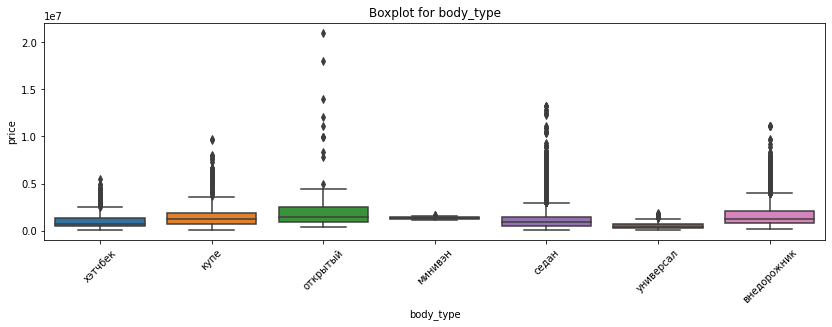

Найдены статистически значимые различия для колонки body_type


In [690]:
df_train = df[df.price != 0]
get_boxplot('body_type')
get_stat_dif('body_type')

### Работа с полем color

In [691]:
df['color'].value_counts(dropna=False)

040001         5560
FAFBFB         2656
0000CC         1858
97948F         1587
чёрный         1395
CACECB          855
белый           767
200204          747
синий           510
серый           453
EE1D19          419
коричневый      216
серебристый     191
007F00          168
C49648          163
22A0F8          156
красный         115
660099           72
FF8649           53
DEA522           48
бежевый          46
голубой          35
зелёный          33
4A2197           32
оранжевый        27
золотистый       23
пурпурный        20
FFD600           16
фиолетовый        5
жёлтый            1
Name: color, dtype: int64

В признаке цвета машины пропусков тоже нет, это категориальный (номинативный) признак. Всего здесь 30 значений. Составим словарь отображения цветов на русском в кода, а потом единообразно обработаем цветовые кода и приведем их к английским цветам. Для определения названия цвета кода будем использовать цветовую палитру matplotlib.colors.

In [692]:
import matplotlib.colors as mc
# используем палитру цветов matplotlib
mycss4list = mc.CSS4_COLORS

# коды для встречающихся русскоязычных названий цветов взяты из Википедии
colors = {
    'чёрный': '000000', 'белый': 'FFFFFF', 'синий': '0000FF', 'серый': '808080',
    'коричневый': 'A52A2A', 'серебристый': 'C0C0C0', 'красный': 'FF0000', 'бежевый': 'F5F5DC',
    'голубой': '75BBFD', 'зелёный': '008000', 'оранжевый': 'FFA500', 'золотистый': 'FFD700',
    'пурпурный': '800080', 'фиолетовый': '8B00FF', 'жёлтый': 'FFFF00'
}


def hex_to_rgb(value):
    # в словаре matplotlib первый символ - решетка, поэтому его не обрабатываем
    if value[0] == '#':
        return tuple(int(value[i:i+2], 16) for i in (1, 3, 5))
    # в нашем датасете решетки в названиях нет
    else:
        return tuple(int(value[i:i+2], 16) for i in (0, 2, 4))


# получение имени ближайшего цвета
def closest_colour(requested_colour):
    min_colours = {}
    # вычисление Евклидовых расстояний между искомым цветом и палитрой matplotlib
    for name, key in mycss4list.items():
        red, green, blue = hex_to_rgb(key)
        rd = (red - requested_colour[0]) ** 2
        gd = (green - requested_colour[1]) ** 2
        bd = (blue - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    # возвращаем название цвета с наименьшим расстоянием до искомого
    return min_colours[min(min_colours.keys())]


def get_colour_name(value):
    if value == value:
        hex_value = value
        if value in colors.keys():
            hex_value = colors[value]
        rgb_value = hex_to_rgb(hex_value)
        closest_name = closest_colour(rgb_value)
        return closest_name
    else:
        return value


unique_colors = df['color'].unique()

color_dict = {}

for color in unique_colors:
    color_dict[color] = get_colour_name(color)

df['color'] = df['color'].apply(lambda x: color_dict[x])

In [693]:
df['color'].value_counts(dropna=False)

black            7702
snow             2656
grey             2040
mediumblue       1858
lightgrey         855
white             767
blue              510
crimson           419
brown             216
green             201
silver            191
peru              163
dodgerblue        156
red               115
indigo             72
coral              53
goldenrod          48
beige              46
gold               39
lightskyblue       35
darkslateblue      32
orange             27
purple             20
darkviolet          5
yellow              1
Name: color, dtype: int64

В результате приведения к одному формату количество значений сократилось с 30 до 25. Соберем оттенки цветов в базовые (информация о цветах была взята также из Википедии).

In [694]:
def convert_color_to_base(value):
    if value in ['mediumblue', 'blue', 'dodgerblue', 'lightskyblue', 'indigo', 'darkslateblue']:
        return 'blue'
    if value in ['snow', 'white', 'beige']:
        return 'white'
    if value in ['grey', 'lightgrey', 'silver']:
        return 'grey'
    if value in ['crimson', 'red', 'brown', 'pink']:
        return 'red'
    if value in ['peru', 'goldenrod', 'gold', 'orange', 'yellow', 'coral']:
        return 'orange'
    if value in ['purple', 'darkviolet']:
        return 'purple'
    return value


df['color'] = df['color'].apply(convert_color_to_base)
df['color'].value_counts(dropna=False)

black     7702
white     3469
grey      3086
blue      2663
red        750
orange     331
green      201
purple      25
Name: color, dtype: int64

Осталось всего 8 значений, теперь посмотрим на их распределение и значимость признака на тренировочном датасете.

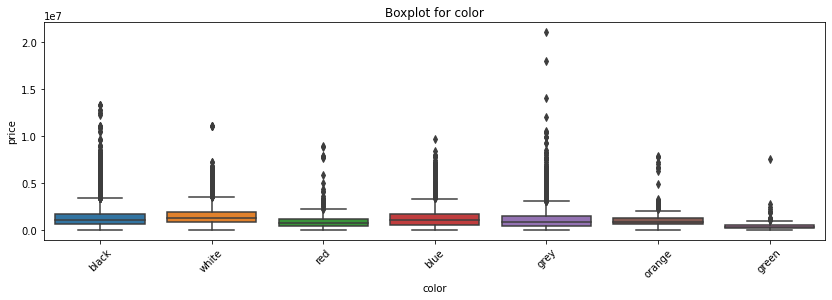

Найдены статистически значимые различия для колонки color


In [695]:
df_train = df[df.price != 0]
get_boxplot('color')
get_stat_dif('color')

### Работа с полем fuel_type

In [696]:
df['fuel_type'].value_counts(dropna=False)

бензин     12008
дизель      6185
гибрид        30
электро        4
Name: fuel_type, dtype: int64

Это также категориальный (номинативный) признак. Ситуация со значениями поля тоже выглядит хорошо, пропусков нет, формат значений единый. Построим распределение значений и проверим признак на статистическую значимость.

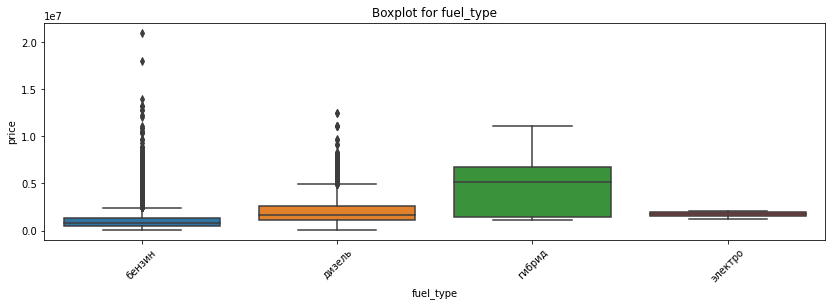

Найдены статистически значимые различия для колонки fuel_type


In [697]:
get_boxplot('fuel_type')
get_stat_dif('fuel_type')

### Работа с полем model_date

In [698]:
df['model_date'].unique()

array([2007., 2017., 2011., 2015., 2004., 2014., 2018., 1965., 2005.,
       2008., 2001., 1998., 1990., 1975., 1982., 1937., 1936., 1949.,
       2013., 2009., 2000., 2016., 1995., 2002., 1987., 1981., 1972.,
       2003., 1957., 2012., 1994., 2019., 1986., 1977., 1989., 1999.,
       1992., 1988., 2010., 2006., 1976.])

Это либо числовой, либо категориальный (порядковый) признак (в дальнейшем мы проведем анализ данного признака и в рамках числового, и категориального). Приведем его к целочисленному типу данных и посмотрим на распеделение значений.

In [699]:
df['model_date'] = df['model_date'].apply(lambda x: int(x))
df['model_date'].unique()

array([2007, 2017, 2011, 2015, 2004, 2014, 2018, 1965, 2005, 2008, 2001,
       1998, 1990, 1975, 1982, 1937, 1936, 1949, 2013, 2009, 2000, 2016,
       1995, 2002, 1987, 1981, 1972, 2003, 1957, 2012, 1994, 2019, 1986,
       1977, 1989, 1999, 1992, 1988, 2010, 2006, 1976], dtype=int64)

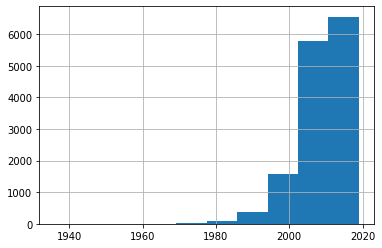

In [700]:
df_train = df[df.price != 0]
df_train['model_date'].hist()

Из графика видно, что в основном дата производства модели не более 20-25 лет назад. Посмотрим, есть ли выбросы.

25-й перцентиль: 2006.0, 75-й перцентиль: 2013.0, IQR: 7.0,  Границы выбросов: [1995.5, 2023.5].


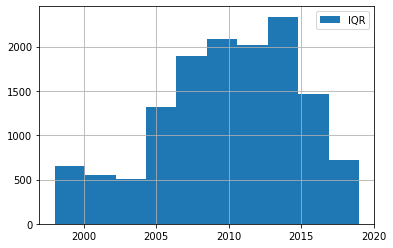

In [701]:
check_for_outliers('model_date', 10)

In [702]:
df['model_date'].value_counts(dropna=False, bins=5)

(2002.4, 2019.0]      15879
(1985.8, 2002.4]       2232
(1969.2, 1985.8]        103
(1935.916, 1952.6]       10
(1952.6, 1969.2]          3
Name: model_date, dtype: int64

По формуле получилось слишком много выбросов (все модели, выпущенные более 25 лет назад), но так как год выпуска - это важная составляющая (старые модели могут иметь меньшую стоимость, раритетно старые - наоборот, большую), то оставим все значения как есть.

### Работа с полями name и engine_displacement

In [703]:
df['name'].unique()

array(['116i 1.6 AT (115 л.с.)', '118i 1.5 AT (136 л.с.)',
       '116i 1.6 AT (136 л.с.)', '118i 2.0 AT (136 л.с.)',
       '118i 2.0 AT (129 л.с.)', '118i 1.6 AT (170 л.с.)',
       '120i 2.0 AT (150 л.с.)', '120d 2.0d AT (177 л.с.)',
       '118i 1.6 AT (136 л.с.)', '118d 2.0d MT (122 л.с.)',
       'M135i xDrive 3.0 AT (320 л.с.) 4WD', '118i 1.6 MT (170 л.с.)',
       '135i 3.0 AMT (306 л.с.)', '120d 2.0d AT (184 л.с.)',
       '125i 3.0 AT (218 л.с.)', 'M140i 3.0 AT (340 л.с.)',
       '120d 2.0d MT (184 л.с.) 4WD', '116i 1.6 MT (122 л.с.)',
       '116i 1.6 MT (115 л.с.)', '120i 2.0 MT (156 л.с.)',
       '130i 3.0 MT (265 л.с.)', '120d 2.0d MT (177 л.с.)',
       '120i 2.0 AT (156 л.с.)', '130i 3.0 AT (265 л.с.)',
       '120i 2.0 AT (184 л.с.)', '116i 1.6 MT (136 л.с.)',
       '116i 1.6 AT (122 л.с.)', '135i 3.0 AT (306 л.с.)',
       '118i 2.0 MT (143 л.с.)', '118d 2.0d AT (143 л.с.)',
       '2.0d AT (190 л.с.) 4WD', '1.5 AT (136 л.с.)',
       '3.0 AT (340 л.с.) 4WD', '220i

In [704]:
df['engine_displacement'].value_counts(dropna=False)

2.0 LTR      1538
3.0 LTR      1353
30d          1157
320i          945
35i           713
             ... 
335d            1
sDrive20i       1
30              1
725d            1
315             1
Name: engine_displacement, Length: 195, dtype: int64

Признак name объединяет в себе несколько других признаков (тип управления, мощность мотора, литраж), извлечем из него информацию о вместимости (литраже) мотора, которую запишем в признак engine_displacement, содержащий множество непонятных значений.

In [705]:
import re

LIT_RE = re.compile(r'\d+[.,]\d+', re.I)

def get_litres(value):
    result = LIT_RE.findall(value)
    if len(result) == 0:
        return None
    else:
        return float(result[0])
    
df['engine_displacement'] = df['name'].apply(get_litres)
df['engine_displacement'].unique()

array([1.6, 1.5, 2. , 3. , 2.5, 1.8, 2.2, 1.9, 2.8, 1.7, 2.9, 4.4, 4.8,
       3.4, 4. , 3.5, 2.4, 2.7, 0.6, 5.4, 6.6, 6. , 3.6, 5. , 3.2, 0.7,
       nan, 3.3, 3.8, 4.9, 4.6])

In [706]:
df[df['engine_displacement'] != df['engine_displacement']]['engine_displacement'].value_counts(dropna=False)

NaN    4
Name: engine_displacement, dtype: int64

Заполним пропуски в engine_displacement медианой, а после домножим значения на 1000 (переведем в мл) и приведем к целочисленному типу.

In [707]:
litr_median = df['engine_displacement'].median()
df['engine_displacement'] = df['engine_displacement'].apply(lambda x: x if x == x else litr_median)
df['engine_displacement'] = df['engine_displacement'].apply(lambda x: int(1000 * x))
df['engine_displacement'].value_counts(dropna=False)

2000    6763
3000    6486
4400    1430
2500    1330
1600     855
1500     303
4800     279
2200     170
1800     117
2800     114
1900      78
4000      64
3500      40
6000      27
5000      26
6600      24
2900      23
3400      20
5400      19
3600      18
4600      12
3300       8
4900       6
2700       4
700        3
600        2
3800       2
2400       2
1700       1
3200       1
Name: engine_displacement, dtype: int64

Посмотрим на распределение значений. На данный момент непонятно, числовой это признак или категориальный, но скорее всего, категориальный.

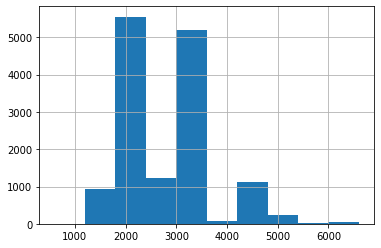

In [708]:
df_train = df[df.price != 0]
df_train['engine_displacement'].hist()

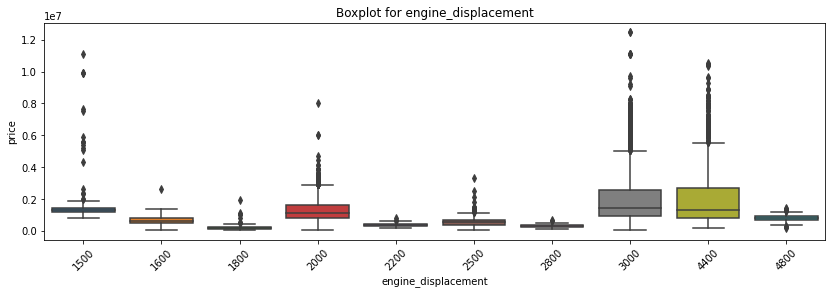

Найдены статистически значимые различия для колонки engine_displacement


In [709]:
get_boxplot('engine_displacement')
get_stat_dif('engine_displacement')

Теперь мы можем удалить ненужный признак name, так как мы извлекли из него всю нужную информацию (остальная есть в отдельных полях).

In [710]:
df.drop(columns=['name'], axis=1, inplace=True)

### Работа с полем doors_number

In [711]:
df['doors_number'].unique()

array([5., 3., 2., 4.])

Ситуация со значениями выглядит хорошо (нет пропусков, формат единый), приведем их к целочисленному типу и посмотрим на распределение значений. Это - категориальный (ординарный) признак.

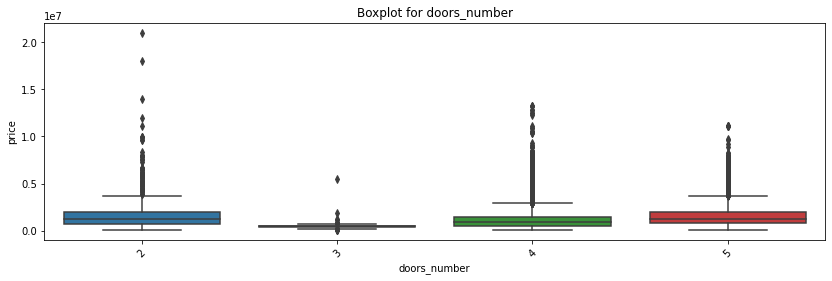

Найдены статистически значимые различия для колонки doors_number


In [712]:
df['doors_number'] = df['doors_number'].apply(lambda x: int(x))
df_train = df[df.price != 0]
get_boxplot('doors_number')
get_stat_dif('doors_number')

### Работа с полем production_date

Это так же, как и год выпуска модели, либо числовой, либо категориальный (порядковый) признак. Приведем его к целочисленному типу данных и посмотрим на распеделение значений.

In [713]:
df['production_date'].unique()

array([2008., 2011., 2017., 2014., 2013., 2009., 2012., 2006., 2005.,
       2018., 2019., 2010., 2015., 2016., 2007., 2004., 1968., 2003.,
       2002., 2001., 2000., 2020., 1999., 1998., 1996., 1992., 1979.,
       1985., 1991., 1988., 1993., 1994., 1997., 1984., 1986., 1982.,
       1995., 1981., 1990., 1989., 1983., 1987., 1937., 1949., 1947.,
       1948., 1950., 1975., 1958., 1980., 1977.])

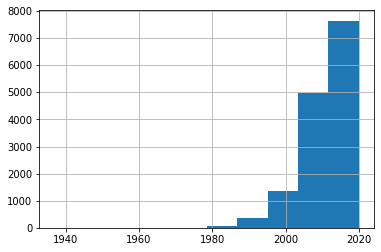

In [714]:
df['production_date'] = df['production_date'].apply(lambda x: int(x))
df_train = df[df.price != 0]
df_train['production_date'].hist()

Распределение значений очень похоже на то, которое наблюдалось у признака model_date.

25-й перцентиль: 2008.0, 75-й перцентиль: 2015.0, IQR: 7.0,  Границы выбросов: [1997.5, 2025.5].


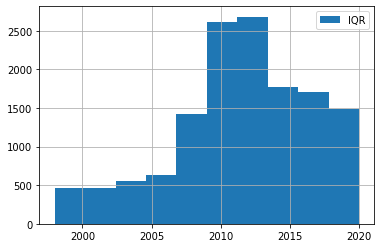

In [715]:
check_for_outliers('production_date', 10)

Границы выбросов получились тоже похожими на границы у model_date, но оставим данные как есть, так как год производства машины вероятно будет сильно влиять на цену, из соображений логики. Также есть подозрение, что корреляция между этими двумя признаками будет очень сильной (проверим это предположение чуть позже).

### Работа с полем vehicle_cofiguration

In [716]:
df['vehicle_configuration'].value_counts(dropna=False)

AUTOMATIC           13458
автоматическая       3677
MECHANICAL            791
ROBOT                 141
механическая          111
роботизированная       49
Name: vehicle_configuration, dtype: int64

Это категориальный (номинативный) признак. По факту у нас есть всего 4 значения - вариатор (в расширенной версии датасета), автоматическая, роботизированная или механическая коробка передач. Уберем дубликаты.

In [717]:
configurations = {
    'AUTOMATIC': 'автоматическая',
    'MECHANICAL': 'механическая',
    'VARIATOR': 'вариатор',
    'ROBOT': 'роботизированная'
}


def clean_vehicle_configuration(value):
    if value in configurations.keys():
        return configurations[value]
    else:
        return value


df['vehicle_configuration'] = df['vehicle_configuration'].apply(
    clean_vehicle_configuration)
df['vehicle_configuration'].value_counts(dropna=False)

автоматическая      17135
механическая          902
роботизированная      190
Name: vehicle_configuration, dtype: int64

Посмотрим на распределение значений, а также на важность признака.

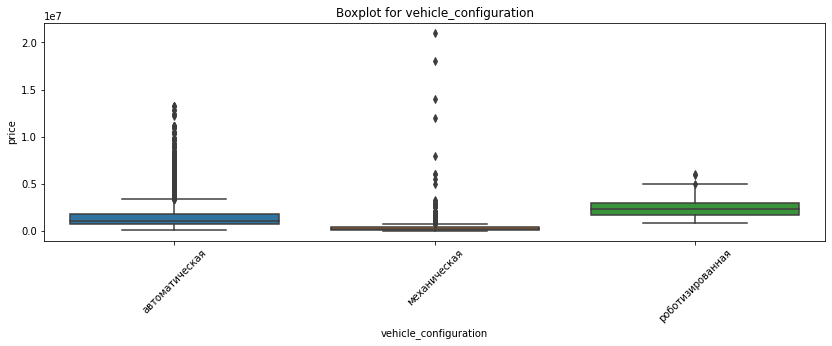

Найдены статистически значимые различия для колонки vehicle_configuration


In [718]:
df_train = df[df.price != 0]
get_boxplot('vehicle_configuration')
get_stat_dif('vehicle_configuration')

### Работа с полем engine_power

In [719]:
df['engine_power'].unique()

array([115.0, 136.0, 129.0, 170.0, 150.0, 177.0, 122.0, 320.0, 306.0,
       184.0, 218.0, 340.0, 156.0, 265.0, 143.0, 190.0, 326.0, 140.0,
       116.0, 245.0, 249.0, 387.0, 258.0, 105.0, 233.0, 192.0, 118.0,
       102.0, 163.0, 90.0, 125.0, 231.0, 113.0, 272.0, 100.0, 171.0,
       193.0, 286.0, 75.0, 234.0, 46.0, 51.0, 400.0, 204.0, 381.0, 407.0,
       252.0, 367.0, 197.0, 313.0, 300.0, 235.0, 462.0, 211.0, 333.0,
       230.0, 188.0, 450.0, 19.0, 610.0, 609.0, 445.0, 530.0, 544.0,
       410.0, 370.0, 420.0, 343.0, 431.0, 460.0, 507.0, 625.0, 560.0,
       600.0, 575.0, 360.0, 264.0, 355.0, 329.0, 269.0, 347.0, 555.0,
       449.0, 238.0, 243.0, 585.0, '190 N12', '150 N12', '407 N12',
       '249 N12', '381 N12', '245 N12', '177 N12', '184 N12', '115 N12',
       '231 N12', '156 N12', '306 N12', '218 N12', '136 N12', '235 N12',
       '286 N12', '122 N12', '265 N12', '258 N12', '340 N12', '355 N12',
       '170 N12', '333 N12', '192 N12', '610 N12', '264 N12', '555 N12',
       '

Так как мощность мотора может иметь большое множество значений, скорее всего можно считать данный признак числовым (но возможно, он является категориальным). Приведем данные к единому формату, а затем посмотрим на распределение данных.

In [720]:
def clean_engine_power(value):
    value = str(value)
    value = value.replace(' N12', '')
    return (int(float(value)))


df['engine_power'] = df['engine_power'].apply(clean_engine_power)
df['engine_power'].unique()

array([115, 136, 129, 170, 150, 177, 122, 320, 306, 184, 218, 340, 156,
       265, 143, 190, 326, 140, 116, 245, 249, 387, 258, 105, 233, 192,
       118, 102, 163,  90, 125, 231, 113, 272, 100, 171, 193, 286,  75,
       234,  46,  51, 400, 204, 381, 407, 252, 367, 197, 313, 300, 235,
       462, 211, 333, 230, 188, 450,  19, 610, 609, 445, 530, 544, 410,
       370, 420, 343, 431, 460, 507, 625, 560, 600, 575, 360, 264, 355,
       329, 269, 347, 555, 449, 238, 243, 585, 374], dtype=int64)

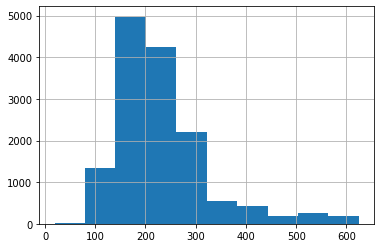

In [721]:
df_train = df[df.price != 0]
df_train['engine_power'].hist()

Распределение данных напоминает нормальное. Проверим данные на выбросы.

25-й перцентиль: 184.0, 75-й перцентиль: 272.0, IQR: 88.0,  Границы выбросов: [52.0, 404.0].


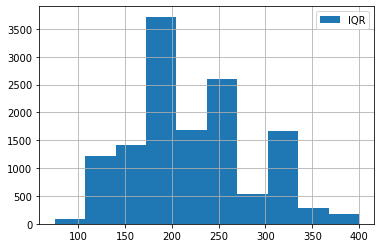

In [722]:
check_for_outliers('engine_power', 10)

Формула предлагает нам выкинуть данные о мощных моторах, но этого делать мы не будем, так как мощность мотора, по первичным предположениям, может влиять на цену.

### Работа с полем mileage

In [723]:
df['mileage'].value_counts().sort_values(ascending=False)

200000.0    179
140000.0    177
300000.0    164
160000.0    152
130000.0    146
           ... 
63242.0       1
421325.0      1
27356.0       1
23143.0       1
190800.0      1
Name: mileage, Length: 4843, dtype: int64

Это числовой признак. Посмотрим на его распределение.

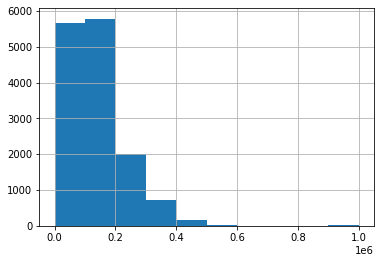

In [724]:
df_train = df[df.price != 0]
df_train['mileage'].hist()

25-й перцентиль: 70045.25, 75-й перцентиль: 185000.0, IQR: 114954.75,  Границы выбросов: [-102386.875, 357432.125].


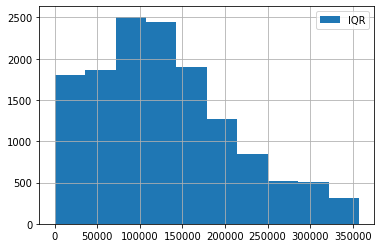

In [725]:
check_for_outliers('mileage', 10)

Приведем признак к целочисленному виду.

In [726]:
df['mileage'] = df['mileage'].apply(lambda x: int(x))

### Работа с полем drive_type

In [727]:
df['drive_type'].value_counts(dropna=False)

полный      10880
задний       7279
передний       68
Name: drive_type, dtype: int64

Признак категориальный (номинативный). Пропусков нет, и значения уже приведены к единому формату.

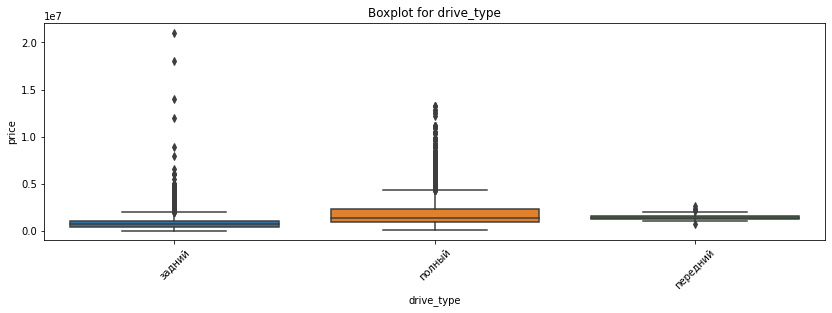

Найдены статистически значимые различия для колонки drive_type


In [728]:
df_train = df[df.price != 0]
get_boxplot('drive_type')
get_stat_dif('drive_type')

### Работа с полем steering_wheel

In [729]:
df['steering_wheel'].value_counts(dropna=False)

LEFT     14386
Левый     3837
RIGHT        4
Name: steering_wheel, dtype: int64

Это бинарный признак. Приведем значения к единому формату - 1 ("Левый") и 0 ("Правый").

In [730]:
def clean_steering_wheel(value):
    if value == 'LEFT' or value == 'Левый':
        return 1
    if value == 'RIGHT':
        return 0
    return value


df['steering_wheel'] = df['steering_wheel'].apply(clean_steering_wheel)
df.head(3)

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,steering_wheel,owners,technical_passport,customs,price
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,{'id': '0'},задний,1,2,ORIGINAL,True,436000
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,"{'id': '2430196', 'name': '116', 'available_op...",задний,1,1,ORIGINAL,True,595000
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1500,136,41000,{'id': '0'},задний,1,2,ORIGINAL,True,1150000


Посмотрим на распределение значений, а также на значимость данного признака.

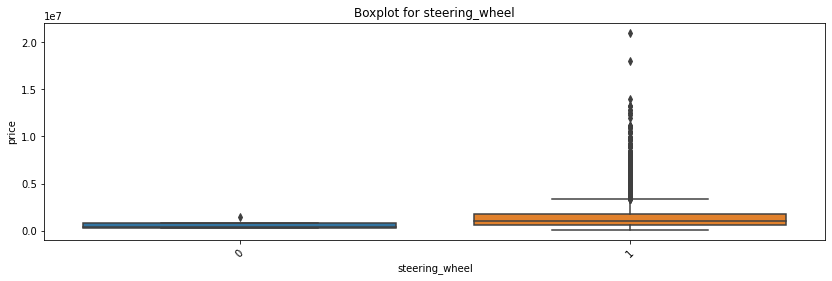

Статистически значимых различий для колонки steering_wheel не найдено


In [731]:
df_train = df[df.price != 0]
get_boxplot('steering_wheel')
get_stat_dif('steering_wheel')

Так как статистически значимых различий для данного признака не найдено (наблюдается почти стопроцентный перекос данных в сторону леворульных машин), можем его удалить из нашего датасета.

In [732]:
df = df.drop(columns=['steering_wheel'], axis=1)

### Работа с полем owners

In [733]:
df['owners'].value_counts(dropna=False)

3.0            6323
1.0            4075
2.0            3990
3 или более    1516
1 владелец     1309
2 владельца    1012
NaN               2
Name: owners, dtype: int64

Это категориальный (порядковый) признак. Также приведем все значения к единому формату.

In [734]:
def clean_owners(value):
    if value != value or pd.isnull(value):
        return value
    else:
        return int(str(value)[0])


df['owners'] = df['owners'].apply(clean_owners)
df['owners'].value_counts(dropna=False)

3.0    7839
1.0    5384
2.0    5002
NaN       2
Name: owners, dtype: int64

Заполним пропуски медианным значением.

In [735]:
owners_median = int(df['owners'].median())
df['owners'] = df['owners'].apply(
    lambda x: int(x) if x == x else owners_median)

Теперь посмотрим на распределение данных и значимость признака.

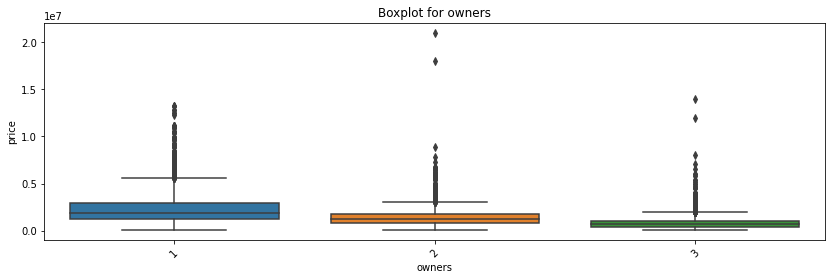

Найдены статистически значимые различия для колонки owners


In [736]:
df_train = df[df.price != 0]
get_boxplot('owners')
get_stat_dif('owners')

### Работа с полем technical_passport

In [737]:
df['technical_passport'].value_counts(dropna=False)

ORIGINAL     12521
Оригинал      3463
DUPLICATE     1869
Дубликат       374
Name: technical_passport, dtype: int64

Это бинарный признак. Также приведем значения к единому формату, а затем заполним пропуски модой.

In [738]:
def clean_technical_passport(value):
    if value == 'ORIGINAL' or value == 'Оригинал':
        return 1
    if value == 'DUPLICATE' or value == 'Дубликат':
        return 0
    return value


df['technical_passport'] = df['technical_passport'].apply(
    clean_technical_passport)
passport_mode = df['technical_passport'].mode()[0]
df['technical_passport'] = df['technical_passport'].apply(
    lambda x: x if x == x else passport_mode)
df['technical_passport'].value_counts(dropna=False)

1    15984
0     2243
Name: technical_passport, dtype: int64

Теперь также посмотрим, как распределены значения, и на важность признака.

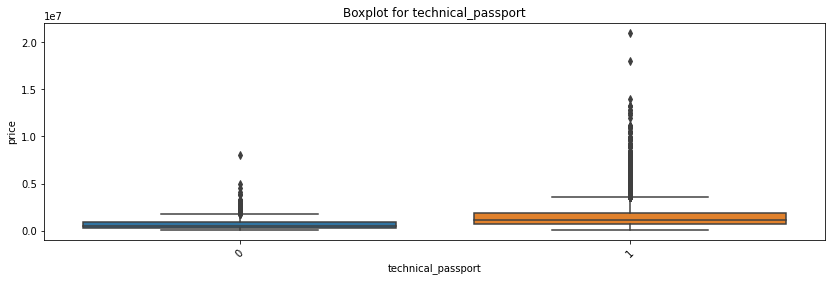

Найдены статистически значимые различия для колонки technical_passport


In [739]:
df_train = df[df.price != 0]
get_boxplot('technical_passport')
get_stat_dif('technical_passport')

### Работа с полем customs

In [740]:
df['customs'].value_counts(dropna=False)

True          14390
Растаможен     3837
Name: customs, dtype: int64

Если привести значения к одному формату, в данном признаке у нас всего одно значение - "Растаможен", а значит, данный признак бесполезен, и его можно удалить.

In [741]:
df.drop(columns=['customs'], axis=1, inplace=True)
df.head(3)

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,{'id': '0'},задний,2,1,436000
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,"{'id': '2430196', 'name': '116', 'available_op...",задний,1,1,595000
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1500,136,41000,{'id': '0'},задний,2,1,1150000


### Работа с полем complectation

In [742]:
df['complectation'].unique()

array(["{'id': '0'}",
       "{'id': '2430196', 'name': '116', 'available_options': ['airbag-passenger', 'lock', 'electro-mirrors', 'computer', 'seat-transformation', 'wheel-power', 'fabric-seats', 'airbag-side', 'abs', 'esp', 'audiopreparation', 'electro-window-back', 'airbag-driver', 'electro-window-front', 'audiosystem-cd', 'wheel-configuration2', 'wheel-configuration1', 'immo']}",
       "{'id': '7707468', 'name': '116i', 'available_options': ['sport-seats', 'multi-wheel', 'xenon', 'airbag-passenger', 'lock', 'electro-mirrors', 'mirrors-heat', 'start-stop-function', 'automatic-lighting-control', 'computer', 'seat-transformation', 'wheel-power', 'light-cleaner', 'airbag-side', 'abs', 'wheel-leather', 'esp', 'usb', 'audiopreparation', 'ashtray-and-cigarette-lighter', 'front-centre-armrest', 'electro-window-back', '16-inch-wheels', 'combo-interior', 'condition', 'park-assist-r', 'airbag-driver', 'isofix', 'electro-window-front', 'airbag-curtain', 'paint-metallic', 'start-button', 'ptf

Для тестового и тренировочного датасета слишком разный набор значений, обработаем датасеты по отдельности.

In [743]:
df_train = df[df.price != 0]
df_test = df[df.price == 0]

#### Обработка тренировочного датасета

In [744]:
def parse_train_complectation(value):
    if value != value or pd.isnull(value):
        return []
    result = value.replace(' ', '')
    result = result.replace("'", '')
    first_bracket = result.find('[')
    second_bracket = result.find(']')
    if first_bracket != -1 and second_bracket != -1:
        return result[first_bracket+1:second_bracket].split(',')
    else:
        return []


df_train['complectation'] = df_train['complectation'].apply(
    parse_train_complectation)

In [745]:
# соберем все уникальные названия в признаке комплектации
from collections import defaultdict

complectation = defaultdict(int)

for value in df_train['complectation']:
    if value == value and value != None:
        for item in value:
            complectation[item] += 1

In [746]:
len(complectation.keys())

141

У нас 141 уникальное значение для тренировочного датасета. Если генерировать по всем ним столбцы с помощью get_dummies, то получится слишком много признаков, так что оставим N наиболее часто встречающихся.

In [747]:
MOST_FREQUENT_NUM = 35
sort_complectation = sorted(complectation.items(),
                            key=lambda x: x[1], reverse=True)
most_frequent_items = []
for item in sort_complectation[:MOST_FREQUENT_NUM]:
    most_frequent_items.append(item[0])

# удалим из списка самых часто встречающихся значений те, которым не нашлось сопоставления на русском языке
# нет данных по: dha,power-latching-doors,reduce-spare-wheel,laminated-safety-glass,drl,sport-pedals,wheel-configuration2
# windcleaner-heat, door-sill-panel,heated-wash-system, music-super, servo, fabric-seats, hcc, wheel-configuration1,
not_existing_items = ['dha', 'power-latching-doors', 'reduce-spare-wheel', 'laminated-safety-glass', 'drl',
                      'sport-pedals', 'wheel-configuration2', 'windcleaner-heat', 'door-sill-panel', 'heated-wash-system',
                      'music-super', 'servo', 'fabric-seats', 'hcc', 'wheel-configuration1']
for item in not_existing_items:
    if item in most_frequent_items:
        most_frequent_items.remove(item)


def fill_complectation_train_item(value):
    if item in value:
        return 1
    else:
        return 0


for item in most_frequent_items:
    df_train[item] = df_train['complectation'].apply(
        fill_complectation_train_item)

df_train.head()

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,mirrors-heat,electro-window-back,ptf,audiosystem-cd,audiopreparation,airbag-curtain,wheel-leather,isofix,multi-wheel,climate-control-1,front-seats-heat,rain-sensor,front-centre-armrest,light-sensor,condition,park-assist-r,start-button,seat-transformation,start-stop-function,third-rear-headrest,automatic-lighting-control
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,[],задний,2,1,436000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,"[airbag-passenger, lock, electro-mirrors, comp...",задний,1,1,595000,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1500,136,41000,[],задний,2,1,1150000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,хэтчбек,red,бензин,2011,5,2014,автоматическая,1600,136,87284,"[sport-seats, multi-wheel, xenon, airbag-passe...",задний,3,1,660000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1
4,хэтчбек,white,бензин,2011,5,2013,автоматическая,1600,136,124000,"[sport-seats, multi-wheel, xenon, airbag-passe...",задний,3,1,575000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1


#### Обработка тестового датасета

In [748]:
import json


def parse_test_complectation(value):
    if value != value or pd.isnull(value):
        return []
    value = value.replace("['", '')
    value = value.replace("']", '')
    values = json.loads(value)
    result = []
    for item in values:
        if 'values' in item.keys():
            result.extend(item['values'])
    return result


df_test['complectation'] = df_test['complectation'].apply(
    parse_test_complectation)
df_test.head()

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price
14390,седан,black,дизель,2016,4,2017,автоматическая,2000,190,158836,"[Антипробуксовочная система (ASR), Система ста...",задний,1,1,0
14391,седан,white,дизель,2018,4,2019,автоматическая,2000,150,10,"[Круиз-контроль, Мультифункциональное рулевое ...",задний,1,1,0
14392,седан,blue,бензин,2009,4,2012,автоматическая,4400,407,120000,"[Круиз-контроль, Мультифункциональное рулевое ...",полный,2,1,0
14393,внедорожник,white,дизель,2014,5,2015,автоматическая,3000,249,111466,"[Круиз-контроль, Система «старт-стоп», Электро...",полный,2,1,0
14394,внедорожник,blue,дизель,2014,5,2019,автоматическая,3000,381,11891,"[Круиз-контроль, Электрорегулировка руля, Муль...",полный,1,1,0


In [749]:
# соберем все уникальные названия в признаке комплектации
from collections import defaultdict

complectation_test = defaultdict(int)

for value in df_test['complectation']:
    if value == value and value != None:
        for item in value:
            complectation_test[item] += 1

In [750]:
len(complectation_test.keys())

169

Теперь необходимо сопоставить те признаки, которые мы отобрали в тренировочном датасете - необходимо найти их аналоги в русском датасете.

In [751]:
# Сопоставление данных на английском (df_train) и русском (df_test) языке
train_to_test_complectation = {
    'airbag-driver': 'Подушка безопасности водителя', 'electro-window-front': 'Электростеклоподъёмники передние',
    'lock': 'Центральный замок', 'immo': 'Иммобилайзер', 'abs': 'Антиблокировочная система (ABS)',
    'airbag-passenger': 'Подушка безопасности пассажира', 'electro-mirrors': 'Электроскладывание зеркал',
    'mirrors-heat': 'Электрообогрев боковых зеркал', 'audiopreparation': 'Аудиоподготовка', 'audiosystem-cd': 'Аудиосистема',
    'computer': 'Бортовой компьютер', 'electro-window-back': 'Электростеклоподъёмники задние',
    'airbag-side': 'Подушки безопасности боковые', 'esp': 'Система стабилизации (ESP)',
    'front-seats-heat': 'Подогрев передних сидений', 'seat-transformation': 'Складывающееся заднее сиденье',
    'climate-control-1': 'Климат-контроль 1-зонный', 'condition': 'Кондиционер', 'night-vision': 'Система ночного видения',
    'vsm': 'Система стабилизации рулевого управления (VSM)', 'alcantara': 'Алькантара (Материал салона)',
    'audiosystem-tv': 'Аудиосистема с TV', 'ya-auto': 'Яндекс.Авто', 'massage-seats': 'Сиденья с массажем',
    'dual-xenon': 'Ксеноновые/Биксеноновые фары', 'xenon': 'Ксеноновые/Биксеноновые фары',
    '14-inch-wheels': 'Диски 14', '220v-socket': 'Розетка 220V',
    'isofix-front': 'Крепление детского кресла (передний ряд) ISOFIX',
    'remote-engine-start': 'Дистанционный запуск двигателя', 'front-camera': 'Камера передняя',
    'e-adjustment-wheel': 'Электрорегулировка руля', 'laser-lights': 'Лазерные фары',
    'driver-seat-electric': 'Электрорегулировка сиденья водителя', 'eco-leather': 'Искусственная кожа (Материал салона)',
    '22-inch-wheels': 'Диски 22', 'sport-suspension': 'Спортивная подвеска', 'air-suspension': 'Пневмоподвеска',
    'wheel-memory': 'Рулевая колонка с памятью положения', 'projection-display': 'Проекционный дисплей',
    'android-auto': 'Android Auto', 'rear-seat-heat-vent': 'Вентиляция задних сидений',
    'wireless-charger': 'Беспроводная зарядка для смартфона', '21-inch-wheels': 'Диски 21',
    'activ-suspension': 'Активная подвеска', 'easy-trunk-opening': 'Открытие багажника без помощи рук',
    'programmed-block-heater': 'Программируемый предпусковой отопитель',
    'folding-tables-rear': 'Складной столик на спинках передних сидений',
    'folding-front-passenger-seat': 'Функция складывания спинки сиденья пассажира',
    'entertainment-system-for-rear-seat-passengers': 'Мультимедиа система для задних пассажиров',
    'driver-seat-memory': 'Память сиденья водителя', 'multizone-climate-control': 'Климат-контроль многозонный',
    'body-kit': 'Обвес кузова', 'electronic-gage-panel': 'Электронная приборная панель',
    'driver-seat-updown': 'Регулировка сиденья водителя по высоте', 'spare-wheel': 'Полноразмерное запасное колесо',
    '15-inch-wheels': 'Диски 15', 'apple-carplay': 'CarPlay', 'climate-control-2': 'Климат-контроль 2-зонный',
    'decorative-interior-lighting': 'Декоративная подсветка салона', 'auto-cruise': 'Адаптивный круиз-контроль',
    'passenger-seat-updown': 'Регулировка передних сидений по высоте',
    'roller-blind-for-rear-window': 'Солнцезащитная шторка на заднем стекле',
    'panorama-roof': 'Панорамная крыша / лобовое стекло', 'voice-recognition': 'Голосовое управление',
    '20-inch-wheels': 'Диски 20', 'lane-keeping-assist': 'Система контроля за полосой движения',
    'blind-spot': 'Система контроля слепых зон', 'bas': 'Система помощи при торможении (BAS, EBD)',
    'asr': 'Антипробуксовочная система (ASR)', 'third-row-seats': 'Третий ряд сидений',
    '19-inch-wheels': 'Диски 19', 'glonass': 'ЭРА-ГЛОНАСС', 'airbag-rear-side': 'Подушки безопасности боковые задние',
    '360-camera': 'Камера 360°', 'front-seats-heat-vent': 'Вентиляция передних сидений',
    'combo-interior': 'Комбинированный (Материал салона)', 'auto-park': 'Система автоматической парковки',
    'steel-wheels': 'Стальные диски', '16-inch-wheels': 'Диски 16', 'sport-seats': 'Спортивные передние сиденья',
    'windscreen-heat': 'Электрообогрев лобового стекла', 'collision-prevention-assist': 'Система предотвращения столкновения',
    'drowsy-driver-alert-system': 'Датчик усталости водителя', 'adaptive-light': 'Система адаптивного освещения',
    'high-beam-assist': 'Система управления дальним светом', 'tinted-glass': 'Тонированные стекла',
    'hatch': 'Люк', 'rear-seats-heat': 'Подогрев задних сидений', 
    'knee-airbag': 'Подушка безопасности для защиты коленей водителя',
    'steering-wheel-gear-shift-paddles': 'Подрулевые лепестки переключения передач',
    '18-inch-wheels': 'Диски 18', 'volume-sensor': 'Датчик проникновения в салон (датчик объема)',
    'electro-trunk': 'Электропривод крышки багажника', '17-inch-wheels': 'Диски 17',
    'seat-memory': 'Память передних сидений', 'wheel-heat': 'Обогрев рулевого колеса',
    'led-lights': 'Светодиодные фары', 'keyless-entry': 'Система доступа без ключа',
    'navigation': 'Навигационная система', 'rear-camera': 'Камера задняя',
    'roof-rails': 'Рейлинги на крыше', 'start-stop-function': 'Система «старт-стоп»',
    'start-button': 'Запуск двигателя с кнопки', 'automatic-lighting-control': 'Автоматический корректор фар',
    'tyre-pressure': 'Датчик давления в шинах', 'leather-gear-stick': 'Отделка кожей рычага КПП',
    'ashtray-and-cigarette-lighter': 'Прикуриватель и пепельница',
    'park-assist-f': 'Парктроник передний', 'paint-metallic': 'Металлик', 'auto-mirrors': 'Электропривод зеркал',
    'alarm': 'Сигнализация', 'leather': 'Кожа (Материал салона)', 'park-assist-r': 'Парктроник задний',
    'passenger-seat-electric': 'Электрорегулировка передних сидений', 'light-cleaner': 'Омыватель фар',
    'bluetooth': 'Bluetooth', 'usb': 'USB', '12v-socket': 'Розетка 12V', 'light-sensor': 'Датчик света',
    'rain-sensor': 'Датчик дождя', 'front-centre-armrest': 'Передний центральный подлокотник',
    'wheel-power': 'Усилитель руля', 'third-rear-headrest': 'Третий задний подголовник', 'aux': 'AUX',
    'cruise-control': 'Круиз-контроль', 'airbag-curtain': 'Подушки безопасности оконные (шторки)',
    'multi-wheel': 'Мультифункциональное рулевое колесо', 'wheel-leather': 'Отделка кожей рулевого колеса',
    'isofix': 'Крепление детского кресла (задний ряд) ISOFIX', 'ptf': 'Противотуманные фары',
    'body-mouldings': 'Декоративные молдинги', 'black-roof': 'Отделка потолка чёрной тканью',
    'drive-mode-sys': 'Система выбора режима движения',
    'power-child-locks-rear-doors': 'Блокировка замков задних дверей',
    'cooling-box': 'Охлаждаемый перчаточный ящик', 'electro-rear-seat': 'Электрорегулировка задних сидений'
}

In [752]:
def fill_complectation_test_item(value):
    if train_to_test_complectation[item] in value:
        return 1
    else:
        return 0


for item in most_frequent_items:
    df_test[item] = df_test['complectation'].apply(fill_complectation_test_item)

df_test.head()

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,mirrors-heat,electro-window-back,ptf,audiosystem-cd,audiopreparation,airbag-curtain,wheel-leather,isofix,multi-wheel,climate-control-1,front-seats-heat,rain-sensor,front-centre-armrest,light-sensor,condition,park-assist-r,start-button,seat-transformation,start-stop-function,third-rear-headrest,automatic-lighting-control
14390,седан,black,дизель,2016,4,2017,автоматическая,2000,190,158836,"[Антипробуксовочная система (ASR), Система ста...",задний,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,0,1,1,1,1,0,1,0,1,1,0,1
14391,седан,white,дизель,2018,4,2019,автоматическая,2000,150,10,"[Круиз-контроль, Мультифункциональное рулевое ...",задний,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,0,1,0,1,1,1
14392,седан,blue,бензин,2009,4,2012,автоматическая,4400,407,120000,"[Круиз-контроль, Мультифункциональное рулевое ...",полный,2,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,0,1,0,1
14393,внедорожник,white,дизель,2014,5,2015,автоматическая,3000,249,111466,"[Круиз-контроль, Система «старт-стоп», Электро...",полный,2,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,0,1,0,1,1,1,1
14394,внедорожник,blue,дизель,2014,5,2019,автоматическая,3000,381,11891,"[Круиз-контроль, Электрорегулировка руля, Муль...",полный,1,1,0,0,1,0,1,1,0,1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,1,1,0,0,0,1


Теперь мы извлекли дополнительную информацию по наиболее часто встречающимся значениям из комплектации, сформировали новые признаки и привели оба датасета к единому набору признаков. Снова объединим их для удобства обработки данных.

In [753]:
df = pd.concat([df_train, df_test], ignore_index=True)

for col in most_frequent_items:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки airbag-passenger
Найдены статистически значимые различия для колонки abs
Найдены статистически значимые различия для колонки airbag-driver
Найдены статистически значимые различия для колонки lock
Найдены статистически значимые различия для колонки computer
Найдены статистически значимые различия для колонки airbag-side
Найдены статистически значимые различия для колонки esp
Найдены статистически значимые различия для колонки electro-window-front
Найдены статистически значимые различия для колонки immo
Найдены статистически значимые различия для колонки electro-mirrors
Найдены статистически значимые различия для колонки mirrors-heat
Найдены статистически значимые различия для колонки electro-window-back
Найдены статистически значимые различия для колонки ptf
Найдены статистически значимые различия для колонки audiosystem-cd
Найдены статистически значимые различия для колонки audiopreparation
Найдены статистически значимые различия для 

Не найдено статистически значимых различий для признаков xenon и volume-sensor, поэтому можно их сразу удалить из датасета.

In [754]:
if 'xenon' in df.columns:
    df = df.drop(columns=['xenon'], axis=1)
if 'volume-sensor' in df.columns:
    df = df.drop(columns=['volume-sensor'], axis=1)

df_train = df[df.price != 0]
df_test = df[df.price == 0]

## Корреляция признаков

### Корреляция числовых признаков

In [755]:
df.head()

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,mirrors-heat,electro-window-back,ptf,audiosystem-cd,audiopreparation,airbag-curtain,wheel-leather,isofix,multi-wheel,climate-control-1,front-seats-heat,rain-sensor,front-centre-armrest,light-sensor,condition,park-assist-r,start-button,seat-transformation,start-stop-function,third-rear-headrest,automatic-lighting-control
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,[],задний,2,1,436000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,"[airbag-passenger, lock, electro-mirrors, comp...",задний,1,1,595000,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1500,136,41000,[],задний,2,1,1150000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,хэтчбек,red,бензин,2011,5,2014,автоматическая,1600,136,87284,"[sport-seats, multi-wheel, xenon, airbag-passe...",задний,3,1,660000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1
4,хэтчбек,white,бензин,2011,5,2013,автоматическая,1600,136,124000,"[sport-seats, multi-wheel, xenon, airbag-passe...",задний,3,1,575000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1


Для начала посмотрим на корреляцию числовых переменных. Для этого построим heatmap по (предположительно) числовым признакам. Так как нет полной уверенности, что model_date, production_date, engine_displacement и engine_power это числовые (а не ординарные) признаки, проанализируем их и в числовых, и в категориальных.

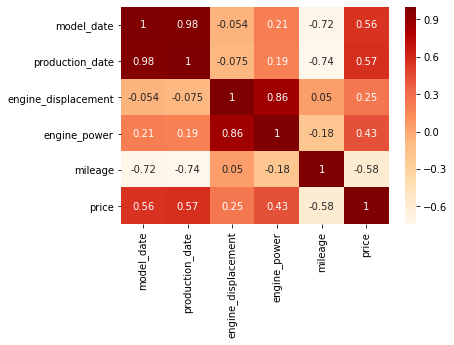

In [756]:
def heatmap(x,y,dataframe):
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()
    
dimension_col_list = ['model_date','production_date','engine_displacement','engine_power','mileage','price']

heatmap(10,10,df_train.filter(dimension_col_list))

Видна сильная корреляция данных между model_date и production_date. Также наблюдается сильная корреляция между engine_displacement и engine_power. Проанализируем эти признаки еще и в категориальных, а пока что удалим признак complectation, так как мы уже достали из него всю необходимую информацию.

In [757]:
df.drop(columns=['complectation'], axis=1, inplace=True)
df_train = df[df.price != 0]
df_test = df[df.price == 0]

Посмотрим на важность оставшихся признаков.

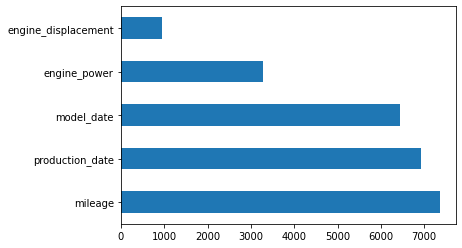

In [758]:
from sklearn.feature_selection import f_regression
from pandas import Series

num_columns = ['model_date', 'production_date',
               'engine_displacement', 'engine_power', 'mileage']
f_test, _ = f_regression(
    df_train[num_columns].values, df_train['price'].values)
imp_num = Series(f_test, index=num_columns)
imp_num.sort_values(ascending=False, inplace=True)
imp_num.plot(kind='barh')

### Корреляция бинарных признаков

Так как тест Стьюдента показал значимость практически на всех нечисловых признаках, попробуем посмотреть значимость признаков по другой метрике. Будем использовать mutual_info_regression из библиотеки sklearn.

In [759]:
import numpy as np

# сформируем список бинарных колонок
def get_binary_columns(datafame):
    binary_cols = []
    for column in datafame.columns:
        vals = datafame[column].unique()
        if len(vals) == 2 and 1 in vals and 0 in vals:
            binary_cols.append(column)
    return binary_cols


binary_columns = get_binary_columns(df_train)
print(binary_columns)

['technical_passport', 'airbag-passenger', 'abs', 'airbag-driver', 'lock', 'computer', 'airbag-side', 'esp', 'electro-window-front', 'immo', 'electro-mirrors', 'mirrors-heat', 'electro-window-back', 'ptf', 'audiosystem-cd', 'audiopreparation', 'airbag-curtain', 'wheel-leather', 'isofix', 'multi-wheel', 'climate-control-1', 'front-seats-heat', 'rain-sensor', 'front-centre-armrest', 'light-sensor', 'condition', 'park-assist-r', 'start-button', 'seat-transformation', 'start-stop-function', 'third-rear-headrest', 'automatic-lighting-control']


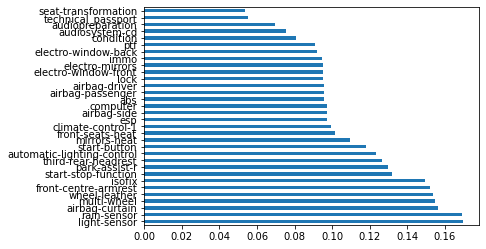

In [760]:
from pandas import Series
from sklearn.feature_selection import mutual_info_regression

imp_bin = Series(mutual_info_regression(
    X=df_train[binary_columns].values, y=df_train['price'].values, discrete_features=True), index=binary_columns)
imp_bin.sort_values(ascending=False, inplace=True)
imp_bin.plot(kind='barh')

Отберем бинарные признаки с важностью выше некоторого порога. Затем попробуем применить к ним корреляцию Мэтьюса для бинарных признаков.

In [761]:
IMPORTANCE = 0.06

print(imp_bin[imp_bin >= IMPORTANCE])

columns_to_delete = list(imp_bin[imp_bin < IMPORTANCE].index)

df.drop(columns=columns_to_delete, axis=1, inplace=True)
df_train = df[df.price != 0]
df_test = df[df.price == 0]

light-sensor                  0.169718
rain-sensor                   0.169235
airbag-curtain                0.156325
multi-wheel                   0.154658
wheel-leather                 0.153898
front-centre-armrest          0.151965
isofix                        0.149144
start-stop-function           0.131727
park-assist-r                 0.129521
third-rear-headrest           0.126281
automatic-lighting-control    0.123230
start-button                  0.118017
mirrors-heat                  0.109277
front-seats-heat              0.101352
climate-control-1             0.099485
esp                           0.097192
airbag-side                   0.097192
computer                      0.097192
abs                           0.095375
airbag-passenger              0.095375
airbag-driver                 0.095375
lock                          0.095332
electro-window-front          0.095167
electro-mirrors               0.094939
immo                          0.094778
electro-window-back      

Отберем по корреляции Мэтьюса те бинарные признаки, корреляция которых менее заданного порога.

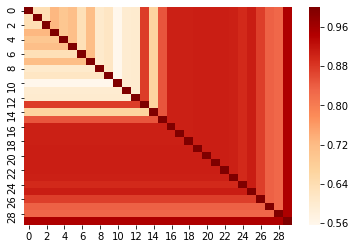

In [762]:
from sklearn.metrics import matthews_corrcoef

binary_columns = list(imp_bin[imp_bin >= IMPORTANCE].index)

# получение матрицы корреляции Мэттьюса
def get_mattiews_correlation(dataframe, columns):
    mattiews_corr = np.zeros((len(columns), len(columns)))
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if j >= i:  # получаем только для половины матрицы, так как она симметрична
                coef = matthews_corrcoef(df_train[col1], df_train[col2])
            mattiews_corr[i, j] = coef
            mattiews_corr[j, i] = coef
    return mattiews_corr


mattiews_corr = get_mattiews_correlation(df_train, binary_columns)
print()

sns.heatmap(mattiews_corr, cmap="OrRd")
plt.show()

In [763]:
binary_to_delete = []
binary_to_implement = []

CORR_VALUE = 0.6

for i, col1 in enumerate(binary_columns):
    if col1 not in binary_to_delete and col1 not in binary_to_implement:
        binary_to_implement.append(col1)
    for j, col2 in enumerate(binary_columns):
        if abs(mattiews_corr[i, j]) >= CORR_VALUE and abs(mattiews_corr[i, j]) != 1:
            if col2 not in binary_to_delete and col2 not in binary_to_implement:
                binary_to_delete.append(col2)

print('Всего отобранных по важности бинарных признаков: {}'.format(len(binary_columns)))
print('Количество бинарных признаков, которые можно оставить: {}'.format(
    len(binary_to_implement)))
print('Количество бинарных признаков, которые нужно убрать: {}'.format(
    len(binary_to_delete)))

Всего отобранных по важности бинарных признаков: 30
Количество бинарных признаков, которые можно оставить: 3
Количество бинарных признаков, которые нужно убрать: 27


In [764]:
df.drop(columns=binary_to_delete, axis=1, inplace=True)
df_train = df[df.price != 0]
df_test = df[df.price == 0]

df.head(3)

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,drive_type,owners,price,light-sensor,start-button,automatic-lighting-control
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,задний,2,436000,0,0,0
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,задний,1,595000,0,0,0
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1500,136,41000,задний,2,1150000,0,0,0


### Корреляция категориальных (ординарных) признаков

In [765]:
# определим колонки, которые надо переводить в численный вид (уже готовый вид - doors_number и owners)
categorical_columns = ['body_type', 'color',
                       'fuel_type', 'vehicle_configuration', 'drive_type']

for column in categorical_columns:
    if column in df.columns:
        df[column] = pd.Categorical(df[column]).codes

categorical_columns.append('doors_number')
categorical_columns.append('owners')
categorical_columns.append('production_date')
categorical_columns.append('model_date')
categorical_columns.append('engine_displacement')
categorical_columns.append('engine_power')

df.head(3)

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,drive_type,owners,price,light-sensor,start-button,automatic-lighting-control
0,6,0,0,2007,5,2008,0,1600,115,115000,0,2,436000,0,0,0
1,6,0,0,2007,5,2011,0,1600,115,39728,0,1,595000,0,0,0
2,6,7,0,2017,5,2017,0,1500,136,41000,0,2,1150000,0,0,0


Теперь все категориальные признаки приведены к числовому формату, применим к ним корреляцию по Кендаллу.

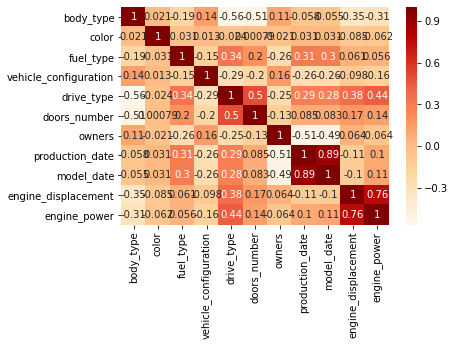

In [766]:
df_train = df[df.price != 0]
df_test = df[df.price == 0]

sns.heatmap(df_train.filter(categorical_columns).corr(
    method='kendall'), cmap="OrRd", annot=True)
plt.show()

Корреляция между всеми признаками слабая или умеренная, явной мультиколлинеарности не наблюдается, кроме как между model_date и production_date, а также между engine_power и engine_displacement, но она слабее, попробуем оставить оба этих признака. Оставим из них признаки production_date, engine_displacement и engine_power, после чего попробуем определить важность признаков с помощью mutual_info_regression.

In [767]:
#df.drop(columns=['engine_displacement', 'model_date'], axis=1, inplace=True)
df.drop(columns=['model_date'], axis=1, inplace=True)

categorical_columns = ['body_type', 'color', 'fuel_type', 'vehicle_configuration', 'drive_type',
                       'engine_power', 'owners', 'doors_number', 'production_date','engine_displacement']

df_train = df[df.price != 0]
df_test = df[df.price == 0]

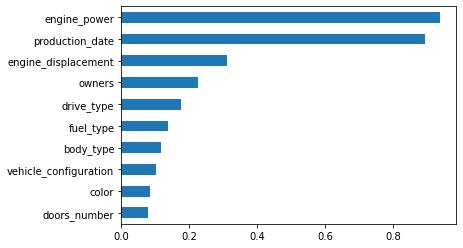

In [768]:
imp_cat = Series(mutual_info_regression(X=df_train[categorical_columns].values,
                                        y=df_train['price'].values, discrete_features=True),
                 index=categorical_columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Отберем наиболее важные признаки со значимостью выше заданного порога.

In [769]:
IMPORTANCE = 0.1
print(imp_cat[imp_cat >= IMPORTANCE])

columns_to_delete = list(imp_cat[imp_cat < IMPORTANCE].index)

df.drop(columns=columns_to_delete, axis=1, inplace=True)
df_train = df[df.price != 0]
df_test = df[df.price == 0]

df.head(3)

vehicle_configuration    0.101230
body_type                0.116172
fuel_type                0.136446
drive_type               0.175494
owners                   0.225753
engine_displacement      0.310130
production_date          0.895198
engine_power             0.940119
dtype: float64


,body_type,fuel_type,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,drive_type,owners,price,light-sensor,start-button,automatic-lighting-control
0,6,0,2008,0,1600,115,115000,0,2,436000,0,0,0
1,6,0,2011,0,1600,115,39728,0,1,595000,0,0,0
2,6,0,2017,0,1500,136,41000,0,2,1150000,0,0,0


Итак, мы оставили в датасете только наиболее важные, на первый взгляд, признаки. Теперь попробуем построить модель на основе полученных данных.

## Предобработка данных перед построением моделей

Чтобы модель принимала данные корректно, необходимо выделить отдельные значения в категориальных (номинативных, закодированных числами) признаках в отдельные признаки, это можно сделать с помощью get_dummies.

In [770]:
categorical_columns = ['body_type', 'fuel_type', 'drive_type']

for col in categorical_columns:
    if col in df.columns:
        col_dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, col_dummies], axis=1)
        df.drop(columns=[col], axis=1, inplace=True)

df.head()

,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,owners,price,light-sensor,start-button,automatic-lighting-control,body_type_0,body_type_1,body_type_2,body_type_3,body_type_4,body_type_5,body_type_6,fuel_type_0,fuel_type_1,fuel_type_2,fuel_type_3,drive_type_0,drive_type_1,drive_type_2
0,2008,0,1600,115,115000,2,436000,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
1,2011,0,1600,115,39728,1,595000,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
2,2017,0,1500,136,41000,2,1150000,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
3,2014,0,1600,136,87284,3,660000,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0
4,2013,0,1600,136,124000,3,575000,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0


## Построение модели

Разобьем данные на тренировочные (тренировочные и валидационные) и тестовые.

In [771]:
df_train = df[df.price != 0]
df_test = df[df.price == 0]

In [772]:
for col in df_train.columns:
    df_train[col] = df_train[col].apply(lambda x: int(x))

for col in df_test.columns:
    df_test[col] = df_test[col].apply(lambda x: int(x))

X = df_train.drop(columns=['price'], axis=1)
y = df_train['price']

### CatBoost

Попробуем использовать различные алгоритмы ML для получения наилучшего результата. Начнем с библиотеки CatBoost.

In [773]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

RANDOM_SEED = 42
VAL_SIZE = 0.1

In [774]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
X_test_target = df_test.drop(columns=['price'], axis=1)

# формируем список идентификаторов признаков для CatBoost
cat_cols = list(X_train.columns)
cat_cols.remove('mileage')

cat_features_ids = []

for i,col in enumerate(X_train.columns):
    if col in cat_cols:
        cat_features_ids.append(i)

print(cat_features_ids)

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [775]:
ITERATIONS = 6000
LR = 0.05

# обучение базовой модели CatBoost
cat_model = CatBoostRegressor(iterations=ITERATIONS,
                              learning_rate=LR,
                              random_seed=RANDOM_SEED,
                              eval_metric='MAPE',
                              custom_metric=['R2', 'MAE']
                              )
cat_model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose_eval=100,
              use_best_model=True,
              plot=True
              )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.1599281	test: 1.1224517	best: 1.1224517 (0)	total: 39ms	remaining: 3m 54s
100:	learn: 0.2157867	test: 0.2055135	best: 0.2055135 (100)	total: 1.95s	remaining: 1m 53s
200:	learn: 0.1862373	test: 0.1787215	best: 0.1787215 (200)	total: 3.99s	remaining: 1m 55s
300:	learn: 0.1713798	test: 0.1666172	best: 0.1666172 (300)	total: 6.17s	remaining: 1m 56s
400:	learn: 0.1640527	test: 0.1594384	best: 0.1594384 (400)	total: 8.58s	remaining: 1m 59s
500:	learn: 0.1577628	test: 0.1541337	best: 0.1541337 (500)	total: 11s	remaining: 2m
600:	learn: 0.1541952	test: 0.1514426	best: 0.1514426 (600)	total: 13.4s	remaining: 2m
700:	learn: 0.1507051	test: 0.1486839	best: 0.1486839 (700)	total: 15.8s	remaining: 1m 59s
800:	learn: 0.1482836	test: 0.1471904	best: 0.1471904 (800)	total: 18.5s	remaining: 2m
900:	learn: 0.1463680	test: 0.1457270	best: 0.1457128 (899)	total: 21s	remaining: 1m 58s
1000:	learn: 0.1444382	test: 0.1445285	best: 0.1445285 (1000)	total: 23.5s	remaining: 1m 57s
1100:	learn: 0.142

На базовой модели удалось добиться качества менее чем в 14% ошибки. Посмотрим на важность признаков для этой модели.

In [776]:
features_importances = pd.DataFrame(
    data=cat_model.feature_importances_, index=X.columns, columns=['FeatImportant'])
features_importances.sort_values(by='FeatImportant', ascending=False).head(20)

,FeatImportant
mileage,28.854488
engine_displacement,19.115774
production_date,17.800589
engine_power,16.510987
drive_type_2,3.650475
drive_type_0,2.847243
owners,1.868518
fuel_type_0,1.571149
vehicle_configuration,1.433803
body_type_3,1.265539


In [786]:
sample_submission = pd.read_csv('sample_submission.csv')
catboost_pred = cat_model.predict(df_test.drop(columns=['price'], axis=1))

# выгрузим объединенные по фолдам результаты в csv
VERSION = 1

# предположительно, данные тренировочного датасета не совсем актуальны по отношению к тестовому датасету
# поэтому домножим полученный результат на выбранный "коэффициент инфляции"
sample_submission['price'] = 0.9 * catboost_pred
sample_submission['price'] = sample_submission['price'].apply(lambda x: int(x))
sample_submission.to_csv(
    f'submission_catboost_base_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1485092
1,1,1329708
2,2,1074195
3,3,2057057
4,4,5484038
5,5,1697008
6,6,961698
7,7,681455
8,8,1288354
9,9,1271263


### Стекинг

Все параметры для используемых далее моделей подбирались отдельно, чтобы выбрать оптимальные и минимизировать время работы всего кода (подбор осуществлялся с помощью GridSearchCV).

In [778]:
import numpy as np


def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [797]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=RANDOM_SEED, criterion='mae', max_depth=15, min_samples_split=3,
                           min_samples_leaf=3)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print(mape(y_test, dt_pred))

13.116870880456775


In [811]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=RANDOM_SEED, criterion='mse', n_jobs=-1, min_samples_split=7,
                           max_depth=25)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(mape(y_test, rf_pred))

12.218325183694615


In [819]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(random_state=RANDOM_SEED, n_estimators=250, max_depth=12, learning_rate=0.03,
                        n_jobs=-1)

xgbr.fit(X_train, y_train)
xgbr_pred = xgbr.predict(X_test)
print(mape(y_test, xgbr_pred))

12.109241478361595


In [820]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor

df_train = df[df.price != 0]
df_test = df[df.price == 0]

X = df_train.drop(columns=['price'], axis=1)
y = df_train['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
X_test_target = df_test.drop(columns=['price'], axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test_target = scaler.transform(X_test_target)

# объявление списка дополнительных моделей для стекинга (плюс catboost, объявленный ранее)
estimators = [('random_forest', rf), ('decision_tree', dt),
              ('catboost', cat_model), ('xgboost', xgbr)]

# выполняем стекинг
reg = StackingRegressor(estimators=estimators,
                        final_estimator=xgb.XGBRegressor
                        (random_state=RANDOM_SEED, n_estimators=250, max_depth=12, learning_rate=0.03,
                        n_jobs=-1)
                        )
reg.fit(X_train, y_train)

0:	learn: 1.1590770	total: 6.25ms	remaining: 37.5s
1:	learn: 1.1117606	total: 11.7ms	remaining: 35s
2:	learn: 1.0707940	total: 16.4ms	remaining: 32.8s
3:	learn: 1.0328475	total: 21.6ms	remaining: 32.3s
4:	learn: 0.9931632	total: 26.3ms	remaining: 31.5s
5:	learn: 0.9541188	total: 30.9ms	remaining: 30.9s
6:	learn: 0.9233169	total: 35ms	remaining: 29.9s
7:	learn: 0.8904269	total: 39.6ms	remaining: 29.7s
8:	learn: 0.8568694	total: 43.7ms	remaining: 29.1s
9:	learn: 0.8249322	total: 47.8ms	remaining: 28.6s
10:	learn: 0.7948478	total: 52.1ms	remaining: 28.4s
11:	learn: 0.7664070	total: 56.7ms	remaining: 28.3s
12:	learn: 0.7385626	total: 61ms	remaining: 28.1s
13:	learn: 0.7124442	total: 65.3ms	remaining: 27.9s
14:	learn: 0.6869666	total: 69.6ms	remaining: 27.8s
15:	learn: 0.6621561	total: 73.7ms	remaining: 27.6s
16:	learn: 0.6405063	total: 77.9ms	remaining: 27.4s
17:	learn: 0.6208925	total: 82.2ms	remaining: 27.3s
18:	learn: 0.6013073	total: 86.5ms	remaining: 27.2s
19:	learn: 0.5858504	total: 

190:	learn: 0.1733772	total: 841ms	remaining: 25.6s
191:	learn: 0.1733284	total: 845ms	remaining: 25.6s
192:	learn: 0.1732358	total: 849ms	remaining: 25.6s
193:	learn: 0.1731589	total: 856ms	remaining: 25.6s
194:	learn: 0.1731629	total: 860ms	remaining: 25.6s
195:	learn: 0.1730025	total: 864ms	remaining: 25.6s
196:	learn: 0.1728141	total: 869ms	remaining: 25.6s
197:	learn: 0.1727821	total: 873ms	remaining: 25.6s
198:	learn: 0.1726765	total: 877ms	remaining: 25.6s
199:	learn: 0.1725919	total: 882ms	remaining: 25.6s
200:	learn: 0.1725498	total: 886ms	remaining: 25.6s
201:	learn: 0.1725399	total: 892ms	remaining: 25.6s
202:	learn: 0.1724721	total: 897ms	remaining: 25.6s
203:	learn: 0.1723534	total: 902ms	remaining: 25.6s
204:	learn: 0.1722176	total: 906ms	remaining: 25.6s
205:	learn: 0.1721178	total: 910ms	remaining: 25.6s
206:	learn: 0.1720117	total: 915ms	remaining: 25.6s
207:	learn: 0.1717797	total: 919ms	remaining: 25.6s
208:	learn: 0.1712871	total: 923ms	remaining: 25.6s
209:	learn: 

389:	learn: 0.1535334	total: 1.68s	remaining: 24.2s
390:	learn: 0.1535424	total: 1.69s	remaining: 24.2s
391:	learn: 0.1534997	total: 1.69s	remaining: 24.2s
392:	learn: 0.1534565	total: 1.7s	remaining: 24.2s
393:	learn: 0.1534478	total: 1.7s	remaining: 24.2s
394:	learn: 0.1534523	total: 1.71s	remaining: 24.2s
395:	learn: 0.1534264	total: 1.71s	remaining: 24.2s
396:	learn: 0.1534239	total: 1.72s	remaining: 24.2s
397:	learn: 0.1530419	total: 1.72s	remaining: 24.2s
398:	learn: 0.1530412	total: 1.73s	remaining: 24.2s
399:	learn: 0.1526781	total: 1.73s	remaining: 24.2s
400:	learn: 0.1526561	total: 1.74s	remaining: 24.2s
401:	learn: 0.1524986	total: 1.74s	remaining: 24.3s
402:	learn: 0.1525161	total: 1.75s	remaining: 24.2s
403:	learn: 0.1525160	total: 1.75s	remaining: 24.2s
404:	learn: 0.1523282	total: 1.75s	remaining: 24.2s
405:	learn: 0.1523374	total: 1.76s	remaining: 24.2s
406:	learn: 0.1523426	total: 1.76s	remaining: 24.2s
407:	learn: 0.1522814	total: 1.76s	remaining: 24.2s
408:	learn: 0.

549:	learn: 0.1449837	total: 2.34s	remaining: 23.2s
550:	learn: 0.1449288	total: 2.34s	remaining: 23.2s
551:	learn: 0.1447355	total: 2.35s	remaining: 23.2s
552:	learn: 0.1447302	total: 2.35s	remaining: 23.2s
553:	learn: 0.1446739	total: 2.36s	remaining: 23.2s
554:	learn: 0.1447495	total: 2.36s	remaining: 23.2s
555:	learn: 0.1447288	total: 2.37s	remaining: 23.2s
556:	learn: 0.1447334	total: 2.37s	remaining: 23.2s
557:	learn: 0.1445958	total: 2.37s	remaining: 23.1s
558:	learn: 0.1445461	total: 2.38s	remaining: 23.1s
559:	learn: 0.1444241	total: 2.38s	remaining: 23.1s
560:	learn: 0.1444158	total: 2.38s	remaining: 23.1s
561:	learn: 0.1444233	total: 2.39s	remaining: 23.1s
562:	learn: 0.1444003	total: 2.39s	remaining: 23.1s
563:	learn: 0.1443455	total: 2.4s	remaining: 23.1s
564:	learn: 0.1442876	total: 2.4s	remaining: 23.1s
565:	learn: 0.1443035	total: 2.4s	remaining: 23.1s
566:	learn: 0.1442711	total: 2.41s	remaining: 23.1s
567:	learn: 0.1442628	total: 2.41s	remaining: 23.1s
568:	learn: 0.1

749:	learn: 0.1386044	total: 3.17s	remaining: 22.2s
750:	learn: 0.1385954	total: 3.18s	remaining: 22.2s
751:	learn: 0.1385623	total: 3.18s	remaining: 22.2s
752:	learn: 0.1385269	total: 3.18s	remaining: 22.2s
753:	learn: 0.1383873	total: 3.19s	remaining: 22.2s
754:	learn: 0.1383803	total: 3.19s	remaining: 22.2s
755:	learn: 0.1383514	total: 3.2s	remaining: 22.2s
756:	learn: 0.1383472	total: 3.2s	remaining: 22.2s
757:	learn: 0.1383420	total: 3.21s	remaining: 22.2s
758:	learn: 0.1383111	total: 3.21s	remaining: 22.2s
759:	learn: 0.1383057	total: 3.21s	remaining: 22.2s
760:	learn: 0.1382721	total: 3.22s	remaining: 22.1s
761:	learn: 0.1382636	total: 3.22s	remaining: 22.1s
762:	learn: 0.1382583	total: 3.23s	remaining: 22.1s
763:	learn: 0.1382530	total: 3.23s	remaining: 22.1s
764:	learn: 0.1382513	total: 3.23s	remaining: 22.1s
765:	learn: 0.1382495	total: 3.24s	remaining: 22.1s
766:	learn: 0.1382446	total: 3.24s	remaining: 22.1s
767:	learn: 0.1382381	total: 3.24s	remaining: 22.1s
768:	learn: 0.

911:	learn: 0.1346647	total: 3.84s	remaining: 21.4s
912:	learn: 0.1346553	total: 3.84s	remaining: 21.4s
913:	learn: 0.1346414	total: 3.85s	remaining: 21.4s
914:	learn: 0.1346389	total: 3.85s	remaining: 21.4s
915:	learn: 0.1346168	total: 3.85s	remaining: 21.4s
916:	learn: 0.1345942	total: 3.86s	remaining: 21.4s
917:	learn: 0.1345731	total: 3.86s	remaining: 21.4s
918:	learn: 0.1344880	total: 3.87s	remaining: 21.4s
919:	learn: 0.1344710	total: 3.87s	remaining: 21.4s
920:	learn: 0.1344071	total: 3.87s	remaining: 21.4s
921:	learn: 0.1344054	total: 3.88s	remaining: 21.4s
922:	learn: 0.1343746	total: 3.88s	remaining: 21.4s
923:	learn: 0.1343771	total: 3.89s	remaining: 21.3s
924:	learn: 0.1343466	total: 3.89s	remaining: 21.3s
925:	learn: 0.1343500	total: 3.89s	remaining: 21.3s
926:	learn: 0.1343053	total: 3.9s	remaining: 21.3s
927:	learn: 0.1342999	total: 3.9s	remaining: 21.3s
928:	learn: 0.1342961	total: 3.91s	remaining: 21.3s
929:	learn: 0.1342747	total: 3.91s	remaining: 21.3s
930:	learn: 0.

1073:	learn: 0.1317463	total: 4.51s	remaining: 20.7s
1074:	learn: 0.1317057	total: 4.51s	remaining: 20.7s
1075:	learn: 0.1317243	total: 4.52s	remaining: 20.7s
1076:	learn: 0.1317435	total: 4.52s	remaining: 20.7s
1077:	learn: 0.1317210	total: 4.53s	remaining: 20.7s
1078:	learn: 0.1316308	total: 4.53s	remaining: 20.7s
1079:	learn: 0.1315588	total: 4.54s	remaining: 20.7s
1080:	learn: 0.1315362	total: 4.54s	remaining: 20.7s
1081:	learn: 0.1315426	total: 4.54s	remaining: 20.6s
1082:	learn: 0.1315432	total: 4.55s	remaining: 20.6s
1083:	learn: 0.1315443	total: 4.55s	remaining: 20.6s
1084:	learn: 0.1315462	total: 4.55s	remaining: 20.6s
1085:	learn: 0.1315442	total: 4.56s	remaining: 20.6s
1086:	learn: 0.1315498	total: 4.56s	remaining: 20.6s
1087:	learn: 0.1314830	total: 4.57s	remaining: 20.6s
1088:	learn: 0.1314725	total: 4.57s	remaining: 20.6s
1089:	learn: 0.1314020	total: 4.57s	remaining: 20.6s
1090:	learn: 0.1313884	total: 4.58s	remaining: 20.6s
1091:	learn: 0.1313825	total: 4.58s	remaining:

1237:	learn: 0.1288911	total: 5.17s	remaining: 19.9s
1238:	learn: 0.1288833	total: 5.18s	remaining: 19.9s
1239:	learn: 0.1288762	total: 5.18s	remaining: 19.9s
1240:	learn: 0.1288770	total: 5.19s	remaining: 19.9s
1241:	learn: 0.1288732	total: 5.2s	remaining: 19.9s
1242:	learn: 0.1288636	total: 5.2s	remaining: 19.9s
1243:	learn: 0.1288462	total: 5.2s	remaining: 19.9s
1244:	learn: 0.1288396	total: 5.21s	remaining: 19.9s
1245:	learn: 0.1288391	total: 5.21s	remaining: 19.9s
1246:	learn: 0.1288334	total: 5.22s	remaining: 19.9s
1247:	learn: 0.1288195	total: 5.22s	remaining: 19.9s
1248:	learn: 0.1288030	total: 5.23s	remaining: 19.9s
1249:	learn: 0.1287974	total: 5.23s	remaining: 19.9s
1250:	learn: 0.1287818	total: 5.24s	remaining: 19.9s
1251:	learn: 0.1287744	total: 5.24s	remaining: 19.9s
1252:	learn: 0.1287682	total: 5.25s	remaining: 19.9s
1253:	learn: 0.1287623	total: 5.25s	remaining: 19.9s
1254:	learn: 0.1287561	total: 5.26s	remaining: 19.9s
1255:	learn: 0.1287187	total: 5.27s	remaining: 19

1431:	learn: 0.1270402	total: 6.01s	remaining: 19.2s
1432:	learn: 0.1270307	total: 6.01s	remaining: 19.2s
1433:	learn: 0.1269785	total: 6.02s	remaining: 19.2s
1434:	learn: 0.1269592	total: 6.02s	remaining: 19.2s
1435:	learn: 0.1269530	total: 6.03s	remaining: 19.2s
1436:	learn: 0.1269377	total: 6.03s	remaining: 19.2s
1437:	learn: 0.1268938	total: 6.04s	remaining: 19.2s
1438:	learn: 0.1268411	total: 6.04s	remaining: 19.1s
1439:	learn: 0.1268381	total: 6.04s	remaining: 19.1s
1440:	learn: 0.1267998	total: 6.05s	remaining: 19.1s
1441:	learn: 0.1268088	total: 6.05s	remaining: 19.1s
1442:	learn: 0.1268202	total: 6.06s	remaining: 19.1s
1443:	learn: 0.1267994	total: 6.06s	remaining: 19.1s
1444:	learn: 0.1267961	total: 6.06s	remaining: 19.1s
1445:	learn: 0.1267875	total: 6.07s	remaining: 19.1s
1446:	learn: 0.1267869	total: 6.07s	remaining: 19.1s
1447:	learn: 0.1267742	total: 6.08s	remaining: 19.1s
1448:	learn: 0.1267469	total: 6.08s	remaining: 19.1s
1449:	learn: 0.1267448	total: 6.08s	remaining:

1595:	learn: 0.1246156	total: 6.68s	remaining: 18.4s
1596:	learn: 0.1245881	total: 6.69s	remaining: 18.4s
1597:	learn: 0.1245740	total: 6.69s	remaining: 18.4s
1598:	learn: 0.1245703	total: 6.7s	remaining: 18.4s
1599:	learn: 0.1245509	total: 6.7s	remaining: 18.4s
1600:	learn: 0.1245513	total: 6.7s	remaining: 18.4s
1601:	learn: 0.1244906	total: 6.71s	remaining: 18.4s
1602:	learn: 0.1244908	total: 6.71s	remaining: 18.4s
1603:	learn: 0.1244635	total: 6.72s	remaining: 18.4s
1604:	learn: 0.1244538	total: 6.72s	remaining: 18.4s
1605:	learn: 0.1244483	total: 6.72s	remaining: 18.4s
1606:	learn: 0.1244071	total: 6.73s	remaining: 18.4s
1607:	learn: 0.1243781	total: 6.73s	remaining: 18.4s
1608:	learn: 0.1243259	total: 6.74s	remaining: 18.4s
1609:	learn: 0.1242911	total: 6.74s	remaining: 18.4s
1610:	learn: 0.1242353	total: 6.74s	remaining: 18.4s
1611:	learn: 0.1242053	total: 6.75s	remaining: 18.4s
1612:	learn: 0.1242032	total: 6.75s	remaining: 18.4s
1613:	learn: 0.1241938	total: 6.75s	remaining: 18

1753:	learn: 0.1225849	total: 7.34s	remaining: 17.8s
1754:	learn: 0.1225870	total: 7.35s	remaining: 17.8s
1755:	learn: 0.1225878	total: 7.35s	remaining: 17.8s
1756:	learn: 0.1225709	total: 7.36s	remaining: 17.8s
1757:	learn: 0.1225818	total: 7.36s	remaining: 17.8s
1758:	learn: 0.1225258	total: 7.37s	remaining: 17.8s
1759:	learn: 0.1225262	total: 7.37s	remaining: 17.8s
1760:	learn: 0.1225170	total: 7.38s	remaining: 17.8s
1761:	learn: 0.1224798	total: 7.38s	remaining: 17.8s
1762:	learn: 0.1224851	total: 7.38s	remaining: 17.7s
1763:	learn: 0.1224773	total: 7.39s	remaining: 17.7s
1764:	learn: 0.1224729	total: 7.39s	remaining: 17.7s
1765:	learn: 0.1224636	total: 7.39s	remaining: 17.7s
1766:	learn: 0.1224663	total: 7.4s	remaining: 17.7s
1767:	learn: 0.1224592	total: 7.4s	remaining: 17.7s
1768:	learn: 0.1224587	total: 7.41s	remaining: 17.7s
1769:	learn: 0.1224595	total: 7.41s	remaining: 17.7s
1770:	learn: 0.1224298	total: 7.42s	remaining: 17.7s
1771:	learn: 0.1224275	total: 7.42s	remaining: 1

1912:	learn: 0.1208906	total: 8.01s	remaining: 17.1s
1913:	learn: 0.1208600	total: 8.02s	remaining: 17.1s
1914:	learn: 0.1208508	total: 8.03s	remaining: 17.1s
1915:	learn: 0.1208432	total: 8.04s	remaining: 17.1s
1916:	learn: 0.1208055	total: 8.04s	remaining: 17.1s
1917:	learn: 0.1207963	total: 8.04s	remaining: 17.1s
1918:	learn: 0.1207940	total: 8.05s	remaining: 17.1s
1919:	learn: 0.1207689	total: 8.05s	remaining: 17.1s
1920:	learn: 0.1207630	total: 8.06s	remaining: 17.1s
1921:	learn: 0.1207645	total: 8.06s	remaining: 17.1s
1922:	learn: 0.1207594	total: 8.06s	remaining: 17.1s
1923:	learn: 0.1207507	total: 8.07s	remaining: 17.1s
1924:	learn: 0.1207484	total: 8.07s	remaining: 17.1s
1925:	learn: 0.1207379	total: 8.08s	remaining: 17.1s
1926:	learn: 0.1207456	total: 8.08s	remaining: 17.1s
1927:	learn: 0.1207351	total: 8.09s	remaining: 17.1s
1928:	learn: 0.1207281	total: 8.09s	remaining: 17.1s
1929:	learn: 0.1207264	total: 8.09s	remaining: 17.1s
1930:	learn: 0.1207177	total: 8.1s	remaining: 

2074:	learn: 0.1189711	total: 8.68s	remaining: 16.4s
2075:	learn: 0.1189614	total: 8.69s	remaining: 16.4s
2076:	learn: 0.1189618	total: 8.69s	remaining: 16.4s
2077:	learn: 0.1189521	total: 8.7s	remaining: 16.4s
2078:	learn: 0.1189468	total: 8.7s	remaining: 16.4s
2079:	learn: 0.1189220	total: 8.71s	remaining: 16.4s
2080:	learn: 0.1189117	total: 8.71s	remaining: 16.4s
2081:	learn: 0.1188861	total: 8.71s	remaining: 16.4s
2082:	learn: 0.1188717	total: 8.72s	remaining: 16.4s
2083:	learn: 0.1188708	total: 8.72s	remaining: 16.4s
2084:	learn: 0.1188633	total: 8.73s	remaining: 16.4s
2085:	learn: 0.1188657	total: 8.73s	remaining: 16.4s
2086:	learn: 0.1188502	total: 8.73s	remaining: 16.4s
2087:	learn: 0.1188477	total: 8.74s	remaining: 16.4s
2088:	learn: 0.1188261	total: 8.74s	remaining: 16.4s
2089:	learn: 0.1188037	total: 8.75s	remaining: 16.4s
2090:	learn: 0.1188047	total: 8.75s	remaining: 16.4s
2091:	learn: 0.1188022	total: 8.76s	remaining: 16.4s
2092:	learn: 0.1188029	total: 8.76s	remaining: 1

2236:	learn: 0.1174859	total: 9.35s	remaining: 15.7s
2237:	learn: 0.1174843	total: 9.35s	remaining: 15.7s
2238:	learn: 0.1174832	total: 9.36s	remaining: 15.7s
2239:	learn: 0.1174834	total: 9.37s	remaining: 15.7s
2240:	learn: 0.1174820	total: 9.37s	remaining: 15.7s
2241:	learn: 0.1174565	total: 9.37s	remaining: 15.7s
2242:	learn: 0.1174522	total: 9.38s	remaining: 15.7s
2243:	learn: 0.1174463	total: 9.38s	remaining: 15.7s
2244:	learn: 0.1174317	total: 9.39s	remaining: 15.7s
2245:	learn: 0.1174310	total: 9.39s	remaining: 15.7s
2246:	learn: 0.1174282	total: 9.39s	remaining: 15.7s
2247:	learn: 0.1174205	total: 9.4s	remaining: 15.7s
2248:	learn: 0.1174255	total: 9.4s	remaining: 15.7s
2249:	learn: 0.1174119	total: 9.41s	remaining: 15.7s
2250:	learn: 0.1174016	total: 9.41s	remaining: 15.7s
2251:	learn: 0.1173925	total: 9.41s	remaining: 15.7s
2252:	learn: 0.1173850	total: 9.42s	remaining: 15.7s
2253:	learn: 0.1173506	total: 9.42s	remaining: 15.7s
2254:	learn: 0.1173265	total: 9.43s	remaining: 1

2396:	learn: 0.1163395	total: 10s	remaining: 15.1s
2397:	learn: 0.1163215	total: 10s	remaining: 15.1s
2398:	learn: 0.1163094	total: 10s	remaining: 15.1s
2399:	learn: 0.1163105	total: 10s	remaining: 15s
2400:	learn: 0.1163038	total: 10s	remaining: 15s
2401:	learn: 0.1162947	total: 10s	remaining: 15s
2402:	learn: 0.1163032	total: 10s	remaining: 15s
2403:	learn: 0.1162855	total: 10.1s	remaining: 15s
2404:	learn: 0.1162803	total: 10.1s	remaining: 15s
2405:	learn: 0.1162762	total: 10.1s	remaining: 15s
2406:	learn: 0.1162573	total: 10.1s	remaining: 15s
2407:	learn: 0.1162525	total: 10.1s	remaining: 15s
2408:	learn: 0.1162457	total: 10.1s	remaining: 15s
2409:	learn: 0.1162428	total: 10.1s	remaining: 15s
2410:	learn: 0.1162389	total: 10.1s	remaining: 15s
2411:	learn: 0.1162410	total: 10.1s	remaining: 15s
2412:	learn: 0.1162411	total: 10.1s	remaining: 15s
2413:	learn: 0.1162361	total: 10.1s	remaining: 15s
2414:	learn: 0.1162380	total: 10.1s	remaining: 15s
2415:	learn: 0.1162346	total: 10.1s	rem

2590:	learn: 0.1148612	total: 10.9s	remaining: 14.3s
2591:	learn: 0.1148550	total: 10.9s	remaining: 14.3s
2592:	learn: 0.1148485	total: 10.9s	remaining: 14.3s
2593:	learn: 0.1148458	total: 10.9s	remaining: 14.3s
2594:	learn: 0.1148459	total: 10.9s	remaining: 14.3s
2595:	learn: 0.1148397	total: 10.9s	remaining: 14.3s
2596:	learn: 0.1148429	total: 10.9s	remaining: 14.3s
2597:	learn: 0.1148425	total: 10.9s	remaining: 14.3s
2598:	learn: 0.1148175	total: 10.9s	remaining: 14.3s
2599:	learn: 0.1148123	total: 10.9s	remaining: 14.3s
2600:	learn: 0.1148040	total: 10.9s	remaining: 14.2s
2601:	learn: 0.1148000	total: 10.9s	remaining: 14.2s
2602:	learn: 0.1147969	total: 10.9s	remaining: 14.2s
2603:	learn: 0.1147885	total: 10.9s	remaining: 14.2s
2604:	learn: 0.1147900	total: 10.9s	remaining: 14.2s
2605:	learn: 0.1147889	total: 10.9s	remaining: 14.2s
2606:	learn: 0.1147766	total: 10.9s	remaining: 14.2s
2607:	learn: 0.1147711	total: 10.9s	remaining: 14.2s
2608:	learn: 0.1147618	total: 10.9s	remaining:

2749:	learn: 0.1137959	total: 11.5s	remaining: 13.6s
2750:	learn: 0.1137940	total: 11.5s	remaining: 13.6s
2751:	learn: 0.1137924	total: 11.5s	remaining: 13.6s
2752:	learn: 0.1137920	total: 11.5s	remaining: 13.6s
2753:	learn: 0.1137820	total: 11.5s	remaining: 13.6s
2754:	learn: 0.1137649	total: 11.5s	remaining: 13.6s
2755:	learn: 0.1137657	total: 11.5s	remaining: 13.6s
2756:	learn: 0.1137614	total: 11.6s	remaining: 13.6s
2757:	learn: 0.1137648	total: 11.6s	remaining: 13.6s
2758:	learn: 0.1137479	total: 11.6s	remaining: 13.6s
2759:	learn: 0.1137455	total: 11.6s	remaining: 13.6s
2760:	learn: 0.1137409	total: 11.6s	remaining: 13.6s
2761:	learn: 0.1137405	total: 11.6s	remaining: 13.6s
2762:	learn: 0.1137447	total: 11.6s	remaining: 13.6s
2763:	learn: 0.1137418	total: 11.6s	remaining: 13.6s
2764:	learn: 0.1137354	total: 11.6s	remaining: 13.6s
2765:	learn: 0.1137318	total: 11.6s	remaining: 13.5s
2766:	learn: 0.1137297	total: 11.6s	remaining: 13.5s
2767:	learn: 0.1137186	total: 11.6s	remaining:

2912:	learn: 0.1125476	total: 12.2s	remaining: 12.9s
2913:	learn: 0.1125410	total: 12.2s	remaining: 12.9s
2914:	learn: 0.1125240	total: 12.2s	remaining: 12.9s
2915:	learn: 0.1124934	total: 12.2s	remaining: 12.9s
2916:	learn: 0.1124907	total: 12.2s	remaining: 12.9s
2917:	learn: 0.1124661	total: 12.2s	remaining: 12.9s
2918:	learn: 0.1124610	total: 12.2s	remaining: 12.9s
2919:	learn: 0.1124596	total: 12.2s	remaining: 12.9s
2920:	learn: 0.1124376	total: 12.2s	remaining: 12.9s
2921:	learn: 0.1124324	total: 12.2s	remaining: 12.9s
2922:	learn: 0.1124233	total: 12.2s	remaining: 12.9s
2923:	learn: 0.1124175	total: 12.2s	remaining: 12.9s
2924:	learn: 0.1124130	total: 12.2s	remaining: 12.9s
2925:	learn: 0.1124058	total: 12.2s	remaining: 12.9s
2926:	learn: 0.1124014	total: 12.2s	remaining: 12.9s
2927:	learn: 0.1123822	total: 12.2s	remaining: 12.9s
2928:	learn: 0.1123816	total: 12.3s	remaining: 12.8s
2929:	learn: 0.1123497	total: 12.3s	remaining: 12.8s
2930:	learn: 0.1123443	total: 12.3s	remaining:

3074:	learn: 0.1113917	total: 12.9s	remaining: 12.2s
3075:	learn: 0.1113904	total: 12.9s	remaining: 12.2s
3076:	learn: 0.1113776	total: 12.9s	remaining: 12.2s
3077:	learn: 0.1113753	total: 12.9s	remaining: 12.2s
3078:	learn: 0.1113766	total: 12.9s	remaining: 12.2s
3079:	learn: 0.1113661	total: 12.9s	remaining: 12.2s
3080:	learn: 0.1113653	total: 12.9s	remaining: 12.2s
3081:	learn: 0.1113654	total: 12.9s	remaining: 12.2s
3082:	learn: 0.1113515	total: 12.9s	remaining: 12.2s
3083:	learn: 0.1113507	total: 12.9s	remaining: 12.2s
3084:	learn: 0.1113189	total: 12.9s	remaining: 12.2s
3085:	learn: 0.1112992	total: 12.9s	remaining: 12.2s
3086:	learn: 0.1113013	total: 12.9s	remaining: 12.2s
3087:	learn: 0.1112936	total: 12.9s	remaining: 12.2s
3088:	learn: 0.1112921	total: 12.9s	remaining: 12.2s
3089:	learn: 0.1112747	total: 12.9s	remaining: 12.2s
3090:	learn: 0.1112621	total: 12.9s	remaining: 12.2s
3091:	learn: 0.1112623	total: 12.9s	remaining: 12.2s
3092:	learn: 0.1112577	total: 12.9s	remaining:

3268:	learn: 0.1100568	total: 13.7s	remaining: 11.4s
3269:	learn: 0.1100451	total: 13.7s	remaining: 11.4s
3270:	learn: 0.1100328	total: 13.7s	remaining: 11.4s
3271:	learn: 0.1100075	total: 13.7s	remaining: 11.4s
3272:	learn: 0.1100089	total: 13.7s	remaining: 11.4s
3273:	learn: 0.1100058	total: 13.7s	remaining: 11.4s
3274:	learn: 0.1100078	total: 13.7s	remaining: 11.4s
3275:	learn: 0.1099978	total: 13.7s	remaining: 11.4s
3276:	learn: 0.1099952	total: 13.7s	remaining: 11.4s
3277:	learn: 0.1099860	total: 13.7s	remaining: 11.4s
3278:	learn: 0.1099852	total: 13.7s	remaining: 11.4s
3279:	learn: 0.1099844	total: 13.7s	remaining: 11.4s
3280:	learn: 0.1099785	total: 13.7s	remaining: 11.4s
3281:	learn: 0.1099812	total: 13.7s	remaining: 11.4s
3282:	learn: 0.1099882	total: 13.8s	remaining: 11.4s
3283:	learn: 0.1099835	total: 13.8s	remaining: 11.4s
3284:	learn: 0.1099818	total: 13.8s	remaining: 11.4s
3285:	learn: 0.1099795	total: 13.8s	remaining: 11.4s
3286:	learn: 0.1099570	total: 13.8s	remaining:

3432:	learn: 0.1090644	total: 14.4s	remaining: 10.7s
3433:	learn: 0.1090577	total: 14.4s	remaining: 10.7s
3434:	learn: 0.1090547	total: 14.4s	remaining: 10.7s
3435:	learn: 0.1090546	total: 14.4s	remaining: 10.7s
3436:	learn: 0.1090465	total: 14.4s	remaining: 10.7s
3437:	learn: 0.1090430	total: 14.4s	remaining: 10.7s
3438:	learn: 0.1090281	total: 14.4s	remaining: 10.7s
3439:	learn: 0.1090205	total: 14.4s	remaining: 10.7s
3440:	learn: 0.1090110	total: 14.4s	remaining: 10.7s
3441:	learn: 0.1090069	total: 14.4s	remaining: 10.7s
3442:	learn: 0.1089955	total: 14.4s	remaining: 10.7s
3443:	learn: 0.1089955	total: 14.4s	remaining: 10.7s
3444:	learn: 0.1089813	total: 14.4s	remaining: 10.7s
3445:	learn: 0.1089751	total: 14.4s	remaining: 10.7s
3446:	learn: 0.1089742	total: 14.4s	remaining: 10.7s
3447:	learn: 0.1089751	total: 14.4s	remaining: 10.7s
3448:	learn: 0.1089641	total: 14.4s	remaining: 10.7s
3449:	learn: 0.1089626	total: 14.4s	remaining: 10.7s
3450:	learn: 0.1089640	total: 14.4s	remaining:

3594:	learn: 0.1081253	total: 15s	remaining: 10.1s
3595:	learn: 0.1081253	total: 15s	remaining: 10.1s
3596:	learn: 0.1081249	total: 15s	remaining: 10.1s
3597:	learn: 0.1081114	total: 15.1s	remaining: 10s
3598:	learn: 0.1081076	total: 15.1s	remaining: 10s
3599:	learn: 0.1081020	total: 15.1s	remaining: 10s
3600:	learn: 0.1080963	total: 15.1s	remaining: 10s
3601:	learn: 0.1080886	total: 15.1s	remaining: 10s
3602:	learn: 0.1080793	total: 15.1s	remaining: 10s
3603:	learn: 0.1080799	total: 15.1s	remaining: 10s
3604:	learn: 0.1080789	total: 15.1s	remaining: 10s
3605:	learn: 0.1080766	total: 15.1s	remaining: 10s
3606:	learn: 0.1080802	total: 15.4s	remaining: 10.2s
3607:	learn: 0.1080740	total: 15.5s	remaining: 10.2s
3608:	learn: 0.1080752	total: 15.5s	remaining: 10.2s
3609:	learn: 0.1080706	total: 15.5s	remaining: 10.2s
3610:	learn: 0.1080712	total: 15.5s	remaining: 10.2s
3611:	learn: 0.1080657	total: 15.5s	remaining: 10.2s
3612:	learn: 0.1080564	total: 15.5s	remaining: 10.2s
3613:	learn: 0.10

3759:	learn: 0.1072173	total: 16.1s	remaining: 9.6s
3760:	learn: 0.1072194	total: 16.1s	remaining: 9.6s
3761:	learn: 0.1072178	total: 16.1s	remaining: 9.59s
3762:	learn: 0.1072174	total: 16.1s	remaining: 9.59s
3763:	learn: 0.1072148	total: 16.1s	remaining: 9.59s
3764:	learn: 0.1072179	total: 16.1s	remaining: 9.58s
3765:	learn: 0.1072124	total: 16.1s	remaining: 9.58s
3766:	learn: 0.1072109	total: 16.2s	remaining: 9.57s
3767:	learn: 0.1072101	total: 16.2s	remaining: 9.57s
3768:	learn: 0.1072104	total: 16.2s	remaining: 9.56s
3769:	learn: 0.1072024	total: 16.2s	remaining: 9.56s
3770:	learn: 0.1071993	total: 16.2s	remaining: 9.56s
3771:	learn: 0.1071995	total: 16.2s	remaining: 9.55s
3772:	learn: 0.1071953	total: 16.2s	remaining: 9.55s
3773:	learn: 0.1071683	total: 16.2s	remaining: 9.54s
3774:	learn: 0.1071607	total: 16.2s	remaining: 9.54s
3775:	learn: 0.1071534	total: 16.2s	remaining: 9.53s
3776:	learn: 0.1071427	total: 16.2s	remaining: 9.53s
3777:	learn: 0.1071446	total: 16.2s	remaining: 9

3920:	learn: 0.1063771	total: 16.8s	remaining: 8.9s
3921:	learn: 0.1063752	total: 16.8s	remaining: 8.89s
3922:	learn: 0.1063743	total: 16.8s	remaining: 8.89s
3923:	learn: 0.1063758	total: 16.8s	remaining: 8.89s
3924:	learn: 0.1063726	total: 16.8s	remaining: 8.88s
3925:	learn: 0.1063687	total: 16.8s	remaining: 8.88s
3926:	learn: 0.1063638	total: 16.8s	remaining: 8.87s
3927:	learn: 0.1063578	total: 16.8s	remaining: 8.87s
3928:	learn: 0.1063526	total: 16.8s	remaining: 8.87s
3929:	learn: 0.1063506	total: 16.8s	remaining: 8.86s
3930:	learn: 0.1063486	total: 16.8s	remaining: 8.86s
3931:	learn: 0.1063516	total: 16.8s	remaining: 8.85s
3932:	learn: 0.1063424	total: 16.8s	remaining: 8.85s
3933:	learn: 0.1063453	total: 16.8s	remaining: 8.84s
3934:	learn: 0.1063481	total: 16.8s	remaining: 8.84s
3935:	learn: 0.1063450	total: 16.8s	remaining: 8.83s
3936:	learn: 0.1063445	total: 16.9s	remaining: 8.83s
3937:	learn: 0.1063355	total: 16.9s	remaining: 8.82s
3938:	learn: 0.1063272	total: 16.9s	remaining: 

4083:	learn: 0.1054711	total: 17.4s	remaining: 8.19s
4084:	learn: 0.1054715	total: 17.5s	remaining: 8.18s
4085:	learn: 0.1054685	total: 17.5s	remaining: 8.18s
4086:	learn: 0.1054523	total: 17.5s	remaining: 8.17s
4087:	learn: 0.1054473	total: 17.5s	remaining: 8.17s
4088:	learn: 0.1054512	total: 17.5s	remaining: 8.16s
4089:	learn: 0.1054469	total: 17.5s	remaining: 8.16s
4090:	learn: 0.1054269	total: 17.5s	remaining: 8.15s
4091:	learn: 0.1054171	total: 17.5s	remaining: 8.15s
4092:	learn: 0.1054136	total: 17.5s	remaining: 8.15s
4093:	learn: 0.1054140	total: 17.5s	remaining: 8.14s
4094:	learn: 0.1054145	total: 17.5s	remaining: 8.14s
4095:	learn: 0.1054058	total: 17.5s	remaining: 8.13s
4096:	learn: 0.1054032	total: 17.5s	remaining: 8.13s
4097:	learn: 0.1053964	total: 17.5s	remaining: 8.13s
4098:	learn: 0.1053876	total: 17.5s	remaining: 8.12s
4099:	learn: 0.1053866	total: 17.5s	remaining: 8.12s
4100:	learn: 0.1053836	total: 17.5s	remaining: 8.11s
4101:	learn: 0.1053806	total: 17.5s	remaining:

4241:	learn: 0.1046045	total: 18.1s	remaining: 7.51s
4242:	learn: 0.1046029	total: 18.1s	remaining: 7.5s
4243:	learn: 0.1045941	total: 18.1s	remaining: 7.5s
4244:	learn: 0.1045765	total: 18.1s	remaining: 7.5s
4245:	learn: 0.1045681	total: 18.1s	remaining: 7.49s
4246:	learn: 0.1045621	total: 18.1s	remaining: 7.49s
4247:	learn: 0.1045494	total: 18.1s	remaining: 7.48s
4248:	learn: 0.1045403	total: 18.1s	remaining: 7.48s
4249:	learn: 0.1045395	total: 18.2s	remaining: 7.47s
4250:	learn: 0.1045361	total: 18.2s	remaining: 7.47s
4251:	learn: 0.1045254	total: 18.2s	remaining: 7.47s
4252:	learn: 0.1045216	total: 18.2s	remaining: 7.46s
4253:	learn: 0.1045177	total: 18.2s	remaining: 7.46s
4254:	learn: 0.1045123	total: 18.2s	remaining: 7.45s
4255:	learn: 0.1045109	total: 18.2s	remaining: 7.45s
4256:	learn: 0.1045086	total: 18.2s	remaining: 7.45s
4257:	learn: 0.1045039	total: 18.2s	remaining: 7.44s
4258:	learn: 0.1045016	total: 18.2s	remaining: 7.44s
4259:	learn: 0.1045025	total: 18.2s	remaining: 7.

4431:	learn: 0.1036291	total: 19s	remaining: 6.71s
4432:	learn: 0.1036252	total: 19s	remaining: 6.7s
4433:	learn: 0.1036209	total: 19s	remaining: 6.7s
4434:	learn: 0.1036197	total: 19s	remaining: 6.69s
4435:	learn: 0.1036169	total: 19s	remaining: 6.69s
4436:	learn: 0.1035988	total: 19s	remaining: 6.68s
4437:	learn: 0.1035985	total: 19s	remaining: 6.68s
4438:	learn: 0.1035821	total: 19s	remaining: 6.68s
4439:	learn: 0.1035822	total: 19s	remaining: 6.67s
4440:	learn: 0.1035775	total: 19s	remaining: 6.67s
4441:	learn: 0.1035756	total: 19s	remaining: 6.66s
4442:	learn: 0.1035627	total: 19s	remaining: 6.66s
4443:	learn: 0.1035585	total: 19s	remaining: 6.65s
4444:	learn: 0.1035496	total: 19s	remaining: 6.65s
4445:	learn: 0.1035412	total: 19s	remaining: 6.65s
4446:	learn: 0.1035425	total: 19s	remaining: 6.64s
4447:	learn: 0.1035405	total: 19s	remaining: 6.64s
4448:	learn: 0.1035357	total: 19s	remaining: 6.63s
4449:	learn: 0.1035313	total: 19s	remaining: 6.63s
4450:	learn: 0.1035285	total: 19s

4592:	learn: 0.1029012	total: 19.6s	remaining: 6.01s
4593:	learn: 0.1028938	total: 19.6s	remaining: 6.01s
4594:	learn: 0.1028944	total: 19.6s	remaining: 6s
4595:	learn: 0.1028905	total: 19.6s	remaining: 6s
4596:	learn: 0.1028734	total: 19.6s	remaining: 5.99s
4597:	learn: 0.1028626	total: 19.6s	remaining: 5.99s
4598:	learn: 0.1028535	total: 19.6s	remaining: 5.99s
4599:	learn: 0.1028550	total: 19.7s	remaining: 5.98s
4600:	learn: 0.1028527	total: 19.7s	remaining: 5.98s
4601:	learn: 0.1028464	total: 19.7s	remaining: 5.97s
4602:	learn: 0.1028426	total: 19.7s	remaining: 5.97s
4603:	learn: 0.1028364	total: 19.7s	remaining: 5.96s
4604:	learn: 0.1028396	total: 19.7s	remaining: 5.96s
4605:	learn: 0.1028292	total: 19.7s	remaining: 5.96s
4606:	learn: 0.1028200	total: 19.7s	remaining: 5.95s
4607:	learn: 0.1028125	total: 19.7s	remaining: 5.95s
4608:	learn: 0.1028095	total: 19.7s	remaining: 5.94s
4609:	learn: 0.1028097	total: 19.7s	remaining: 5.94s
4610:	learn: 0.1028101	total: 19.7s	remaining: 5.93s

4753:	learn: 0.1021181	total: 20.3s	remaining: 5.32s
4754:	learn: 0.1021073	total: 20.3s	remaining: 5.31s
4755:	learn: 0.1021033	total: 20.3s	remaining: 5.31s
4756:	learn: 0.1020923	total: 20.3s	remaining: 5.31s
4757:	learn: 0.1020801	total: 20.3s	remaining: 5.3s
4758:	learn: 0.1020699	total: 20.3s	remaining: 5.3s
4759:	learn: 0.1020678	total: 20.3s	remaining: 5.29s
4760:	learn: 0.1020697	total: 20.3s	remaining: 5.29s
4761:	learn: 0.1020642	total: 20.3s	remaining: 5.28s
4762:	learn: 0.1020573	total: 20.3s	remaining: 5.28s
4763:	learn: 0.1020434	total: 20.3s	remaining: 5.28s
4764:	learn: 0.1020393	total: 20.3s	remaining: 5.27s
4765:	learn: 0.1020379	total: 20.3s	remaining: 5.27s
4766:	learn: 0.1020273	total: 20.3s	remaining: 5.26s
4767:	learn: 0.1020273	total: 20.4s	remaining: 5.26s
4768:	learn: 0.1020283	total: 20.4s	remaining: 5.25s
4769:	learn: 0.1020237	total: 20.4s	remaining: 5.25s
4770:	learn: 0.1020236	total: 20.4s	remaining: 5.25s
4771:	learn: 0.1020192	total: 20.4s	remaining: 5

4912:	learn: 0.1013667	total: 21s	remaining: 4.64s
4913:	learn: 0.1013678	total: 21s	remaining: 4.63s
4914:	learn: 0.1013567	total: 21s	remaining: 4.63s
4915:	learn: 0.1013547	total: 21s	remaining: 4.62s
4916:	learn: 0.1013369	total: 21s	remaining: 4.62s
4917:	learn: 0.1013378	total: 21s	remaining: 4.62s
4918:	learn: 0.1013330	total: 21s	remaining: 4.61s
4919:	learn: 0.1013284	total: 21s	remaining: 4.61s
4920:	learn: 0.1013263	total: 21s	remaining: 4.6s
4921:	learn: 0.1013145	total: 21s	remaining: 4.6s
4922:	learn: 0.1013153	total: 21s	remaining: 4.59s
4923:	learn: 0.1013121	total: 21s	remaining: 4.59s
4924:	learn: 0.1013049	total: 21s	remaining: 4.58s
4925:	learn: 0.1013021	total: 21s	remaining: 4.58s
4926:	learn: 0.1013004	total: 21s	remaining: 4.58s
4927:	learn: 0.1012907	total: 21s	remaining: 4.57s
4928:	learn: 0.1012762	total: 21s	remaining: 4.57s
4929:	learn: 0.1012672	total: 21s	remaining: 4.56s
4930:	learn: 0.1012676	total: 21s	remaining: 4.56s
4931:	learn: 0.1012664	total: 21s

5104:	learn: 0.1003595	total: 21.8s	remaining: 3.82s
5105:	learn: 0.1003540	total: 21.8s	remaining: 3.82s
5106:	learn: 0.1003542	total: 21.8s	remaining: 3.81s
5107:	learn: 0.1003459	total: 21.8s	remaining: 3.81s
5108:	learn: 0.1003451	total: 21.8s	remaining: 3.8s
5109:	learn: 0.1003392	total: 21.8s	remaining: 3.8s
5110:	learn: 0.1003371	total: 21.8s	remaining: 3.79s
5111:	learn: 0.1003287	total: 21.8s	remaining: 3.79s
5112:	learn: 0.1003236	total: 21.8s	remaining: 3.79s
5113:	learn: 0.1003163	total: 21.8s	remaining: 3.78s
5114:	learn: 0.1003130	total: 21.8s	remaining: 3.78s
5115:	learn: 0.1003067	total: 21.8s	remaining: 3.77s
5116:	learn: 0.1003075	total: 21.8s	remaining: 3.77s
5117:	learn: 0.1003043	total: 21.9s	remaining: 3.77s
5118:	learn: 0.1003031	total: 21.9s	remaining: 3.76s
5119:	learn: 0.1002967	total: 21.9s	remaining: 3.76s
5120:	learn: 0.1002794	total: 21.9s	remaining: 3.75s
5121:	learn: 0.1002762	total: 21.9s	remaining: 3.75s
5122:	learn: 0.1002679	total: 21.9s	remaining: 3

5266:	learn: 0.0996622	total: 22.5s	remaining: 3.13s
5267:	learn: 0.0996496	total: 22.5s	remaining: 3.12s
5268:	learn: 0.0996423	total: 22.5s	remaining: 3.12s
5269:	learn: 0.0996354	total: 22.5s	remaining: 3.11s
5270:	learn: 0.0996300	total: 22.5s	remaining: 3.11s
5271:	learn: 0.0996247	total: 22.5s	remaining: 3.1s
5272:	learn: 0.0996229	total: 22.5s	remaining: 3.1s
5273:	learn: 0.0996220	total: 22.5s	remaining: 3.1s
5274:	learn: 0.0996201	total: 22.5s	remaining: 3.09s
5275:	learn: 0.0996195	total: 22.5s	remaining: 3.09s
5276:	learn: 0.0996161	total: 22.5s	remaining: 3.08s
5277:	learn: 0.0996046	total: 22.5s	remaining: 3.08s
5278:	learn: 0.0996006	total: 22.5s	remaining: 3.08s
5279:	learn: 0.0995934	total: 22.5s	remaining: 3.07s
5280:	learn: 0.0995888	total: 22.5s	remaining: 3.07s
5281:	learn: 0.0995898	total: 22.5s	remaining: 3.06s
5282:	learn: 0.0995840	total: 22.5s	remaining: 3.06s
5283:	learn: 0.0995812	total: 22.5s	remaining: 3.05s
5284:	learn: 0.0995721	total: 22.5s	remaining: 3.

5425:	learn: 0.0989604	total: 23.1s	remaining: 2.45s
5426:	learn: 0.0989559	total: 23.1s	remaining: 2.44s
5427:	learn: 0.0989557	total: 23.1s	remaining: 2.44s
5428:	learn: 0.0989471	total: 23.1s	remaining: 2.43s
5429:	learn: 0.0989417	total: 23.2s	remaining: 2.43s
5430:	learn: 0.0989375	total: 23.2s	remaining: 2.43s
5431:	learn: 0.0989344	total: 23.2s	remaining: 2.42s
5432:	learn: 0.0989309	total: 23.2s	remaining: 2.42s
5433:	learn: 0.0989266	total: 23.2s	remaining: 2.41s
5434:	learn: 0.0989278	total: 23.2s	remaining: 2.41s
5435:	learn: 0.0989254	total: 23.2s	remaining: 2.4s
5436:	learn: 0.0989209	total: 23.2s	remaining: 2.4s
5437:	learn: 0.0989193	total: 23.2s	remaining: 2.4s
5438:	learn: 0.0989162	total: 23.2s	remaining: 2.39s
5439:	learn: 0.0989106	total: 23.2s	remaining: 2.39s
5440:	learn: 0.0989059	total: 23.2s	remaining: 2.38s
5441:	learn: 0.0988942	total: 23.2s	remaining: 2.38s
5442:	learn: 0.0988888	total: 23.2s	remaining: 2.37s
5443:	learn: 0.0988713	total: 23.2s	remaining: 2.

5585:	learn: 0.0982370	total: 23.8s	remaining: 1.76s
5586:	learn: 0.0982346	total: 23.8s	remaining: 1.76s
5587:	learn: 0.0982270	total: 23.8s	remaining: 1.75s
5588:	learn: 0.0982235	total: 23.8s	remaining: 1.75s
5589:	learn: 0.0982159	total: 23.8s	remaining: 1.75s
5590:	learn: 0.0982123	total: 23.8s	remaining: 1.74s
5591:	learn: 0.0981999	total: 23.8s	remaining: 1.74s
5592:	learn: 0.0981924	total: 23.8s	remaining: 1.73s
5593:	learn: 0.0981883	total: 23.8s	remaining: 1.73s
5594:	learn: 0.0981863	total: 23.8s	remaining: 1.73s
5595:	learn: 0.0981789	total: 23.8s	remaining: 1.72s
5596:	learn: 0.0981777	total: 23.9s	remaining: 1.72s
5597:	learn: 0.0981760	total: 23.9s	remaining: 1.71s
5598:	learn: 0.0981687	total: 23.9s	remaining: 1.71s
5599:	learn: 0.0981685	total: 23.9s	remaining: 1.7s
5600:	learn: 0.0981672	total: 23.9s	remaining: 1.7s
5601:	learn: 0.0981580	total: 23.9s	remaining: 1.7s
5602:	learn: 0.0981534	total: 23.9s	remaining: 1.69s
5603:	learn: 0.0981500	total: 23.9s	remaining: 1.

5777:	learn: 0.0974991	total: 24.6s	remaining: 947ms
5778:	learn: 0.0974972	total: 24.6s	remaining: 943ms
5779:	learn: 0.0974922	total: 24.6s	remaining: 938ms
5780:	learn: 0.0974874	total: 24.7s	remaining: 934ms
5781:	learn: 0.0974846	total: 24.7s	remaining: 930ms
5782:	learn: 0.0974781	total: 24.7s	remaining: 926ms
5783:	learn: 0.0974750	total: 24.7s	remaining: 921ms
5784:	learn: 0.0974704	total: 24.7s	remaining: 917ms
5785:	learn: 0.0974618	total: 24.7s	remaining: 913ms
5786:	learn: 0.0974620	total: 24.7s	remaining: 908ms
5787:	learn: 0.0974608	total: 24.7s	remaining: 904ms
5788:	learn: 0.0974605	total: 24.7s	remaining: 900ms
5789:	learn: 0.0974572	total: 24.7s	remaining: 896ms
5790:	learn: 0.0974549	total: 24.7s	remaining: 891ms
5791:	learn: 0.0974517	total: 24.7s	remaining: 887ms
5792:	learn: 0.0974455	total: 24.7s	remaining: 883ms
5793:	learn: 0.0974388	total: 24.7s	remaining: 879ms
5794:	learn: 0.0974282	total: 24.7s	remaining: 874ms
5795:	learn: 0.0974311	total: 24.7s	remaining:

5936:	learn: 0.0968788	total: 25.3s	remaining: 269ms
5937:	learn: 0.0968740	total: 25.3s	remaining: 264ms
5938:	learn: 0.0968689	total: 25.3s	remaining: 260ms
5939:	learn: 0.0968602	total: 25.3s	remaining: 256ms
5940:	learn: 0.0968518	total: 25.3s	remaining: 252ms
5941:	learn: 0.0968486	total: 25.3s	remaining: 247ms
5942:	learn: 0.0968456	total: 25.3s	remaining: 243ms
5943:	learn: 0.0968345	total: 25.3s	remaining: 239ms
5944:	learn: 0.0968286	total: 25.3s	remaining: 234ms
5945:	learn: 0.0968233	total: 25.3s	remaining: 230ms
5946:	learn: 0.0968235	total: 25.4s	remaining: 226ms
5947:	learn: 0.0968164	total: 25.4s	remaining: 222ms
5948:	learn: 0.0968127	total: 25.4s	remaining: 217ms
5949:	learn: 0.0968036	total: 25.4s	remaining: 213ms
5950:	learn: 0.0967973	total: 25.4s	remaining: 209ms
5951:	learn: 0.0967973	total: 25.4s	remaining: 205ms
5952:	learn: 0.0967932	total: 25.4s	remaining: 200ms
5953:	learn: 0.0967862	total: 25.4s	remaining: 196ms
5954:	learn: 0.0967862	total: 25.4s	remaining:

118:	learn: 0.1827014	total: 507ms	remaining: 25.1s
119:	learn: 0.1826197	total: 511ms	remaining: 25s
120:	learn: 0.1823008	total: 514ms	remaining: 25s
121:	learn: 0.1820843	total: 518ms	remaining: 25s
122:	learn: 0.1814669	total: 522ms	remaining: 24.9s
123:	learn: 0.1814033	total: 526ms	remaining: 24.9s
124:	learn: 0.1810697	total: 531ms	remaining: 24.9s
125:	learn: 0.1806043	total: 534ms	remaining: 24.9s
126:	learn: 0.1803984	total: 538ms	remaining: 24.9s
127:	learn: 0.1803211	total: 542ms	remaining: 24.9s
128:	learn: 0.1799074	total: 546ms	remaining: 24.8s
129:	learn: 0.1797997	total: 549ms	remaining: 24.8s
130:	learn: 0.1797761	total: 553ms	remaining: 24.8s
131:	learn: 0.1795743	total: 559ms	remaining: 24.9s
132:	learn: 0.1794318	total: 563ms	remaining: 24.9s
133:	learn: 0.1791367	total: 569ms	remaining: 24.9s
134:	learn: 0.1789654	total: 573ms	remaining: 24.9s
135:	learn: 0.1787375	total: 576ms	remaining: 24.9s
136:	learn: 0.1780339	total: 580ms	remaining: 24.8s
137:	learn: 0.1778

291:	learn: 0.1589289	total: 1.18s	remaining: 23s
292:	learn: 0.1589033	total: 1.18s	remaining: 23s
293:	learn: 0.1589017	total: 1.18s	remaining: 23s
294:	learn: 0.1588801	total: 1.19s	remaining: 23s
295:	learn: 0.1587362	total: 1.19s	remaining: 23s
296:	learn: 0.1585749	total: 1.2s	remaining: 23s
297:	learn: 0.1584573	total: 1.22s	remaining: 23.2s
298:	learn: 0.1584130	total: 1.22s	remaining: 23.2s
299:	learn: 0.1582085	total: 1.22s	remaining: 23.2s
300:	learn: 0.1581553	total: 1.23s	remaining: 23.2s
301:	learn: 0.1578952	total: 1.23s	remaining: 23.2s
302:	learn: 0.1578553	total: 1.24s	remaining: 23.2s
303:	learn: 0.1577347	total: 1.24s	remaining: 23.2s
304:	learn: 0.1574715	total: 1.24s	remaining: 23.2s
305:	learn: 0.1574618	total: 1.25s	remaining: 23.2s
306:	learn: 0.1574552	total: 1.25s	remaining: 23.2s
307:	learn: 0.1573959	total: 1.26s	remaining: 23.2s
308:	learn: 0.1573000	total: 1.26s	remaining: 23.2s
309:	learn: 0.1572256	total: 1.26s	remaining: 23.2s
310:	learn: 0.1572241	tot

458:	learn: 0.1478552	total: 1.84s	remaining: 22.2s
459:	learn: 0.1477367	total: 1.84s	remaining: 22.2s
460:	learn: 0.1477541	total: 1.85s	remaining: 22.2s
461:	learn: 0.1477499	total: 1.85s	remaining: 22.2s
462:	learn: 0.1477889	total: 1.86s	remaining: 22.2s
463:	learn: 0.1477769	total: 1.86s	remaining: 22.2s
464:	learn: 0.1477722	total: 1.86s	remaining: 22.2s
465:	learn: 0.1477601	total: 1.87s	remaining: 22.2s
466:	learn: 0.1477559	total: 1.87s	remaining: 22.2s
467:	learn: 0.1476109	total: 1.88s	remaining: 22.2s
468:	learn: 0.1475254	total: 1.88s	remaining: 22.2s
469:	learn: 0.1475190	total: 1.88s	remaining: 22.2s
470:	learn: 0.1474369	total: 1.89s	remaining: 22.2s
471:	learn: 0.1473884	total: 1.89s	remaining: 22.2s
472:	learn: 0.1473108	total: 1.9s	remaining: 22.1s
473:	learn: 0.1473279	total: 1.9s	remaining: 22.1s
474:	learn: 0.1473226	total: 1.9s	remaining: 22.1s
475:	learn: 0.1472490	total: 1.91s	remaining: 22.1s
476:	learn: 0.1472359	total: 1.91s	remaining: 22.1s
477:	learn: 0.1

630:	learn: 0.1407792	total: 2.5s	remaining: 21.3s
631:	learn: 0.1407910	total: 2.5s	remaining: 21.3s
632:	learn: 0.1407939	total: 2.51s	remaining: 21.3s
633:	learn: 0.1408027	total: 2.51s	remaining: 21.3s
634:	learn: 0.1408107	total: 2.52s	remaining: 21.3s
635:	learn: 0.1407431	total: 2.52s	remaining: 21.3s
636:	learn: 0.1407186	total: 2.53s	remaining: 21.3s
637:	learn: 0.1407196	total: 2.53s	remaining: 21.3s
638:	learn: 0.1407427	total: 2.53s	remaining: 21.3s
639:	learn: 0.1406984	total: 2.54s	remaining: 21.3s
640:	learn: 0.1406791	total: 2.54s	remaining: 21.2s
641:	learn: 0.1405740	total: 2.54s	remaining: 21.2s
642:	learn: 0.1405694	total: 2.55s	remaining: 21.2s
643:	learn: 0.1405063	total: 2.55s	remaining: 21.2s
644:	learn: 0.1404757	total: 2.56s	remaining: 21.2s
645:	learn: 0.1404257	total: 2.56s	remaining: 21.2s
646:	learn: 0.1404014	total: 2.56s	remaining: 21.2s
647:	learn: 0.1403975	total: 2.57s	remaining: 21.2s
648:	learn: 0.1403690	total: 2.57s	remaining: 21.2s
649:	learn: 0.

797:	learn: 0.1360153	total: 3.17s	remaining: 20.7s
798:	learn: 0.1359979	total: 3.17s	remaining: 20.7s
799:	learn: 0.1360005	total: 3.18s	remaining: 20.6s
800:	learn: 0.1359476	total: 3.18s	remaining: 20.6s
801:	learn: 0.1359371	total: 3.18s	remaining: 20.6s
802:	learn: 0.1359466	total: 3.19s	remaining: 20.7s
803:	learn: 0.1359395	total: 3.19s	remaining: 20.7s
804:	learn: 0.1359442	total: 3.2s	remaining: 20.6s
805:	learn: 0.1359366	total: 3.2s	remaining: 20.6s
806:	learn: 0.1359184	total: 3.21s	remaining: 20.6s
807:	learn: 0.1358833	total: 3.21s	remaining: 20.6s
808:	learn: 0.1358341	total: 3.22s	remaining: 20.7s
809:	learn: 0.1357729	total: 3.22s	remaining: 20.7s
810:	learn: 0.1357688	total: 3.23s	remaining: 20.7s
811:	learn: 0.1357794	total: 3.23s	remaining: 20.7s
812:	learn: 0.1357734	total: 3.24s	remaining: 20.6s
813:	learn: 0.1357684	total: 3.24s	remaining: 20.6s
814:	learn: 0.1357664	total: 3.24s	remaining: 20.6s
815:	learn: 0.1357626	total: 3.25s	remaining: 20.6s
816:	learn: 0.

966:	learn: 0.1326582	total: 3.84s	remaining: 20s
967:	learn: 0.1326021	total: 3.85s	remaining: 20s
968:	learn: 0.1325778	total: 3.85s	remaining: 20s
969:	learn: 0.1325174	total: 3.85s	remaining: 20s
970:	learn: 0.1325030	total: 3.86s	remaining: 20s
971:	learn: 0.1324726	total: 3.86s	remaining: 20s
972:	learn: 0.1324714	total: 3.87s	remaining: 20s
973:	learn: 0.1324207	total: 3.87s	remaining: 20s
974:	learn: 0.1323862	total: 3.88s	remaining: 20s
975:	learn: 0.1323791	total: 3.88s	remaining: 20s
976:	learn: 0.1323876	total: 3.89s	remaining: 20s
977:	learn: 0.1323833	total: 3.89s	remaining: 20s
978:	learn: 0.1323904	total: 3.89s	remaining: 20s
979:	learn: 0.1323585	total: 3.9s	remaining: 20s
980:	learn: 0.1323340	total: 3.9s	remaining: 20s
981:	learn: 0.1323382	total: 3.91s	remaining: 20s
982:	learn: 0.1323091	total: 3.91s	remaining: 20s
983:	learn: 0.1322789	total: 3.91s	remaining: 19.9s
984:	learn: 0.1322560	total: 3.92s	remaining: 19.9s
985:	learn: 0.1322537	total: 3.92s	remaining: 19

1135:	learn: 0.1294451	total: 4.5s	remaining: 19.3s
1136:	learn: 0.1294299	total: 4.5s	remaining: 19.3s
1137:	learn: 0.1293898	total: 4.5s	remaining: 19.2s
1138:	learn: 0.1293889	total: 4.51s	remaining: 19.2s
1139:	learn: 0.1293564	total: 4.51s	remaining: 19.2s
1140:	learn: 0.1293602	total: 4.52s	remaining: 19.2s
1141:	learn: 0.1293370	total: 4.52s	remaining: 19.2s
1142:	learn: 0.1293132	total: 4.53s	remaining: 19.2s
1143:	learn: 0.1292760	total: 4.53s	remaining: 19.2s
1144:	learn: 0.1292780	total: 4.53s	remaining: 19.2s
1145:	learn: 0.1292177	total: 4.54s	remaining: 19.2s
1146:	learn: 0.1291318	total: 4.54s	remaining: 19.2s
1147:	learn: 0.1291292	total: 4.54s	remaining: 19.2s
1148:	learn: 0.1291428	total: 4.55s	remaining: 19.2s
1149:	learn: 0.1291099	total: 4.55s	remaining: 19.2s
1150:	learn: 0.1290995	total: 4.55s	remaining: 19.2s
1151:	learn: 0.1291125	total: 4.56s	remaining: 19.2s
1152:	learn: 0.1291057	total: 4.56s	remaining: 19.2s
1153:	learn: 0.1291091	total: 4.57s	remaining: 19

1308:	learn: 0.1269543	total: 5.16s	remaining: 18.5s
1309:	learn: 0.1269194	total: 5.17s	remaining: 18.5s
1310:	learn: 0.1269069	total: 5.17s	remaining: 18.5s
1311:	learn: 0.1268865	total: 5.17s	remaining: 18.5s
1312:	learn: 0.1268540	total: 5.18s	remaining: 18.5s
1313:	learn: 0.1268440	total: 5.18s	remaining: 18.5s
1314:	learn: 0.1268327	total: 5.19s	remaining: 18.5s
1315:	learn: 0.1268183	total: 5.19s	remaining: 18.5s
1316:	learn: 0.1268010	total: 5.19s	remaining: 18.5s
1317:	learn: 0.1267791	total: 5.2s	remaining: 18.5s
1318:	learn: 0.1267297	total: 5.2s	remaining: 18.5s
1319:	learn: 0.1267333	total: 5.21s	remaining: 18.5s
1320:	learn: 0.1267395	total: 5.21s	remaining: 18.5s
1321:	learn: 0.1267470	total: 5.21s	remaining: 18.4s
1322:	learn: 0.1267027	total: 5.22s	remaining: 18.4s
1323:	learn: 0.1266966	total: 5.22s	remaining: 18.4s
1324:	learn: 0.1266784	total: 5.22s	remaining: 18.4s
1325:	learn: 0.1266520	total: 5.23s	remaining: 18.4s
1326:	learn: 0.1265802	total: 5.23s	remaining: 1

1474:	learn: 0.1246208	total: 5.83s	remaining: 17.9s
1475:	learn: 0.1246204	total: 5.83s	remaining: 17.9s
1476:	learn: 0.1246134	total: 5.84s	remaining: 17.9s
1477:	learn: 0.1245745	total: 5.84s	remaining: 17.9s
1478:	learn: 0.1245691	total: 5.84s	remaining: 17.9s
1479:	learn: 0.1245626	total: 5.85s	remaining: 17.9s
1480:	learn: 0.1245307	total: 5.85s	remaining: 17.9s
1481:	learn: 0.1245233	total: 5.86s	remaining: 17.9s
1482:	learn: 0.1245170	total: 5.86s	remaining: 17.8s
1483:	learn: 0.1245214	total: 5.86s	remaining: 17.8s
1484:	learn: 0.1245123	total: 5.87s	remaining: 17.8s
1485:	learn: 0.1245067	total: 5.87s	remaining: 17.8s
1486:	learn: 0.1245077	total: 5.88s	remaining: 17.8s
1487:	learn: 0.1245060	total: 5.88s	remaining: 17.8s
1488:	learn: 0.1245024	total: 5.89s	remaining: 17.8s
1489:	learn: 0.1245080	total: 5.89s	remaining: 17.8s
1490:	learn: 0.1244986	total: 5.89s	remaining: 17.8s
1491:	learn: 0.1244962	total: 5.9s	remaining: 17.8s
1492:	learn: 0.1244686	total: 5.9s	remaining: 1

1647:	learn: 0.1224152	total: 6.5s	remaining: 17.2s
1648:	learn: 0.1224085	total: 6.5s	remaining: 17.1s
1649:	learn: 0.1224052	total: 6.5s	remaining: 17.1s
1650:	learn: 0.1223961	total: 6.51s	remaining: 17.1s
1651:	learn: 0.1223985	total: 6.51s	remaining: 17.1s
1652:	learn: 0.1223743	total: 6.52s	remaining: 17.1s
1653:	learn: 0.1223673	total: 6.53s	remaining: 17.2s
1654:	learn: 0.1223633	total: 6.53s	remaining: 17.2s
1655:	learn: 0.1223515	total: 6.54s	remaining: 17.2s
1656:	learn: 0.1223513	total: 6.54s	remaining: 17.1s
1657:	learn: 0.1223471	total: 6.55s	remaining: 17.1s
1658:	learn: 0.1223381	total: 6.55s	remaining: 17.1s
1659:	learn: 0.1223196	total: 6.55s	remaining: 17.1s
1660:	learn: 0.1223188	total: 6.56s	remaining: 17.1s
1661:	learn: 0.1223143	total: 6.56s	remaining: 17.1s
1662:	learn: 0.1223037	total: 6.57s	remaining: 17.1s
1663:	learn: 0.1222668	total: 6.57s	remaining: 17.1s
1664:	learn: 0.1222523	total: 6.57s	remaining: 17.1s
1665:	learn: 0.1222488	total: 6.58s	remaining: 17

1816:	learn: 0.1205142	total: 7.16s	remaining: 16.5s
1817:	learn: 0.1205153	total: 7.16s	remaining: 16.5s
1818:	learn: 0.1205021	total: 7.16s	remaining: 16.5s
1819:	learn: 0.1204981	total: 7.17s	remaining: 16.5s
1820:	learn: 0.1204910	total: 7.17s	remaining: 16.5s
1821:	learn: 0.1204885	total: 7.18s	remaining: 16.5s
1822:	learn: 0.1204515	total: 7.18s	remaining: 16.5s
1823:	learn: 0.1204550	total: 7.18s	remaining: 16.4s
1824:	learn: 0.1204571	total: 7.19s	remaining: 16.4s
1825:	learn: 0.1204228	total: 7.19s	remaining: 16.4s
1826:	learn: 0.1204160	total: 7.2s	remaining: 16.4s
1827:	learn: 0.1203921	total: 7.2s	remaining: 16.4s
1828:	learn: 0.1203758	total: 7.2s	remaining: 16.4s
1829:	learn: 0.1203735	total: 7.21s	remaining: 16.4s
1830:	learn: 0.1203642	total: 7.21s	remaining: 16.4s
1831:	learn: 0.1203557	total: 7.21s	remaining: 16.4s
1832:	learn: 0.1203483	total: 7.22s	remaining: 16.4s
1833:	learn: 0.1203510	total: 7.22s	remaining: 16.4s
1834:	learn: 0.1203445	total: 7.22s	remaining: 16

1988:	learn: 0.1185603	total: 7.82s	remaining: 15.8s
1989:	learn: 0.1185577	total: 7.83s	remaining: 15.8s
1990:	learn: 0.1185450	total: 7.84s	remaining: 15.8s
1991:	learn: 0.1185378	total: 7.84s	remaining: 15.8s
1992:	learn: 0.1185267	total: 7.84s	remaining: 15.8s
1993:	learn: 0.1185072	total: 7.85s	remaining: 15.8s
1994:	learn: 0.1185044	total: 7.85s	remaining: 15.8s
1995:	learn: 0.1184999	total: 7.86s	remaining: 15.8s
1996:	learn: 0.1184900	total: 7.86s	remaining: 15.8s
1997:	learn: 0.1184866	total: 7.86s	remaining: 15.8s
1998:	learn: 0.1184886	total: 7.87s	remaining: 15.7s
1999:	learn: 0.1184805	total: 7.87s	remaining: 15.7s
2000:	learn: 0.1184786	total: 7.88s	remaining: 15.7s
2001:	learn: 0.1184508	total: 7.88s	remaining: 15.7s
2002:	learn: 0.1184490	total: 7.88s	remaining: 15.7s
2003:	learn: 0.1184342	total: 7.89s	remaining: 15.7s
2004:	learn: 0.1184384	total: 7.89s	remaining: 15.7s
2005:	learn: 0.1184346	total: 7.89s	remaining: 15.7s
2006:	learn: 0.1184356	total: 7.9s	remaining: 

2152:	learn: 0.1170863	total: 8.49s	remaining: 15.2s
2153:	learn: 0.1170802	total: 8.49s	remaining: 15.2s
2154:	learn: 0.1170665	total: 8.5s	remaining: 15.2s
2155:	learn: 0.1170526	total: 8.5s	remaining: 15.2s
2156:	learn: 0.1170529	total: 8.51s	remaining: 15.2s
2157:	learn: 0.1170484	total: 8.51s	remaining: 15.2s
2158:	learn: 0.1170401	total: 8.52s	remaining: 15.2s
2159:	learn: 0.1170369	total: 8.52s	remaining: 15.1s
2160:	learn: 0.1170280	total: 8.52s	remaining: 15.1s
2161:	learn: 0.1170172	total: 8.53s	remaining: 15.1s
2162:	learn: 0.1170120	total: 8.53s	remaining: 15.1s
2163:	learn: 0.1170038	total: 8.54s	remaining: 15.1s
2164:	learn: 0.1170001	total: 8.54s	remaining: 15.1s
2165:	learn: 0.1169926	total: 8.55s	remaining: 15.1s
2166:	learn: 0.1169528	total: 8.55s	remaining: 15.1s
2167:	learn: 0.1169444	total: 8.56s	remaining: 15.1s
2168:	learn: 0.1169121	total: 8.56s	remaining: 15.1s
2169:	learn: 0.1169061	total: 8.56s	remaining: 15.1s
2170:	learn: 0.1168972	total: 8.57s	remaining: 1

2321:	learn: 0.1154859	total: 9.15s	remaining: 14.5s
2322:	learn: 0.1154743	total: 9.16s	remaining: 14.5s
2323:	learn: 0.1154605	total: 9.16s	remaining: 14.5s
2324:	learn: 0.1154243	total: 9.17s	remaining: 14.5s
2325:	learn: 0.1154258	total: 9.17s	remaining: 14.5s
2326:	learn: 0.1154252	total: 9.18s	remaining: 14.5s
2327:	learn: 0.1154219	total: 9.19s	remaining: 14.5s
2328:	learn: 0.1153887	total: 9.19s	remaining: 14.5s
2329:	learn: 0.1153787	total: 9.19s	remaining: 14.5s
2330:	learn: 0.1153685	total: 9.2s	remaining: 14.5s
2331:	learn: 0.1153579	total: 9.2s	remaining: 14.5s
2332:	learn: 0.1153560	total: 9.21s	remaining: 14.5s
2333:	learn: 0.1153605	total: 9.21s	remaining: 14.5s
2334:	learn: 0.1153561	total: 9.22s	remaining: 14.5s
2335:	learn: 0.1153440	total: 9.22s	remaining: 14.5s
2336:	learn: 0.1153357	total: 9.22s	remaining: 14.5s
2337:	learn: 0.1153369	total: 9.23s	remaining: 14.5s
2338:	learn: 0.1153333	total: 9.23s	remaining: 14.4s
2339:	learn: 0.1153286	total: 9.24s	remaining: 1

2491:	learn: 0.1140094	total: 9.82s	remaining: 13.8s
2492:	learn: 0.1139946	total: 9.83s	remaining: 13.8s
2493:	learn: 0.1139858	total: 9.83s	remaining: 13.8s
2494:	learn: 0.1139825	total: 9.83s	remaining: 13.8s
2495:	learn: 0.1139779	total: 9.84s	remaining: 13.8s
2496:	learn: 0.1139755	total: 9.84s	remaining: 13.8s
2497:	learn: 0.1139707	total: 9.85s	remaining: 13.8s
2498:	learn: 0.1139378	total: 9.85s	remaining: 13.8s
2499:	learn: 0.1139267	total: 9.86s	remaining: 13.8s
2500:	learn: 0.1139192	total: 9.86s	remaining: 13.8s
2501:	learn: 0.1139183	total: 9.86s	remaining: 13.8s
2502:	learn: 0.1139151	total: 9.87s	remaining: 13.8s
2503:	learn: 0.1138981	total: 9.87s	remaining: 13.8s
2504:	learn: 0.1139014	total: 9.87s	remaining: 13.8s
2505:	learn: 0.1139034	total: 9.88s	remaining: 13.8s
2506:	learn: 0.1138902	total: 9.88s	remaining: 13.8s
2507:	learn: 0.1138777	total: 9.88s	remaining: 13.8s
2508:	learn: 0.1138777	total: 9.89s	remaining: 13.8s
2509:	learn: 0.1138760	total: 9.89s	remaining:

2664:	learn: 0.1124993	total: 10.5s	remaining: 13.1s
2665:	learn: 0.1124975	total: 10.5s	remaining: 13.1s
2666:	learn: 0.1124892	total: 10.5s	remaining: 13.1s
2667:	learn: 0.1124867	total: 10.5s	remaining: 13.1s
2668:	learn: 0.1124861	total: 10.5s	remaining: 13.1s
2669:	learn: 0.1124864	total: 10.5s	remaining: 13.1s
2670:	learn: 0.1124837	total: 10.5s	remaining: 13.1s
2671:	learn: 0.1124832	total: 10.5s	remaining: 13.1s
2672:	learn: 0.1124788	total: 10.5s	remaining: 13.1s
2673:	learn: 0.1124694	total: 10.5s	remaining: 13.1s
2674:	learn: 0.1124651	total: 10.5s	remaining: 13.1s
2675:	learn: 0.1124685	total: 10.5s	remaining: 13.1s
2676:	learn: 0.1124305	total: 10.5s	remaining: 13.1s
2677:	learn: 0.1124234	total: 10.5s	remaining: 13.1s
2678:	learn: 0.1124270	total: 10.5s	remaining: 13.1s
2679:	learn: 0.1124280	total: 10.5s	remaining: 13.1s
2680:	learn: 0.1123947	total: 10.5s	remaining: 13.1s
2681:	learn: 0.1123882	total: 10.6s	remaining: 13.1s
2682:	learn: 0.1123837	total: 10.6s	remaining:

2831:	learn: 0.1112353	total: 11.1s	remaining: 12.5s
2832:	learn: 0.1112206	total: 11.2s	remaining: 12.5s
2833:	learn: 0.1112173	total: 11.2s	remaining: 12.5s
2834:	learn: 0.1112151	total: 11.2s	remaining: 12.5s
2835:	learn: 0.1112020	total: 11.2s	remaining: 12.5s
2836:	learn: 0.1111968	total: 11.2s	remaining: 12.5s
2837:	learn: 0.1111883	total: 11.2s	remaining: 12.4s
2838:	learn: 0.1111653	total: 11.2s	remaining: 12.4s
2839:	learn: 0.1111544	total: 11.2s	remaining: 12.4s
2840:	learn: 0.1111493	total: 11.2s	remaining: 12.4s
2841:	learn: 0.1111453	total: 11.2s	remaining: 12.4s
2842:	learn: 0.1111426	total: 11.2s	remaining: 12.4s
2843:	learn: 0.1111536	total: 11.2s	remaining: 12.4s
2844:	learn: 0.1111534	total: 11.2s	remaining: 12.4s
2845:	learn: 0.1111219	total: 11.2s	remaining: 12.4s
2846:	learn: 0.1111051	total: 11.2s	remaining: 12.4s
2847:	learn: 0.1111015	total: 11.2s	remaining: 12.4s
2848:	learn: 0.1110994	total: 11.2s	remaining: 12.4s
2849:	learn: 0.1110931	total: 11.2s	remaining:

3002:	learn: 0.1099467	total: 11.8s	remaining: 11.8s
3003:	learn: 0.1099192	total: 11.8s	remaining: 11.8s
3004:	learn: 0.1099136	total: 11.8s	remaining: 11.8s
3005:	learn: 0.1099077	total: 11.8s	remaining: 11.8s
3006:	learn: 0.1098850	total: 11.8s	remaining: 11.8s
3007:	learn: 0.1098773	total: 11.8s	remaining: 11.8s
3008:	learn: 0.1098677	total: 11.8s	remaining: 11.8s
3009:	learn: 0.1098647	total: 11.8s	remaining: 11.8s
3010:	learn: 0.1098612	total: 11.8s	remaining: 11.8s
3011:	learn: 0.1098487	total: 11.8s	remaining: 11.8s
3012:	learn: 0.1098430	total: 11.9s	remaining: 11.8s
3013:	learn: 0.1098428	total: 11.9s	remaining: 11.7s
3014:	learn: 0.1098267	total: 11.9s	remaining: 11.7s
3015:	learn: 0.1098155	total: 11.9s	remaining: 11.7s
3016:	learn: 0.1098056	total: 11.9s	remaining: 11.7s
3017:	learn: 0.1098005	total: 11.9s	remaining: 11.7s
3018:	learn: 0.1097947	total: 11.9s	remaining: 11.7s
3019:	learn: 0.1097828	total: 11.9s	remaining: 11.7s
3020:	learn: 0.1097610	total: 11.9s	remaining:

3173:	learn: 0.1086684	total: 12.5s	remaining: 11.1s
3174:	learn: 0.1086659	total: 12.5s	remaining: 11.1s
3175:	learn: 0.1086648	total: 12.5s	remaining: 11.1s
3176:	learn: 0.1086569	total: 12.5s	remaining: 11.1s
3177:	learn: 0.1086580	total: 12.5s	remaining: 11.1s
3178:	learn: 0.1086442	total: 12.5s	remaining: 11.1s
3179:	learn: 0.1086452	total: 12.5s	remaining: 11.1s
3180:	learn: 0.1086393	total: 12.5s	remaining: 11.1s
3181:	learn: 0.1086371	total: 12.5s	remaining: 11.1s
3182:	learn: 0.1086356	total: 12.5s	remaining: 11.1s
3183:	learn: 0.1086324	total: 12.5s	remaining: 11.1s
3184:	learn: 0.1086249	total: 12.5s	remaining: 11.1s
3185:	learn: 0.1086142	total: 12.5s	remaining: 11.1s
3186:	learn: 0.1086058	total: 12.5s	remaining: 11.1s
3187:	learn: 0.1086090	total: 12.5s	remaining: 11.1s
3188:	learn: 0.1086051	total: 12.5s	remaining: 11.1s
3189:	learn: 0.1085946	total: 12.5s	remaining: 11s
3190:	learn: 0.1085802	total: 12.5s	remaining: 11s
3191:	learn: 0.1085646	total: 12.5s	remaining: 11s

3343:	learn: 0.1072994	total: 13.1s	remaining: 10.4s
3344:	learn: 0.1073012	total: 13.1s	remaining: 10.4s
3345:	learn: 0.1072871	total: 13.2s	remaining: 10.4s
3346:	learn: 0.1072874	total: 13.2s	remaining: 10.4s
3347:	learn: 0.1072810	total: 13.2s	remaining: 10.4s
3348:	learn: 0.1072814	total: 13.2s	remaining: 10.4s
3349:	learn: 0.1072832	total: 13.2s	remaining: 10.4s
3350:	learn: 0.1072813	total: 13.2s	remaining: 10.4s
3351:	learn: 0.1072651	total: 13.2s	remaining: 10.4s
3352:	learn: 0.1072607	total: 13.2s	remaining: 10.4s
3353:	learn: 0.1072601	total: 13.2s	remaining: 10.4s
3354:	learn: 0.1072554	total: 13.2s	remaining: 10.4s
3355:	learn: 0.1072575	total: 13.2s	remaining: 10.4s
3356:	learn: 0.1072352	total: 13.2s	remaining: 10.4s
3357:	learn: 0.1072158	total: 13.2s	remaining: 10.4s
3358:	learn: 0.1072101	total: 13.2s	remaining: 10.4s
3359:	learn: 0.1072061	total: 13.2s	remaining: 10.4s
3360:	learn: 0.1072013	total: 13.2s	remaining: 10.4s
3361:	learn: 0.1071962	total: 13.2s	remaining:

3507:	learn: 0.1062239	total: 13.8s	remaining: 9.81s
3508:	learn: 0.1062146	total: 13.8s	remaining: 9.8s
3509:	learn: 0.1062103	total: 13.8s	remaining: 9.8s
3510:	learn: 0.1062086	total: 13.8s	remaining: 9.8s
3511:	learn: 0.1062053	total: 13.8s	remaining: 9.8s
3512:	learn: 0.1061959	total: 13.8s	remaining: 9.79s
3513:	learn: 0.1061928	total: 13.8s	remaining: 9.79s
3514:	learn: 0.1061849	total: 13.8s	remaining: 9.78s
3515:	learn: 0.1061857	total: 13.8s	remaining: 9.78s
3516:	learn: 0.1061695	total: 13.8s	remaining: 9.78s
3517:	learn: 0.1061643	total: 13.9s	remaining: 9.77s
3518:	learn: 0.1061608	total: 13.9s	remaining: 9.77s
3519:	learn: 0.1061471	total: 13.9s	remaining: 9.77s
3520:	learn: 0.1061447	total: 13.9s	remaining: 9.76s
3521:	learn: 0.1061359	total: 13.9s	remaining: 9.76s
3522:	learn: 0.1061263	total: 13.9s	remaining: 9.76s
3523:	learn: 0.1061134	total: 13.9s	remaining: 9.75s
3524:	learn: 0.1061077	total: 13.9s	remaining: 9.75s
3525:	learn: 0.1060945	total: 13.9s	remaining: 9.7

3679:	learn: 0.1050642	total: 14.5s	remaining: 9.13s
3680:	learn: 0.1050408	total: 14.5s	remaining: 9.13s
3681:	learn: 0.1050389	total: 14.5s	remaining: 9.12s
3682:	learn: 0.1050236	total: 14.5s	remaining: 9.12s
3683:	learn: 0.1050187	total: 14.5s	remaining: 9.12s
3684:	learn: 0.1050107	total: 14.5s	remaining: 9.11s
3685:	learn: 0.1050084	total: 14.5s	remaining: 9.11s
3686:	learn: 0.1050054	total: 14.5s	remaining: 9.1s
3687:	learn: 0.1050043	total: 14.5s	remaining: 9.11s
3688:	learn: 0.1049959	total: 14.5s	remaining: 9.1s
3689:	learn: 0.1049934	total: 14.5s	remaining: 9.1s
3690:	learn: 0.1049911	total: 14.5s	remaining: 9.09s
3691:	learn: 0.1049619	total: 14.5s	remaining: 9.09s
3692:	learn: 0.1049666	total: 14.5s	remaining: 9.09s
3693:	learn: 0.1049572	total: 14.6s	remaining: 9.08s
3694:	learn: 0.1049579	total: 14.6s	remaining: 9.08s
3695:	learn: 0.1049529	total: 14.6s	remaining: 9.07s
3696:	learn: 0.1049442	total: 14.6s	remaining: 9.07s
3697:	learn: 0.1049464	total: 14.6s	remaining: 9.

3847:	learn: 0.1039925	total: 15.1s	remaining: 8.47s
3848:	learn: 0.1040000	total: 15.1s	remaining: 8.46s
3849:	learn: 0.1039914	total: 15.2s	remaining: 8.46s
3850:	learn: 0.1039863	total: 15.2s	remaining: 8.46s
3851:	learn: 0.1039789	total: 15.2s	remaining: 8.45s
3852:	learn: 0.1039787	total: 15.2s	remaining: 8.45s
3853:	learn: 0.1039771	total: 15.2s	remaining: 8.45s
3854:	learn: 0.1039758	total: 15.2s	remaining: 8.44s
3855:	learn: 0.1039643	total: 15.2s	remaining: 8.44s
3856:	learn: 0.1039618	total: 15.2s	remaining: 8.43s
3857:	learn: 0.1039642	total: 15.2s	remaining: 8.43s
3858:	learn: 0.1039545	total: 15.2s	remaining: 8.43s
3859:	learn: 0.1039458	total: 15.2s	remaining: 8.42s
3860:	learn: 0.1039408	total: 15.2s	remaining: 8.42s
3861:	learn: 0.1039386	total: 15.2s	remaining: 8.41s
3862:	learn: 0.1039359	total: 15.2s	remaining: 8.41s
3863:	learn: 0.1039342	total: 15.2s	remaining: 8.41s
3864:	learn: 0.1039265	total: 15.2s	remaining: 8.4s
3865:	learn: 0.1039241	total: 15.2s	remaining: 

4019:	learn: 0.1028697	total: 15.8s	remaining: 7.79s
4020:	learn: 0.1028684	total: 15.8s	remaining: 7.78s
4021:	learn: 0.1028662	total: 15.8s	remaining: 7.78s
4022:	learn: 0.1028573	total: 15.8s	remaining: 7.77s
4023:	learn: 0.1028588	total: 15.8s	remaining: 7.77s
4024:	learn: 0.1028447	total: 15.8s	remaining: 7.77s
4025:	learn: 0.1028365	total: 15.8s	remaining: 7.76s
4026:	learn: 0.1028298	total: 15.8s	remaining: 7.76s
4027:	learn: 0.1028248	total: 15.8s	remaining: 7.75s
4028:	learn: 0.1028265	total: 15.8s	remaining: 7.75s
4029:	learn: 0.1028264	total: 15.8s	remaining: 7.75s
4030:	learn: 0.1028195	total: 15.9s	remaining: 7.74s
4031:	learn: 0.1027933	total: 15.9s	remaining: 7.74s
4032:	learn: 0.1027864	total: 15.9s	remaining: 7.73s
4033:	learn: 0.1027852	total: 15.9s	remaining: 7.73s
4034:	learn: 0.1027823	total: 15.9s	remaining: 7.73s
4035:	learn: 0.1027704	total: 15.9s	remaining: 7.72s
4036:	learn: 0.1027593	total: 15.9s	remaining: 7.72s
4037:	learn: 0.1027559	total: 15.9s	remaining:

4186:	learn: 0.1019517	total: 16.5s	remaining: 7.13s
4187:	learn: 0.1019501	total: 16.5s	remaining: 7.13s
4188:	learn: 0.1019341	total: 16.5s	remaining: 7.13s
4189:	learn: 0.1019297	total: 16.5s	remaining: 7.12s
4190:	learn: 0.1019282	total: 16.5s	remaining: 7.12s
4191:	learn: 0.1019183	total: 16.5s	remaining: 7.11s
4192:	learn: 0.1019166	total: 16.5s	remaining: 7.11s
4193:	learn: 0.1019149	total: 16.5s	remaining: 7.11s
4194:	learn: 0.1019034	total: 16.5s	remaining: 7.1s
4195:	learn: 0.1019087	total: 16.5s	remaining: 7.1s
4196:	learn: 0.1018996	total: 16.5s	remaining: 7.09s
4197:	learn: 0.1018934	total: 16.5s	remaining: 7.09s
4198:	learn: 0.1018844	total: 16.5s	remaining: 7.09s
4199:	learn: 0.1018773	total: 16.5s	remaining: 7.09s
4200:	learn: 0.1018732	total: 16.5s	remaining: 7.08s
4201:	learn: 0.1018727	total: 16.5s	remaining: 7.08s
4202:	learn: 0.1018730	total: 16.5s	remaining: 7.07s
4203:	learn: 0.1018535	total: 16.5s	remaining: 7.07s
4204:	learn: 0.1018419	total: 16.6s	remaining: 7

4354:	learn: 0.1009376	total: 17.1s	remaining: 6.48s
4355:	learn: 0.1009295	total: 17.2s	remaining: 6.47s
4356:	learn: 0.1009148	total: 17.2s	remaining: 6.47s
4357:	learn: 0.1009168	total: 17.2s	remaining: 6.46s
4358:	learn: 0.1009146	total: 17.2s	remaining: 6.46s
4359:	learn: 0.1009137	total: 17.2s	remaining: 6.46s
4360:	learn: 0.1009071	total: 17.2s	remaining: 6.46s
4361:	learn: 0.1009050	total: 17.2s	remaining: 6.45s
4362:	learn: 0.1009024	total: 17.2s	remaining: 6.45s
4363:	learn: 0.1008956	total: 17.2s	remaining: 6.44s
4364:	learn: 0.1008942	total: 17.2s	remaining: 6.44s
4365:	learn: 0.1008957	total: 17.2s	remaining: 6.44s
4366:	learn: 0.1008898	total: 17.2s	remaining: 6.43s
4367:	learn: 0.1008832	total: 17.2s	remaining: 6.43s
4368:	learn: 0.1008783	total: 17.2s	remaining: 6.42s
4369:	learn: 0.1008708	total: 17.2s	remaining: 6.42s
4370:	learn: 0.1008582	total: 17.2s	remaining: 6.42s
4371:	learn: 0.1008495	total: 17.2s	remaining: 6.41s
4372:	learn: 0.1008411	total: 17.2s	remaining:

4521:	learn: 0.0999782	total: 17.8s	remaining: 5.82s
4522:	learn: 0.0999735	total: 17.8s	remaining: 5.82s
4523:	learn: 0.0999697	total: 17.8s	remaining: 5.81s
4524:	learn: 0.0999558	total: 17.8s	remaining: 5.81s
4525:	learn: 0.0999466	total: 17.8s	remaining: 5.8s
4526:	learn: 0.0999318	total: 17.8s	remaining: 5.8s
4527:	learn: 0.0999311	total: 17.8s	remaining: 5.8s
4528:	learn: 0.0999211	total: 17.8s	remaining: 5.79s
4529:	learn: 0.0999177	total: 17.8s	remaining: 5.79s
4530:	learn: 0.0999189	total: 17.8s	remaining: 5.79s
4531:	learn: 0.0999174	total: 17.8s	remaining: 5.78s
4532:	learn: 0.0999156	total: 17.9s	remaining: 5.78s
4533:	learn: 0.0999125	total: 17.9s	remaining: 5.77s
4534:	learn: 0.0999100	total: 17.9s	remaining: 5.77s
4535:	learn: 0.0999053	total: 17.9s	remaining: 5.76s
4536:	learn: 0.0999051	total: 17.9s	remaining: 5.76s
4537:	learn: 0.0999022	total: 17.9s	remaining: 5.76s
4538:	learn: 0.0998994	total: 17.9s	remaining: 5.75s
4539:	learn: 0.0998858	total: 17.9s	remaining: 5.

4693:	learn: 0.0989940	total: 18.5s	remaining: 5.14s
4694:	learn: 0.0989831	total: 18.5s	remaining: 5.14s
4695:	learn: 0.0989770	total: 18.5s	remaining: 5.13s
4696:	learn: 0.0989719	total: 18.5s	remaining: 5.13s
4697:	learn: 0.0989660	total: 18.5s	remaining: 5.12s
4698:	learn: 0.0989648	total: 18.5s	remaining: 5.12s
4699:	learn: 0.0989536	total: 18.5s	remaining: 5.12s
4700:	learn: 0.0989542	total: 18.5s	remaining: 5.11s
4701:	learn: 0.0989546	total: 18.5s	remaining: 5.11s
4702:	learn: 0.0989524	total: 18.5s	remaining: 5.1s
4703:	learn: 0.0989445	total: 18.5s	remaining: 5.1s
4704:	learn: 0.0989426	total: 18.5s	remaining: 5.1s
4705:	learn: 0.0989373	total: 18.5s	remaining: 5.09s
4706:	learn: 0.0989346	total: 18.5s	remaining: 5.09s
4707:	learn: 0.0989285	total: 18.5s	remaining: 5.08s
4708:	learn: 0.0989231	total: 18.5s	remaining: 5.08s
4709:	learn: 0.0989251	total: 18.5s	remaining: 5.08s
4710:	learn: 0.0989242	total: 18.5s	remaining: 5.07s
4711:	learn: 0.0989222	total: 18.5s	remaining: 5.

4854:	learn: 0.0982136	total: 19.1s	remaining: 4.51s
4855:	learn: 0.0982122	total: 19.1s	remaining: 4.51s
4856:	learn: 0.0982135	total: 19.1s	remaining: 4.51s
4857:	learn: 0.0982126	total: 19.2s	remaining: 4.5s
4858:	learn: 0.0982074	total: 19.2s	remaining: 4.5s
4859:	learn: 0.0982065	total: 19.2s	remaining: 4.5s
4860:	learn: 0.0982055	total: 19.2s	remaining: 4.49s
4861:	learn: 0.0981961	total: 19.2s	remaining: 4.49s
4862:	learn: 0.0981894	total: 19.2s	remaining: 4.48s
4863:	learn: 0.0981803	total: 19.2s	remaining: 4.48s
4864:	learn: 0.0981682	total: 19.2s	remaining: 4.47s
4865:	learn: 0.0981667	total: 19.2s	remaining: 4.47s
4866:	learn: 0.0981675	total: 19.2s	remaining: 4.47s
4867:	learn: 0.0981655	total: 19.2s	remaining: 4.46s
4868:	learn: 0.0981637	total: 19.2s	remaining: 4.46s
4869:	learn: 0.0981620	total: 19.2s	remaining: 4.46s
4870:	learn: 0.0981664	total: 19.2s	remaining: 4.45s
4871:	learn: 0.0981547	total: 19.2s	remaining: 4.45s
4872:	learn: 0.0981505	total: 19.2s	remaining: 4.

5024:	learn: 0.0974053	total: 19.8s	remaining: 3.84s
5025:	learn: 0.0973983	total: 19.8s	remaining: 3.84s
5026:	learn: 0.0973917	total: 19.8s	remaining: 3.84s
5027:	learn: 0.0973750	total: 19.8s	remaining: 3.83s
5028:	learn: 0.0973735	total: 19.8s	remaining: 3.83s
5029:	learn: 0.0973722	total: 19.8s	remaining: 3.83s
5030:	learn: 0.0973690	total: 19.8s	remaining: 3.82s
5031:	learn: 0.0973629	total: 19.8s	remaining: 3.82s
5032:	learn: 0.0973624	total: 19.8s	remaining: 3.81s
5033:	learn: 0.0973618	total: 19.9s	remaining: 3.81s
5034:	learn: 0.0973614	total: 19.9s	remaining: 3.81s
5035:	learn: 0.0973568	total: 19.9s	remaining: 3.8s
5036:	learn: 0.0973546	total: 19.9s	remaining: 3.8s
5037:	learn: 0.0973293	total: 19.9s	remaining: 3.79s
5038:	learn: 0.0973222	total: 19.9s	remaining: 3.79s
5039:	learn: 0.0973185	total: 19.9s	remaining: 3.79s
5040:	learn: 0.0973139	total: 19.9s	remaining: 3.78s
5041:	learn: 0.0973101	total: 19.9s	remaining: 3.78s
5042:	learn: 0.0973079	total: 19.9s	remaining: 3

5194:	learn: 0.0965816	total: 20.5s	remaining: 3.17s
5195:	learn: 0.0965806	total: 20.5s	remaining: 3.17s
5196:	learn: 0.0965645	total: 20.5s	remaining: 3.16s
5197:	learn: 0.0965617	total: 20.5s	remaining: 3.16s
5198:	learn: 0.0965615	total: 20.5s	remaining: 3.16s
5199:	learn: 0.0965623	total: 20.5s	remaining: 3.15s
5200:	learn: 0.0965497	total: 20.5s	remaining: 3.15s
5201:	learn: 0.0965316	total: 20.5s	remaining: 3.15s
5202:	learn: 0.0965296	total: 20.5s	remaining: 3.14s
5203:	learn: 0.0965251	total: 20.5s	remaining: 3.14s
5204:	learn: 0.0965266	total: 20.5s	remaining: 3.13s
5205:	learn: 0.0965205	total: 20.5s	remaining: 3.13s
5206:	learn: 0.0965136	total: 20.5s	remaining: 3.13s
5207:	learn: 0.0965064	total: 20.5s	remaining: 3.12s
5208:	learn: 0.0964856	total: 20.5s	remaining: 3.12s
5209:	learn: 0.0964848	total: 20.5s	remaining: 3.11s
5210:	learn: 0.0964792	total: 20.5s	remaining: 3.11s
5211:	learn: 0.0964762	total: 20.5s	remaining: 3.1s
5212:	learn: 0.0964678	total: 20.5s	remaining: 

5366:	learn: 0.0957073	total: 21.1s	remaining: 2.49s
5367:	learn: 0.0957080	total: 21.1s	remaining: 2.49s
5368:	learn: 0.0957060	total: 21.1s	remaining: 2.48s
5369:	learn: 0.0957039	total: 21.2s	remaining: 2.48s
5370:	learn: 0.0957000	total: 21.2s	remaining: 2.48s
5371:	learn: 0.0956998	total: 21.2s	remaining: 2.47s
5372:	learn: 0.0956933	total: 21.2s	remaining: 2.47s
5373:	learn: 0.0956895	total: 21.2s	remaining: 2.46s
5374:	learn: 0.0956782	total: 21.2s	remaining: 2.46s
5375:	learn: 0.0956753	total: 21.2s	remaining: 2.46s
5376:	learn: 0.0956770	total: 21.2s	remaining: 2.45s
5377:	learn: 0.0956764	total: 21.2s	remaining: 2.45s
5378:	learn: 0.0956744	total: 21.2s	remaining: 2.45s
5379:	learn: 0.0956649	total: 21.2s	remaining: 2.44s
5380:	learn: 0.0956605	total: 21.2s	remaining: 2.44s
5381:	learn: 0.0956618	total: 21.2s	remaining: 2.43s
5382:	learn: 0.0956589	total: 21.2s	remaining: 2.43s
5383:	learn: 0.0956591	total: 21.2s	remaining: 2.43s
5384:	learn: 0.0956558	total: 21.2s	remaining:

5528:	learn: 0.0950438	total: 21.8s	remaining: 1.86s
5529:	learn: 0.0950434	total: 21.8s	remaining: 1.85s
5530:	learn: 0.0950366	total: 21.8s	remaining: 1.85s
5531:	learn: 0.0950403	total: 21.8s	remaining: 1.84s
5532:	learn: 0.0950363	total: 21.8s	remaining: 1.84s
5533:	learn: 0.0950221	total: 21.8s	remaining: 1.84s
5534:	learn: 0.0950144	total: 21.8s	remaining: 1.83s
5535:	learn: 0.0950143	total: 21.8s	remaining: 1.83s
5536:	learn: 0.0950130	total: 21.8s	remaining: 1.82s
5537:	learn: 0.0950094	total: 21.8s	remaining: 1.82s
5538:	learn: 0.0950061	total: 21.8s	remaining: 1.82s
5539:	learn: 0.0949963	total: 21.8s	remaining: 1.81s
5540:	learn: 0.0949860	total: 21.9s	remaining: 1.81s
5541:	learn: 0.0949760	total: 21.9s	remaining: 1.81s
5542:	learn: 0.0949720	total: 21.9s	remaining: 1.8s
5543:	learn: 0.0949663	total: 21.9s	remaining: 1.8s
5544:	learn: 0.0949544	total: 21.9s	remaining: 1.79s
5545:	learn: 0.0949494	total: 21.9s	remaining: 1.79s
5546:	learn: 0.0949370	total: 21.9s	remaining: 1

5695:	learn: 0.0942723	total: 22.5s	remaining: 1.2s
5696:	learn: 0.0942681	total: 22.5s	remaining: 1.2s
5697:	learn: 0.0942684	total: 22.5s	remaining: 1.19s
5698:	learn: 0.0942639	total: 22.5s	remaining: 1.19s
5699:	learn: 0.0942563	total: 22.5s	remaining: 1.18s
5700:	learn: 0.0942483	total: 22.5s	remaining: 1.18s
5701:	learn: 0.0942416	total: 22.5s	remaining: 1.18s
5702:	learn: 0.0942405	total: 22.5s	remaining: 1.17s
5703:	learn: 0.0942313	total: 22.5s	remaining: 1.17s
5704:	learn: 0.0942285	total: 22.5s	remaining: 1.16s
5705:	learn: 0.0942262	total: 22.5s	remaining: 1.16s
5706:	learn: 0.0942223	total: 22.5s	remaining: 1.16s
5707:	learn: 0.0942150	total: 22.5s	remaining: 1.15s
5708:	learn: 0.0942046	total: 22.5s	remaining: 1.15s
5709:	learn: 0.0942020	total: 22.5s	remaining: 1.15s
5710:	learn: 0.0941957	total: 22.6s	remaining: 1.14s
5711:	learn: 0.0941954	total: 22.6s	remaining: 1.14s
5712:	learn: 0.0941910	total: 22.6s	remaining: 1.13s
5713:	learn: 0.0941920	total: 22.6s	remaining: 1

5892:	learn: 0.0933261	total: 23.3s	remaining: 423ms
5893:	learn: 0.0933277	total: 23.3s	remaining: 419ms
5894:	learn: 0.0933296	total: 23.3s	remaining: 415ms
5895:	learn: 0.0933243	total: 23.3s	remaining: 411ms
5896:	learn: 0.0933188	total: 23.3s	remaining: 407ms
5897:	learn: 0.0933120	total: 23.3s	remaining: 403ms
5898:	learn: 0.0933138	total: 23.3s	remaining: 399ms
5899:	learn: 0.0933069	total: 23.3s	remaining: 395ms
5900:	learn: 0.0933082	total: 23.3s	remaining: 392ms
5901:	learn: 0.0933076	total: 23.3s	remaining: 388ms
5902:	learn: 0.0932996	total: 23.4s	remaining: 384ms
5903:	learn: 0.0932959	total: 23.4s	remaining: 380ms
5904:	learn: 0.0932905	total: 23.4s	remaining: 376ms
5905:	learn: 0.0932920	total: 23.4s	remaining: 372ms
5906:	learn: 0.0932838	total: 23.4s	remaining: 368ms
5907:	learn: 0.0932837	total: 23.4s	remaining: 364ms
5908:	learn: 0.0932768	total: 23.4s	remaining: 360ms
5909:	learn: 0.0932700	total: 23.4s	remaining: 356ms
5910:	learn: 0.0932692	total: 23.4s	remaining:

63:	learn: 0.2385653	total: 397ms	remaining: 36.8s
64:	learn: 0.2359178	total: 431ms	remaining: 39.3s
65:	learn: 0.2336220	total: 449ms	remaining: 40.3s
66:	learn: 0.2310351	total: 470ms	remaining: 41.6s
67:	learn: 0.2294703	total: 483ms	remaining: 42.1s
68:	learn: 0.2279673	total: 494ms	remaining: 42.5s
69:	learn: 0.2261088	total: 510ms	remaining: 43.2s
70:	learn: 0.2246610	total: 531ms	remaining: 44.4s
71:	learn: 0.2232405	total: 555ms	remaining: 45.7s
72:	learn: 0.2219952	total: 565ms	remaining: 45.8s
73:	learn: 0.2210634	total: 581ms	remaining: 46.5s
74:	learn: 0.2207042	total: 603ms	remaining: 47.6s
75:	learn: 0.2195777	total: 609ms	remaining: 47.5s
76:	learn: 0.2172484	total: 614ms	remaining: 47.2s
77:	learn: 0.2156203	total: 635ms	remaining: 48.2s
78:	learn: 0.2141782	total: 646ms	remaining: 48.4s
79:	learn: 0.2129112	total: 654ms	remaining: 48.4s
80:	learn: 0.2119825	total: 660ms	remaining: 48.3s
81:	learn: 0.2101662	total: 666ms	remaining: 48.1s
82:	learn: 0.2089539	total: 672

242:	learn: 0.1658846	total: 1.79s	remaining: 42.4s
243:	learn: 0.1658698	total: 1.79s	remaining: 42.3s
244:	learn: 0.1657551	total: 1.8s	remaining: 42.3s
245:	learn: 0.1653124	total: 1.81s	remaining: 42.3s
246:	learn: 0.1652416	total: 1.81s	remaining: 42.3s
247:	learn: 0.1651255	total: 1.82s	remaining: 42.2s
248:	learn: 0.1646768	total: 1.82s	remaining: 42.1s
249:	learn: 0.1646439	total: 1.83s	remaining: 42.1s
250:	learn: 0.1646109	total: 1.83s	remaining: 42s
251:	learn: 0.1646043	total: 1.84s	remaining: 42s
252:	learn: 0.1644625	total: 1.84s	remaining: 41.9s
253:	learn: 0.1643957	total: 1.85s	remaining: 41.9s
254:	learn: 0.1644016	total: 1.86s	remaining: 41.8s
255:	learn: 0.1639896	total: 1.86s	remaining: 41.8s
256:	learn: 0.1639881	total: 1.87s	remaining: 41.7s
257:	learn: 0.1635731	total: 1.87s	remaining: 41.6s
258:	learn: 0.1635046	total: 1.88s	remaining: 41.6s
259:	learn: 0.1633867	total: 1.88s	remaining: 41.6s
260:	learn: 0.1629997	total: 1.89s	remaining: 41.5s
261:	learn: 0.162

432:	learn: 0.1501642	total: 2.81s	remaining: 36.2s
433:	learn: 0.1501561	total: 2.82s	remaining: 36.2s
434:	learn: 0.1500411	total: 2.83s	remaining: 36.2s
435:	learn: 0.1500184	total: 2.84s	remaining: 36.2s
436:	learn: 0.1499233	total: 2.84s	remaining: 36.2s
437:	learn: 0.1499408	total: 2.85s	remaining: 36.2s
438:	learn: 0.1498640	total: 2.85s	remaining: 36.2s
439:	learn: 0.1498821	total: 2.86s	remaining: 36.2s
440:	learn: 0.1496074	total: 2.87s	remaining: 36.1s
441:	learn: 0.1495585	total: 2.87s	remaining: 36.1s
442:	learn: 0.1494865	total: 2.88s	remaining: 36.1s
443:	learn: 0.1492407	total: 2.88s	remaining: 36.1s
444:	learn: 0.1492300	total: 2.89s	remaining: 36s
445:	learn: 0.1492418	total: 2.89s	remaining: 36s
446:	learn: 0.1491567	total: 2.89s	remaining: 36s
447:	learn: 0.1491562	total: 2.9s	remaining: 35.9s
448:	learn: 0.1491458	total: 2.9s	remaining: 35.9s
449:	learn: 0.1491345	total: 2.91s	remaining: 35.9s
450:	learn: 0.1491312	total: 2.91s	remaining: 35.9s
451:	learn: 0.149014

613:	learn: 0.1407582	total: 3.85s	remaining: 33.7s
614:	learn: 0.1407604	total: 3.85s	remaining: 33.7s
615:	learn: 0.1407322	total: 3.86s	remaining: 33.7s
616:	learn: 0.1406618	total: 3.87s	remaining: 33.7s
617:	learn: 0.1406474	total: 3.87s	remaining: 33.7s
618:	learn: 0.1404842	total: 3.88s	remaining: 33.7s
619:	learn: 0.1404317	total: 3.88s	remaining: 33.7s
620:	learn: 0.1404224	total: 3.89s	remaining: 33.7s
621:	learn: 0.1404360	total: 3.89s	remaining: 33.7s
622:	learn: 0.1404163	total: 3.9s	remaining: 33.6s
623:	learn: 0.1404263	total: 3.9s	remaining: 33.6s
624:	learn: 0.1404004	total: 3.91s	remaining: 33.6s
625:	learn: 0.1404101	total: 3.91s	remaining: 33.6s
626:	learn: 0.1403979	total: 3.92s	remaining: 33.6s
627:	learn: 0.1403938	total: 3.92s	remaining: 33.5s
628:	learn: 0.1403948	total: 3.92s	remaining: 33.5s
629:	learn: 0.1402418	total: 3.93s	remaining: 33.5s
630:	learn: 0.1401990	total: 3.94s	remaining: 33.5s
631:	learn: 0.1402034	total: 3.94s	remaining: 33.5s
632:	learn: 0.

775:	learn: 0.1357713	total: 4.7s	remaining: 31.7s
776:	learn: 0.1356770	total: 4.71s	remaining: 31.7s
777:	learn: 0.1356581	total: 4.72s	remaining: 31.7s
778:	learn: 0.1356710	total: 4.72s	remaining: 31.7s
779:	learn: 0.1355715	total: 4.73s	remaining: 31.7s
780:	learn: 0.1355758	total: 4.74s	remaining: 31.6s
781:	learn: 0.1355238	total: 4.74s	remaining: 31.6s
782:	learn: 0.1355092	total: 4.75s	remaining: 31.6s
783:	learn: 0.1355279	total: 4.75s	remaining: 31.6s
784:	learn: 0.1354926	total: 4.76s	remaining: 31.6s
785:	learn: 0.1354843	total: 4.76s	remaining: 31.6s
786:	learn: 0.1353857	total: 4.76s	remaining: 31.6s
787:	learn: 0.1353678	total: 4.77s	remaining: 31.5s
788:	learn: 0.1353241	total: 4.77s	remaining: 31.5s
789:	learn: 0.1353156	total: 4.78s	remaining: 31.5s
790:	learn: 0.1353079	total: 4.78s	remaining: 31.5s
791:	learn: 0.1353164	total: 4.79s	remaining: 31.5s
792:	learn: 0.1353127	total: 4.79s	remaining: 31.5s
793:	learn: 0.1352273	total: 4.8s	remaining: 31.5s
794:	learn: 0.

969:	learn: 0.1308920	total: 5.73s	remaining: 29.7s
970:	learn: 0.1308926	total: 5.74s	remaining: 29.7s
971:	learn: 0.1308708	total: 5.75s	remaining: 29.7s
972:	learn: 0.1308845	total: 5.75s	remaining: 29.7s
973:	learn: 0.1308622	total: 5.75s	remaining: 29.7s
974:	learn: 0.1308341	total: 5.76s	remaining: 29.7s
975:	learn: 0.1308213	total: 5.76s	remaining: 29.7s
976:	learn: 0.1307982	total: 5.77s	remaining: 29.7s
977:	learn: 0.1308008	total: 5.77s	remaining: 29.6s
978:	learn: 0.1307818	total: 5.78s	remaining: 29.6s
979:	learn: 0.1307725	total: 5.78s	remaining: 29.6s
980:	learn: 0.1307606	total: 5.79s	remaining: 29.6s
981:	learn: 0.1307439	total: 5.79s	remaining: 29.6s
982:	learn: 0.1306675	total: 5.79s	remaining: 29.6s
983:	learn: 0.1306110	total: 5.8s	remaining: 29.6s
984:	learn: 0.1305948	total: 5.81s	remaining: 29.6s
985:	learn: 0.1305880	total: 5.82s	remaining: 29.6s
986:	learn: 0.1305561	total: 5.84s	remaining: 29.7s
987:	learn: 0.1305000	total: 5.86s	remaining: 29.7s
988:	learn: 0

1155:	learn: 0.1273816	total: 6.77s	remaining: 28.4s
1156:	learn: 0.1273778	total: 6.78s	remaining: 28.4s
1157:	learn: 0.1273175	total: 6.79s	remaining: 28.4s
1158:	learn: 0.1273062	total: 6.8s	remaining: 28.4s
1159:	learn: 0.1272650	total: 6.8s	remaining: 28.4s
1160:	learn: 0.1272389	total: 6.81s	remaining: 28.4s
1161:	learn: 0.1272311	total: 6.82s	remaining: 28.4s
1162:	learn: 0.1272320	total: 6.82s	remaining: 28.4s
1163:	learn: 0.1272319	total: 6.82s	remaining: 28.4s
1164:	learn: 0.1272096	total: 6.83s	remaining: 28.3s
1165:	learn: 0.1272218	total: 6.83s	remaining: 28.3s
1166:	learn: 0.1272056	total: 6.84s	remaining: 28.3s
1167:	learn: 0.1271785	total: 6.84s	remaining: 28.3s
1168:	learn: 0.1271762	total: 6.85s	remaining: 28.3s
1169:	learn: 0.1271454	total: 6.85s	remaining: 28.3s
1170:	learn: 0.1271288	total: 6.86s	remaining: 28.3s
1171:	learn: 0.1271020	total: 6.86s	remaining: 28.3s
1172:	learn: 0.1270771	total: 6.87s	remaining: 28.3s
1173:	learn: 0.1270685	total: 6.87s	remaining: 2

1317:	learn: 0.1251695	total: 7.62s	remaining: 27.1s
1318:	learn: 0.1250735	total: 7.62s	remaining: 27s
1319:	learn: 0.1250693	total: 7.63s	remaining: 27.1s
1320:	learn: 0.1250598	total: 7.64s	remaining: 27.1s
1321:	learn: 0.1250268	total: 7.66s	remaining: 27.1s
1322:	learn: 0.1250170	total: 7.67s	remaining: 27.1s
1323:	learn: 0.1249755	total: 7.68s	remaining: 27.1s
1324:	learn: 0.1249695	total: 7.69s	remaining: 27.1s
1325:	learn: 0.1249688	total: 7.69s	remaining: 27.1s
1326:	learn: 0.1249443	total: 7.7s	remaining: 27.1s
1327:	learn: 0.1249408	total: 7.7s	remaining: 27.1s
1328:	learn: 0.1249452	total: 7.71s	remaining: 27.1s
1329:	learn: 0.1248800	total: 7.71s	remaining: 27.1s
1330:	learn: 0.1248908	total: 7.72s	remaining: 27.1s
1331:	learn: 0.1248748	total: 7.72s	remaining: 27.1s
1332:	learn: 0.1248547	total: 7.73s	remaining: 27.1s
1333:	learn: 0.1248535	total: 7.73s	remaining: 27s
1334:	learn: 0.1248485	total: 7.73s	remaining: 27s
1335:	learn: 0.1248088	total: 7.74s	remaining: 27s
133

1479:	learn: 0.1227667	total: 8.47s	remaining: 25.9s
1480:	learn: 0.1227538	total: 8.47s	remaining: 25.9s
1481:	learn: 0.1227334	total: 8.48s	remaining: 25.9s
1482:	learn: 0.1227228	total: 8.49s	remaining: 25.9s
1483:	learn: 0.1227099	total: 8.5s	remaining: 25.9s
1484:	learn: 0.1226957	total: 8.5s	remaining: 25.8s
1485:	learn: 0.1226937	total: 8.51s	remaining: 25.8s
1486:	learn: 0.1226569	total: 8.51s	remaining: 25.8s
1487:	learn: 0.1226443	total: 8.51s	remaining: 25.8s
1488:	learn: 0.1226371	total: 8.52s	remaining: 25.8s
1489:	learn: 0.1226228	total: 8.53s	remaining: 25.8s
1490:	learn: 0.1226095	total: 8.53s	remaining: 25.8s
1491:	learn: 0.1225950	total: 8.53s	remaining: 25.8s
1492:	learn: 0.1225758	total: 8.54s	remaining: 25.8s
1493:	learn: 0.1225723	total: 8.54s	remaining: 25.8s
1494:	learn: 0.1225717	total: 8.56s	remaining: 25.8s
1495:	learn: 0.1225734	total: 8.56s	remaining: 25.8s
1496:	learn: 0.1225761	total: 8.57s	remaining: 25.8s
1497:	learn: 0.1225782	total: 8.59s	remaining: 2

1663:	learn: 0.1204350	total: 9.53s	remaining: 24.8s
1664:	learn: 0.1204085	total: 9.53s	remaining: 24.8s
1665:	learn: 0.1204082	total: 9.54s	remaining: 24.8s
1666:	learn: 0.1204053	total: 9.54s	remaining: 24.8s
1667:	learn: 0.1204082	total: 9.55s	remaining: 24.8s
1668:	learn: 0.1204148	total: 9.55s	remaining: 24.8s
1669:	learn: 0.1204119	total: 9.56s	remaining: 24.8s
1670:	learn: 0.1203927	total: 9.56s	remaining: 24.8s
1671:	learn: 0.1203988	total: 9.57s	remaining: 24.8s
1672:	learn: 0.1203960	total: 9.57s	remaining: 24.8s
1673:	learn: 0.1203871	total: 9.58s	remaining: 24.7s
1674:	learn: 0.1203711	total: 9.58s	remaining: 24.7s
1675:	learn: 0.1203560	total: 9.59s	remaining: 24.7s
1676:	learn: 0.1203399	total: 9.59s	remaining: 24.7s
1677:	learn: 0.1203395	total: 9.6s	remaining: 24.7s
1678:	learn: 0.1203376	total: 9.6s	remaining: 24.7s
1679:	learn: 0.1202852	total: 9.61s	remaining: 24.7s
1680:	learn: 0.1202846	total: 9.61s	remaining: 24.7s
1681:	learn: 0.1202765	total: 9.61s	remaining: 2

1827:	learn: 0.1187087	total: 10.4s	remaining: 23.6s
1828:	learn: 0.1187054	total: 10.4s	remaining: 23.6s
1829:	learn: 0.1186956	total: 10.4s	remaining: 23.6s
1830:	learn: 0.1186851	total: 10.4s	remaining: 23.7s
1831:	learn: 0.1186863	total: 10.4s	remaining: 23.7s
1832:	learn: 0.1186758	total: 10.4s	remaining: 23.7s
1833:	learn: 0.1186308	total: 10.4s	remaining: 23.7s
1834:	learn: 0.1186136	total: 10.4s	remaining: 23.7s
1835:	learn: 0.1186170	total: 10.4s	remaining: 23.7s
1836:	learn: 0.1186230	total: 10.4s	remaining: 23.7s
1837:	learn: 0.1186290	total: 10.4s	remaining: 23.7s
1838:	learn: 0.1186282	total: 10.5s	remaining: 23.7s
1839:	learn: 0.1186295	total: 10.5s	remaining: 23.6s
1840:	learn: 0.1186284	total: 10.5s	remaining: 23.6s
1841:	learn: 0.1186258	total: 10.5s	remaining: 23.6s
1842:	learn: 0.1186228	total: 10.5s	remaining: 23.6s
1843:	learn: 0.1186200	total: 10.5s	remaining: 23.6s
1844:	learn: 0.1186160	total: 10.5s	remaining: 23.6s
1845:	learn: 0.1185745	total: 10.5s	remaining:

1987:	learn: 0.1171250	total: 11.2s	remaining: 22.6s
1988:	learn: 0.1171123	total: 11.2s	remaining: 22.6s
1989:	learn: 0.1170923	total: 11.2s	remaining: 22.6s
1990:	learn: 0.1170878	total: 11.2s	remaining: 22.6s
1991:	learn: 0.1170797	total: 11.2s	remaining: 22.6s
1992:	learn: 0.1170758	total: 11.2s	remaining: 22.6s
1993:	learn: 0.1170495	total: 11.2s	remaining: 22.6s
1994:	learn: 0.1170174	total: 11.2s	remaining: 22.6s
1995:	learn: 0.1170116	total: 11.3s	remaining: 22.6s
1996:	learn: 0.1169905	total: 11.3s	remaining: 22.6s
1997:	learn: 0.1169738	total: 11.3s	remaining: 22.6s
1998:	learn: 0.1169751	total: 11.3s	remaining: 22.6s
1999:	learn: 0.1169627	total: 11.3s	remaining: 22.5s
2000:	learn: 0.1169418	total: 11.3s	remaining: 22.5s
2001:	learn: 0.1169214	total: 11.3s	remaining: 22.5s
2002:	learn: 0.1169203	total: 11.3s	remaining: 22.6s
2003:	learn: 0.1169109	total: 11.3s	remaining: 22.6s
2004:	learn: 0.1169048	total: 11.3s	remaining: 22.6s
2005:	learn: 0.1168984	total: 11.4s	remaining:

2172:	learn: 0.1153675	total: 12.3s	remaining: 21.6s
2173:	learn: 0.1153642	total: 12.3s	remaining: 21.6s
2174:	learn: 0.1153624	total: 12.3s	remaining: 21.6s
2175:	learn: 0.1153629	total: 12.3s	remaining: 21.6s
2176:	learn: 0.1153545	total: 12.3s	remaining: 21.6s
2177:	learn: 0.1153406	total: 12.3s	remaining: 21.6s
2178:	learn: 0.1153371	total: 12.3s	remaining: 21.5s
2179:	learn: 0.1153228	total: 12.3s	remaining: 21.5s
2180:	learn: 0.1153236	total: 12.3s	remaining: 21.5s
2181:	learn: 0.1153165	total: 12.3s	remaining: 21.5s
2182:	learn: 0.1152985	total: 12.3s	remaining: 21.5s
2183:	learn: 0.1152892	total: 12.3s	remaining: 21.5s
2184:	learn: 0.1152742	total: 12.3s	remaining: 21.5s
2185:	learn: 0.1152470	total: 12.3s	remaining: 21.5s
2186:	learn: 0.1152392	total: 12.3s	remaining: 21.5s
2187:	learn: 0.1152386	total: 12.3s	remaining: 21.5s
2188:	learn: 0.1152402	total: 12.3s	remaining: 21.5s
2189:	learn: 0.1152338	total: 12.3s	remaining: 21.5s
2190:	learn: 0.1152385	total: 12.3s	remaining:

2339:	learn: 0.1138720	total: 13.1s	remaining: 20.5s
2340:	learn: 0.1138673	total: 13.1s	remaining: 20.5s
2341:	learn: 0.1138642	total: 13.1s	remaining: 20.5s
2342:	learn: 0.1138512	total: 13.1s	remaining: 20.5s
2343:	learn: 0.1138362	total: 13.1s	remaining: 20.5s
2344:	learn: 0.1138290	total: 13.2s	remaining: 20.5s
2345:	learn: 0.1138379	total: 13.2s	remaining: 20.5s
2346:	learn: 0.1138422	total: 13.2s	remaining: 20.5s
2347:	learn: 0.1138384	total: 13.2s	remaining: 20.5s
2348:	learn: 0.1138336	total: 13.2s	remaining: 20.5s
2349:	learn: 0.1138152	total: 13.2s	remaining: 20.5s
2350:	learn: 0.1138227	total: 13.2s	remaining: 20.5s
2351:	learn: 0.1138196	total: 13.2s	remaining: 20.5s
2352:	learn: 0.1138247	total: 13.2s	remaining: 20.4s
2353:	learn: 0.1138104	total: 13.2s	remaining: 20.4s
2354:	learn: 0.1137717	total: 13.2s	remaining: 20.4s
2355:	learn: 0.1137747	total: 13.2s	remaining: 20.4s
2356:	learn: 0.1137742	total: 13.2s	remaining: 20.4s
2357:	learn: 0.1137736	total: 13.2s	remaining:

2499:	learn: 0.1125845	total: 13.9s	remaining: 19.5s
2500:	learn: 0.1125735	total: 14s	remaining: 19.5s
2501:	learn: 0.1125671	total: 14s	remaining: 19.5s
2502:	learn: 0.1125615	total: 14s	remaining: 19.5s
2503:	learn: 0.1125300	total: 14s	remaining: 19.5s
2504:	learn: 0.1125366	total: 14s	remaining: 19.5s
2505:	learn: 0.1125379	total: 14s	remaining: 19.5s
2506:	learn: 0.1125354	total: 14s	remaining: 19.5s
2507:	learn: 0.1125261	total: 14s	remaining: 19.5s
2508:	learn: 0.1124809	total: 14s	remaining: 19.5s
2509:	learn: 0.1124673	total: 14s	remaining: 19.5s
2510:	learn: 0.1124609	total: 14s	remaining: 19.5s
2511:	learn: 0.1124613	total: 14s	remaining: 19.4s
2512:	learn: 0.1124586	total: 14s	remaining: 19.4s
2513:	learn: 0.1124460	total: 14s	remaining: 19.4s
2514:	learn: 0.1124476	total: 14s	remaining: 19.4s
2515:	learn: 0.1124401	total: 14s	remaining: 19.4s
2516:	learn: 0.1124345	total: 14.1s	remaining: 19.5s
2517:	learn: 0.1124322	total: 14.1s	remaining: 19.5s
2518:	learn: 0.1124275	to

2675:	learn: 0.1112720	total: 15s	remaining: 18.6s
2676:	learn: 0.1112697	total: 15s	remaining: 18.6s
2677:	learn: 0.1112658	total: 15s	remaining: 18.6s
2678:	learn: 0.1112595	total: 15s	remaining: 18.6s
2679:	learn: 0.1112377	total: 15s	remaining: 18.6s
2680:	learn: 0.1112380	total: 15s	remaining: 18.6s
2681:	learn: 0.1112372	total: 15s	remaining: 18.6s
2682:	learn: 0.1112300	total: 15s	remaining: 18.6s
2683:	learn: 0.1112212	total: 15s	remaining: 18.6s
2684:	learn: 0.1112209	total: 15.1s	remaining: 18.6s
2685:	learn: 0.1112148	total: 15.1s	remaining: 18.6s
2686:	learn: 0.1111853	total: 15.1s	remaining: 18.6s
2687:	learn: 0.1111816	total: 15.1s	remaining: 18.6s
2688:	learn: 0.1111839	total: 15.1s	remaining: 18.6s
2689:	learn: 0.1111744	total: 15.1s	remaining: 18.6s
2690:	learn: 0.1111702	total: 15.1s	remaining: 18.5s
2691:	learn: 0.1111657	total: 15.1s	remaining: 18.5s
2692:	learn: 0.1111456	total: 15.1s	remaining: 18.5s
2693:	learn: 0.1111459	total: 15.1s	remaining: 18.5s
2694:	learn

2833:	learn: 0.1099692	total: 15.8s	remaining: 17.7s
2834:	learn: 0.1099573	total: 15.9s	remaining: 17.7s
2835:	learn: 0.1099298	total: 15.9s	remaining: 17.7s
2836:	learn: 0.1099251	total: 15.9s	remaining: 17.7s
2837:	learn: 0.1099082	total: 15.9s	remaining: 17.7s
2838:	learn: 0.1099006	total: 15.9s	remaining: 17.7s
2839:	learn: 0.1098975	total: 15.9s	remaining: 17.7s
2840:	learn: 0.1098994	total: 15.9s	remaining: 17.7s
2841:	learn: 0.1098904	total: 15.9s	remaining: 17.7s
2842:	learn: 0.1098817	total: 15.9s	remaining: 17.7s
2843:	learn: 0.1098593	total: 15.9s	remaining: 17.7s
2844:	learn: 0.1098635	total: 15.9s	remaining: 17.7s
2845:	learn: 0.1098447	total: 15.9s	remaining: 17.7s
2846:	learn: 0.1098344	total: 15.9s	remaining: 17.7s
2847:	learn: 0.1098254	total: 15.9s	remaining: 17.6s
2848:	learn: 0.1098208	total: 15.9s	remaining: 17.6s
2849:	learn: 0.1098138	total: 16s	remaining: 17.6s
2850:	learn: 0.1098142	total: 16s	remaining: 17.6s
2851:	learn: 0.1098017	total: 16s	remaining: 17.6s

3006:	learn: 0.1086298	total: 16.9s	remaining: 16.8s
3007:	learn: 0.1086295	total: 16.9s	remaining: 16.8s
3008:	learn: 0.1086292	total: 16.9s	remaining: 16.8s
3009:	learn: 0.1086226	total: 16.9s	remaining: 16.8s
3010:	learn: 0.1086210	total: 16.9s	remaining: 16.8s
3011:	learn: 0.1086121	total: 16.9s	remaining: 16.8s
3012:	learn: 0.1086090	total: 16.9s	remaining: 16.8s
3013:	learn: 0.1086113	total: 16.9s	remaining: 16.8s
3014:	learn: 0.1085934	total: 16.9s	remaining: 16.8s
3015:	learn: 0.1085883	total: 16.9s	remaining: 16.8s
3016:	learn: 0.1085875	total: 16.9s	remaining: 16.8s
3017:	learn: 0.1085734	total: 16.9s	remaining: 16.7s
3018:	learn: 0.1085736	total: 17s	remaining: 16.7s
3019:	learn: 0.1085758	total: 17s	remaining: 16.7s
3020:	learn: 0.1085685	total: 17s	remaining: 16.7s
3021:	learn: 0.1085543	total: 17s	remaining: 16.7s
3022:	learn: 0.1085345	total: 17s	remaining: 16.7s
3023:	learn: 0.1085316	total: 17s	remaining: 16.7s
3024:	learn: 0.1085325	total: 17s	remaining: 16.7s
3025:	l

3184:	learn: 0.1071657	total: 17.9s	remaining: 15.8s
3185:	learn: 0.1071595	total: 17.9s	remaining: 15.8s
3186:	learn: 0.1071592	total: 17.9s	remaining: 15.8s
3187:	learn: 0.1071526	total: 17.9s	remaining: 15.8s
3188:	learn: 0.1071341	total: 17.9s	remaining: 15.8s
3189:	learn: 0.1071324	total: 17.9s	remaining: 15.8s
3190:	learn: 0.1071232	total: 17.9s	remaining: 15.8s
3191:	learn: 0.1071035	total: 17.9s	remaining: 15.8s
3192:	learn: 0.1070923	total: 17.9s	remaining: 15.8s
3193:	learn: 0.1070956	total: 18s	remaining: 15.8s
3194:	learn: 0.1070959	total: 18s	remaining: 15.8s
3195:	learn: 0.1070925	total: 18s	remaining: 15.8s
3196:	learn: 0.1070855	total: 18s	remaining: 15.8s
3197:	learn: 0.1070815	total: 18s	remaining: 15.7s
3198:	learn: 0.1070728	total: 18s	remaining: 15.7s
3199:	learn: 0.1070641	total: 18s	remaining: 15.7s
3200:	learn: 0.1070536	total: 18s	remaining: 15.7s
3201:	learn: 0.1070439	total: 18s	remaining: 15.7s
3202:	learn: 0.1070340	total: 18s	remaining: 15.7s
3203:	learn: 

3348:	learn: 0.1059134	total: 18.8s	remaining: 14.8s
3349:	learn: 0.1059130	total: 18.8s	remaining: 14.8s
3350:	learn: 0.1059099	total: 18.8s	remaining: 14.8s
3351:	learn: 0.1059108	total: 18.8s	remaining: 14.8s
3352:	learn: 0.1059107	total: 18.8s	remaining: 14.8s
3353:	learn: 0.1059061	total: 18.8s	remaining: 14.8s
3354:	learn: 0.1058938	total: 18.8s	remaining: 14.8s
3355:	learn: 0.1058964	total: 18.8s	remaining: 14.8s
3356:	learn: 0.1058949	total: 18.8s	remaining: 14.8s
3357:	learn: 0.1058940	total: 18.8s	remaining: 14.8s
3358:	learn: 0.1058887	total: 18.8s	remaining: 14.8s
3359:	learn: 0.1058856	total: 18.8s	remaining: 14.8s
3360:	learn: 0.1058792	total: 18.8s	remaining: 14.8s
3361:	learn: 0.1058753	total: 18.8s	remaining: 14.8s
3362:	learn: 0.1058738	total: 18.8s	remaining: 14.8s
3363:	learn: 0.1058627	total: 18.8s	remaining: 14.8s
3364:	learn: 0.1058598	total: 18.8s	remaining: 14.8s
3365:	learn: 0.1058576	total: 18.8s	remaining: 14.7s
3366:	learn: 0.1058607	total: 18.8s	remaining:

3534:	learn: 0.1048045	total: 19.8s	remaining: 13.8s
3535:	learn: 0.1047789	total: 19.8s	remaining: 13.8s
3536:	learn: 0.1047719	total: 19.8s	remaining: 13.8s
3537:	learn: 0.1047588	total: 19.8s	remaining: 13.8s
3538:	learn: 0.1047457	total: 19.8s	remaining: 13.8s
3539:	learn: 0.1047498	total: 19.8s	remaining: 13.8s
3540:	learn: 0.1047472	total: 19.8s	remaining: 13.8s
3541:	learn: 0.1047456	total: 19.8s	remaining: 13.8s
3542:	learn: 0.1047400	total: 19.9s	remaining: 13.8s
3543:	learn: 0.1047286	total: 19.9s	remaining: 13.8s
3544:	learn: 0.1047234	total: 19.9s	remaining: 13.8s
3545:	learn: 0.1047205	total: 19.9s	remaining: 13.7s
3546:	learn: 0.1047160	total: 19.9s	remaining: 13.7s
3547:	learn: 0.1047133	total: 19.9s	remaining: 13.7s
3548:	learn: 0.1046892	total: 19.9s	remaining: 13.7s
3549:	learn: 0.1046887	total: 19.9s	remaining: 13.7s
3550:	learn: 0.1046893	total: 19.9s	remaining: 13.7s
3551:	learn: 0.1046866	total: 19.9s	remaining: 13.7s
3552:	learn: 0.1046874	total: 19.9s	remaining:

3721:	learn: 0.1036339	total: 20.8s	remaining: 12.7s
3722:	learn: 0.1036301	total: 20.8s	remaining: 12.7s
3723:	learn: 0.1036265	total: 20.8s	remaining: 12.7s
3724:	learn: 0.1036228	total: 20.8s	remaining: 12.7s
3725:	learn: 0.1036189	total: 20.8s	remaining: 12.7s
3726:	learn: 0.1036157	total: 20.9s	remaining: 12.7s
3727:	learn: 0.1036081	total: 20.9s	remaining: 12.7s
3728:	learn: 0.1036077	total: 20.9s	remaining: 12.7s
3729:	learn: 0.1036018	total: 20.9s	remaining: 12.7s
3730:	learn: 0.1035976	total: 20.9s	remaining: 12.7s
3731:	learn: 0.1035941	total: 20.9s	remaining: 12.7s
3732:	learn: 0.1035880	total: 20.9s	remaining: 12.7s
3733:	learn: 0.1035850	total: 20.9s	remaining: 12.7s
3734:	learn: 0.1035842	total: 20.9s	remaining: 12.7s
3735:	learn: 0.1035821	total: 20.9s	remaining: 12.7s
3736:	learn: 0.1035770	total: 20.9s	remaining: 12.7s
3737:	learn: 0.1035751	total: 20.9s	remaining: 12.7s
3738:	learn: 0.1035689	total: 20.9s	remaining: 12.6s
3739:	learn: 0.1035687	total: 20.9s	remaining:

3884:	learn: 0.1028160	total: 21.7s	remaining: 11.8s
3885:	learn: 0.1028154	total: 21.7s	remaining: 11.8s
3886:	learn: 0.1028133	total: 21.7s	remaining: 11.8s
3887:	learn: 0.1028132	total: 21.7s	remaining: 11.8s
3888:	learn: 0.1027971	total: 21.7s	remaining: 11.8s
3889:	learn: 0.1027924	total: 21.7s	remaining: 11.8s
3890:	learn: 0.1027890	total: 21.7s	remaining: 11.8s
3891:	learn: 0.1027916	total: 21.7s	remaining: 11.8s
3892:	learn: 0.1027881	total: 21.7s	remaining: 11.8s
3893:	learn: 0.1027748	total: 21.7s	remaining: 11.7s
3894:	learn: 0.1027658	total: 21.7s	remaining: 11.7s
3895:	learn: 0.1027628	total: 21.7s	remaining: 11.7s
3896:	learn: 0.1027426	total: 21.7s	remaining: 11.7s
3897:	learn: 0.1027333	total: 21.7s	remaining: 11.7s
3898:	learn: 0.1027272	total: 21.7s	remaining: 11.7s
3899:	learn: 0.1027264	total: 21.8s	remaining: 11.7s
3900:	learn: 0.1027146	total: 21.8s	remaining: 11.7s
3901:	learn: 0.1027160	total: 21.8s	remaining: 11.7s
3902:	learn: 0.1027165	total: 21.8s	remaining:

4065:	learn: 0.1018447	total: 22.7s	remaining: 10.8s
4066:	learn: 0.1018310	total: 22.7s	remaining: 10.8s
4067:	learn: 0.1018257	total: 22.7s	remaining: 10.8s
4068:	learn: 0.1018164	total: 22.7s	remaining: 10.8s
4069:	learn: 0.1017988	total: 22.7s	remaining: 10.8s
4070:	learn: 0.1018010	total: 22.7s	remaining: 10.8s
4071:	learn: 0.1017988	total: 22.7s	remaining: 10.8s
4072:	learn: 0.1017960	total: 22.8s	remaining: 10.8s
4073:	learn: 0.1017924	total: 22.8s	remaining: 10.8s
4074:	learn: 0.1017904	total: 22.8s	remaining: 10.8s
4075:	learn: 0.1017843	total: 22.8s	remaining: 10.8s
4076:	learn: 0.1017841	total: 22.8s	remaining: 10.7s
4077:	learn: 0.1017845	total: 22.8s	remaining: 10.7s
4078:	learn: 0.1017794	total: 22.8s	remaining: 10.7s
4079:	learn: 0.1017757	total: 22.8s	remaining: 10.7s
4080:	learn: 0.1017703	total: 22.8s	remaining: 10.7s
4081:	learn: 0.1017721	total: 22.8s	remaining: 10.7s
4082:	learn: 0.1017511	total: 22.8s	remaining: 10.7s
4083:	learn: 0.1017364	total: 22.8s	remaining:

4251:	learn: 0.1007788	total: 23.7s	remaining: 9.76s
4252:	learn: 0.1007636	total: 23.7s	remaining: 9.75s
4253:	learn: 0.1007575	total: 23.7s	remaining: 9.75s
4254:	learn: 0.1007569	total: 23.8s	remaining: 9.74s
4255:	learn: 0.1007541	total: 23.8s	remaining: 9.73s
4256:	learn: 0.1007404	total: 23.8s	remaining: 9.73s
4257:	learn: 0.1007368	total: 23.8s	remaining: 9.72s
4258:	learn: 0.1007301	total: 23.8s	remaining: 9.72s
4259:	learn: 0.1007155	total: 23.8s	remaining: 9.71s
4260:	learn: 0.1007070	total: 23.8s	remaining: 9.71s
4261:	learn: 0.1007050	total: 23.8s	remaining: 9.7s
4262:	learn: 0.1007046	total: 23.8s	remaining: 9.69s
4263:	learn: 0.1006963	total: 23.8s	remaining: 9.69s
4264:	learn: 0.1006810	total: 23.8s	remaining: 9.68s
4265:	learn: 0.1006809	total: 23.8s	remaining: 9.68s
4266:	learn: 0.1006795	total: 23.8s	remaining: 9.67s
4267:	learn: 0.1006730	total: 23.8s	remaining: 9.66s
4268:	learn: 0.1006641	total: 23.8s	remaining: 9.66s
4269:	learn: 0.1006588	total: 23.8s	remaining: 

4410:	learn: 0.0999388	total: 24.6s	remaining: 8.86s
4411:	learn: 0.0999382	total: 24.6s	remaining: 8.85s
4412:	learn: 0.0999302	total: 24.6s	remaining: 8.85s
4413:	learn: 0.0999219	total: 24.6s	remaining: 8.84s
4414:	learn: 0.0999171	total: 24.6s	remaining: 8.84s
4415:	learn: 0.0999149	total: 24.6s	remaining: 8.83s
4416:	learn: 0.0999155	total: 24.6s	remaining: 8.82s
4417:	learn: 0.0999136	total: 24.6s	remaining: 8.82s
4418:	learn: 0.0999081	total: 24.6s	remaining: 8.81s
4419:	learn: 0.0999087	total: 24.6s	remaining: 8.81s
4420:	learn: 0.0999010	total: 24.6s	remaining: 8.8s
4421:	learn: 0.0998946	total: 24.6s	remaining: 8.8s
4422:	learn: 0.0998946	total: 24.7s	remaining: 8.79s
4423:	learn: 0.0998939	total: 24.7s	remaining: 8.78s
4424:	learn: 0.0998934	total: 24.7s	remaining: 8.78s
4425:	learn: 0.0998922	total: 24.7s	remaining: 8.77s
4426:	learn: 0.0998907	total: 24.7s	remaining: 8.77s
4427:	learn: 0.0998877	total: 24.7s	remaining: 8.76s
4428:	learn: 0.0998848	total: 24.7s	remaining: 8

4590:	learn: 0.0990620	total: 25.6s	remaining: 7.86s
4591:	learn: 0.0990602	total: 25.6s	remaining: 7.86s
4592:	learn: 0.0990593	total: 25.6s	remaining: 7.85s
4593:	learn: 0.0990573	total: 25.6s	remaining: 7.85s
4594:	learn: 0.0990499	total: 25.6s	remaining: 7.84s
4595:	learn: 0.0990494	total: 25.6s	remaining: 7.83s
4596:	learn: 0.0990445	total: 25.7s	remaining: 7.83s
4597:	learn: 0.0990421	total: 25.7s	remaining: 7.82s
4598:	learn: 0.0990380	total: 25.7s	remaining: 7.82s
4599:	learn: 0.0990317	total: 25.7s	remaining: 7.81s
4600:	learn: 0.0990308	total: 25.7s	remaining: 7.81s
4601:	learn: 0.0990315	total: 25.7s	remaining: 7.8s
4602:	learn: 0.0990288	total: 25.7s	remaining: 7.79s
4603:	learn: 0.0990200	total: 25.7s	remaining: 7.79s
4604:	learn: 0.0990190	total: 25.7s	remaining: 7.78s
4605:	learn: 0.0990186	total: 25.7s	remaining: 7.78s
4606:	learn: 0.0990117	total: 25.7s	remaining: 7.77s
4607:	learn: 0.0990115	total: 25.7s	remaining: 7.76s
4608:	learn: 0.0990036	total: 25.7s	remaining: 

4747:	learn: 0.0982697	total: 26.5s	remaining: 6.98s
4748:	learn: 0.0982650	total: 26.5s	remaining: 6.98s
4749:	learn: 0.0982639	total: 26.5s	remaining: 6.97s
4750:	learn: 0.0982605	total: 26.5s	remaining: 6.96s
4751:	learn: 0.0982586	total: 26.5s	remaining: 6.96s
4752:	learn: 0.0982476	total: 26.5s	remaining: 6.95s
4753:	learn: 0.0982416	total: 26.5s	remaining: 6.95s
4754:	learn: 0.0982388	total: 26.5s	remaining: 6.94s
4755:	learn: 0.0982379	total: 26.5s	remaining: 6.94s
4756:	learn: 0.0982313	total: 26.5s	remaining: 6.93s
4757:	learn: 0.0982321	total: 26.5s	remaining: 6.92s
4758:	learn: 0.0982311	total: 26.5s	remaining: 6.92s
4759:	learn: 0.0982309	total: 26.5s	remaining: 6.91s
4760:	learn: 0.0982212	total: 26.5s	remaining: 6.91s
4761:	learn: 0.0982235	total: 26.5s	remaining: 6.9s
4762:	learn: 0.0982095	total: 26.6s	remaining: 6.9s
4763:	learn: 0.0982074	total: 26.6s	remaining: 6.89s
4764:	learn: 0.0982005	total: 26.6s	remaining: 6.88s
4765:	learn: 0.0982002	total: 26.6s	remaining: 6

4912:	learn: 0.0974899	total: 27.3s	remaining: 6.05s
4913:	learn: 0.0974847	total: 27.3s	remaining: 6.04s
4914:	learn: 0.0974798	total: 27.3s	remaining: 6.04s
4915:	learn: 0.0974776	total: 27.4s	remaining: 6.03s
4916:	learn: 0.0974730	total: 27.4s	remaining: 6.03s
4917:	learn: 0.0974734	total: 27.4s	remaining: 6.02s
4918:	learn: 0.0974604	total: 27.4s	remaining: 6.01s
4919:	learn: 0.0974488	total: 27.4s	remaining: 6.01s
4920:	learn: 0.0974416	total: 27.4s	remaining: 6s
4921:	learn: 0.0974310	total: 27.4s	remaining: 6s
4922:	learn: 0.0974308	total: 27.4s	remaining: 5.99s
4923:	learn: 0.0974248	total: 27.4s	remaining: 5.99s
4924:	learn: 0.0974148	total: 27.4s	remaining: 5.98s
4925:	learn: 0.0974129	total: 27.4s	remaining: 5.97s
4926:	learn: 0.0974087	total: 27.4s	remaining: 5.97s
4927:	learn: 0.0973972	total: 27.4s	remaining: 5.96s
4928:	learn: 0.0973932	total: 27.4s	remaining: 5.96s
4929:	learn: 0.0973924	total: 27.4s	remaining: 5.95s
4930:	learn: 0.0973939	total: 27.4s	remaining: 5.95s

5086:	learn: 0.0966826	total: 28.4s	remaining: 5.09s
5087:	learn: 0.0966805	total: 28.4s	remaining: 5.09s
5088:	learn: 0.0966758	total: 28.4s	remaining: 5.08s
5089:	learn: 0.0966633	total: 28.4s	remaining: 5.08s
5090:	learn: 0.0966593	total: 28.4s	remaining: 5.07s
5091:	learn: 0.0966560	total: 28.4s	remaining: 5.07s
5092:	learn: 0.0966571	total: 28.4s	remaining: 5.06s
5093:	learn: 0.0966577	total: 28.4s	remaining: 5.06s
5094:	learn: 0.0966518	total: 28.4s	remaining: 5.05s
5095:	learn: 0.0966474	total: 28.4s	remaining: 5.04s
5096:	learn: 0.0966415	total: 28.4s	remaining: 5.04s
5097:	learn: 0.0966312	total: 28.5s	remaining: 5.03s
5098:	learn: 0.0966282	total: 28.5s	remaining: 5.03s
5099:	learn: 0.0966305	total: 28.5s	remaining: 5.02s
5100:	learn: 0.0966315	total: 28.5s	remaining: 5.02s
5101:	learn: 0.0966260	total: 28.5s	remaining: 5.01s
5102:	learn: 0.0966153	total: 28.5s	remaining: 5.01s
5103:	learn: 0.0966150	total: 28.5s	remaining: 5s
5104:	learn: 0.0966093	total: 28.5s	remaining: 5s

5267:	learn: 0.0959189	total: 29.4s	remaining: 4.08s
5268:	learn: 0.0959227	total: 29.4s	remaining: 4.08s
5269:	learn: 0.0959167	total: 29.4s	remaining: 4.07s
5270:	learn: 0.0959110	total: 29.4s	remaining: 4.07s
5271:	learn: 0.0959126	total: 29.4s	remaining: 4.06s
5272:	learn: 0.0959113	total: 29.4s	remaining: 4.06s
5273:	learn: 0.0959079	total: 29.4s	remaining: 4.05s
5274:	learn: 0.0959032	total: 29.4s	remaining: 4.05s
5275:	learn: 0.0958912	total: 29.4s	remaining: 4.04s
5276:	learn: 0.0958810	total: 29.5s	remaining: 4.04s
5277:	learn: 0.0958740	total: 29.5s	remaining: 4.03s
5278:	learn: 0.0958678	total: 29.5s	remaining: 4.02s
5279:	learn: 0.0958536	total: 29.5s	remaining: 4.02s
5280:	learn: 0.0958504	total: 29.5s	remaining: 4.01s
5281:	learn: 0.0958332	total: 29.5s	remaining: 4.01s
5282:	learn: 0.0958270	total: 29.5s	remaining: 4s
5283:	learn: 0.0958233	total: 29.5s	remaining: 4s
5284:	learn: 0.0958174	total: 29.5s	remaining: 3.99s
5285:	learn: 0.0958153	total: 29.5s	remaining: 3.98s

5433:	learn: 0.0952381	total: 30.3s	remaining: 3.15s
5434:	learn: 0.0952361	total: 30.3s	remaining: 3.15s
5435:	learn: 0.0952300	total: 30.3s	remaining: 3.14s
5436:	learn: 0.0952295	total: 30.3s	remaining: 3.13s
5437:	learn: 0.0952184	total: 30.3s	remaining: 3.13s
5438:	learn: 0.0952109	total: 30.3s	remaining: 3.12s
5439:	learn: 0.0952039	total: 30.3s	remaining: 3.12s
5440:	learn: 0.0952005	total: 30.3s	remaining: 3.11s
5441:	learn: 0.0951994	total: 30.3s	remaining: 3.11s
5442:	learn: 0.0951964	total: 30.3s	remaining: 3.1s
5443:	learn: 0.0951974	total: 30.3s	remaining: 3.1s
5444:	learn: 0.0951985	total: 30.3s	remaining: 3.09s
5445:	learn: 0.0952010	total: 30.3s	remaining: 3.08s
5446:	learn: 0.0951950	total: 30.3s	remaining: 3.08s
5447:	learn: 0.0951881	total: 30.3s	remaining: 3.07s
5448:	learn: 0.0951839	total: 30.3s	remaining: 3.07s
5449:	learn: 0.0951762	total: 30.3s	remaining: 3.06s
5450:	learn: 0.0951729	total: 30.3s	remaining: 3.06s
5451:	learn: 0.0951702	total: 30.4s	remaining: 3

5611:	learn: 0.0944407	total: 31.3s	remaining: 2.16s
5612:	learn: 0.0944344	total: 31.3s	remaining: 2.16s
5613:	learn: 0.0944307	total: 31.3s	remaining: 2.15s
5614:	learn: 0.0944318	total: 31.3s	remaining: 2.15s
5615:	learn: 0.0944333	total: 31.3s	remaining: 2.14s
5616:	learn: 0.0944251	total: 31.3s	remaining: 2.13s
5617:	learn: 0.0944192	total: 31.3s	remaining: 2.13s
5618:	learn: 0.0944139	total: 31.3s	remaining: 2.12s
5619:	learn: 0.0944085	total: 31.3s	remaining: 2.12s
5620:	learn: 0.0944020	total: 31.3s	remaining: 2.11s
5621:	learn: 0.0943961	total: 31.3s	remaining: 2.11s
5622:	learn: 0.0943816	total: 31.3s	remaining: 2.1s
5623:	learn: 0.0943749	total: 31.4s	remaining: 2.1s
5624:	learn: 0.0943743	total: 31.4s	remaining: 2.09s
5625:	learn: 0.0943667	total: 31.4s	remaining: 2.08s
5626:	learn: 0.0943597	total: 31.4s	remaining: 2.08s
5627:	learn: 0.0943459	total: 31.4s	remaining: 2.07s
5628:	learn: 0.0943386	total: 31.4s	remaining: 2.07s
5629:	learn: 0.0943348	total: 31.4s	remaining: 2

5771:	learn: 0.0937716	total: 32.1s	remaining: 1.27s
5772:	learn: 0.0937690	total: 32.1s	remaining: 1.26s
5773:	learn: 0.0937602	total: 32.2s	remaining: 1.26s
5774:	learn: 0.0937606	total: 32.2s	remaining: 1.25s
5775:	learn: 0.0937520	total: 32.2s	remaining: 1.25s
5776:	learn: 0.0937525	total: 32.2s	remaining: 1.24s
5777:	learn: 0.0937520	total: 32.2s	remaining: 1.24s
5778:	learn: 0.0937498	total: 32.2s	remaining: 1.23s
5779:	learn: 0.0937469	total: 32.2s	remaining: 1.23s
5780:	learn: 0.0937452	total: 32.2s	remaining: 1.22s
5781:	learn: 0.0937354	total: 32.2s	remaining: 1.21s
5782:	learn: 0.0937201	total: 32.2s	remaining: 1.21s
5783:	learn: 0.0937132	total: 32.2s	remaining: 1.2s
5784:	learn: 0.0937090	total: 32.2s	remaining: 1.2s
5785:	learn: 0.0937097	total: 32.2s	remaining: 1.19s
5786:	learn: 0.0937041	total: 32.2s	remaining: 1.19s
5787:	learn: 0.0936991	total: 32.2s	remaining: 1.18s
5788:	learn: 0.0936958	total: 32.2s	remaining: 1.17s
5789:	learn: 0.0936965	total: 32.2s	remaining: 1

5935:	learn: 0.0931201	total: 33s	remaining: 356ms
5936:	learn: 0.0931219	total: 33s	remaining: 350ms
5937:	learn: 0.0931164	total: 33s	remaining: 345ms
5938:	learn: 0.0931119	total: 33s	remaining: 339ms
5939:	learn: 0.0931116	total: 33s	remaining: 334ms
5940:	learn: 0.0931065	total: 33s	remaining: 328ms
5941:	learn: 0.0931072	total: 33s	remaining: 322ms
5942:	learn: 0.0931041	total: 33s	remaining: 317ms
5943:	learn: 0.0931009	total: 33s	remaining: 311ms
5944:	learn: 0.0930992	total: 33s	remaining: 306ms
5945:	learn: 0.0930955	total: 33.1s	remaining: 300ms
5946:	learn: 0.0930915	total: 33.1s	remaining: 295ms
5947:	learn: 0.0930848	total: 33.1s	remaining: 289ms
5948:	learn: 0.0930746	total: 33.1s	remaining: 283ms
5949:	learn: 0.0930715	total: 33.1s	remaining: 278ms
5950:	learn: 0.0930724	total: 33.1s	remaining: 272ms
5951:	learn: 0.0930722	total: 33.1s	remaining: 267ms
5952:	learn: 0.0930648	total: 33.1s	remaining: 261ms
5953:	learn: 0.0930615	total: 33.1s	remaining: 256ms
5954:	learn: 

130:	learn: 0.1794834	total: 505ms	remaining: 22.6s
131:	learn: 0.1792624	total: 509ms	remaining: 22.6s
132:	learn: 0.1791183	total: 512ms	remaining: 22.6s
133:	learn: 0.1790602	total: 516ms	remaining: 22.6s
134:	learn: 0.1787775	total: 520ms	remaining: 22.6s
135:	learn: 0.1786580	total: 524ms	remaining: 22.6s
136:	learn: 0.1782741	total: 528ms	remaining: 22.6s
137:	learn: 0.1780210	total: 531ms	remaining: 22.6s
138:	learn: 0.1775394	total: 535ms	remaining: 22.6s
139:	learn: 0.1773100	total: 540ms	remaining: 22.6s
140:	learn: 0.1769818	total: 543ms	remaining: 22.6s
141:	learn: 0.1770364	total: 547ms	remaining: 22.6s
142:	learn: 0.1769888	total: 551ms	remaining: 22.6s
143:	learn: 0.1768816	total: 555ms	remaining: 22.6s
144:	learn: 0.1765523	total: 561ms	remaining: 22.6s
145:	learn: 0.1766008	total: 564ms	remaining: 22.6s
146:	learn: 0.1762282	total: 569ms	remaining: 22.6s
147:	learn: 0.1753050	total: 574ms	remaining: 22.7s
148:	learn: 0.1749865	total: 578ms	remaining: 22.7s
149:	learn: 

299:	learn: 0.1542778	total: 1.17s	remaining: 22.2s
300:	learn: 0.1542361	total: 1.17s	remaining: 22.2s
301:	learn: 0.1541985	total: 1.17s	remaining: 22.2s
302:	learn: 0.1538988	total: 1.18s	remaining: 22.1s
303:	learn: 0.1538998	total: 1.18s	remaining: 22.1s
304:	learn: 0.1538848	total: 1.19s	remaining: 22.2s
305:	learn: 0.1538772	total: 1.19s	remaining: 22.2s
306:	learn: 0.1539157	total: 1.19s	remaining: 22.2s
307:	learn: 0.1539204	total: 1.2s	remaining: 22.2s
308:	learn: 0.1539138	total: 1.2s	remaining: 22.1s
309:	learn: 0.1536133	total: 1.21s	remaining: 22.1s
310:	learn: 0.1535635	total: 1.21s	remaining: 22.1s
311:	learn: 0.1535460	total: 1.21s	remaining: 22.1s
312:	learn: 0.1534262	total: 1.22s	remaining: 22.1s
313:	learn: 0.1534040	total: 1.22s	remaining: 22.1s
314:	learn: 0.1533892	total: 1.23s	remaining: 22.1s
315:	learn: 0.1533839	total: 1.23s	remaining: 22.1s
316:	learn: 0.1532907	total: 1.23s	remaining: 22.1s
317:	learn: 0.1529826	total: 1.24s	remaining: 22.1s
318:	learn: 0.

470:	learn: 0.1439433	total: 1.83s	remaining: 21.5s
471:	learn: 0.1439492	total: 1.83s	remaining: 21.5s
472:	learn: 0.1437230	total: 1.84s	remaining: 21.5s
473:	learn: 0.1437027	total: 1.84s	remaining: 21.5s
474:	learn: 0.1437076	total: 1.85s	remaining: 21.5s
475:	learn: 0.1436918	total: 1.85s	remaining: 21.5s
476:	learn: 0.1436718	total: 1.85s	remaining: 21.5s
477:	learn: 0.1436572	total: 1.86s	remaining: 21.5s
478:	learn: 0.1435098	total: 1.86s	remaining: 21.5s
479:	learn: 0.1434456	total: 1.87s	remaining: 21.5s
480:	learn: 0.1433433	total: 1.87s	remaining: 21.5s
481:	learn: 0.1433311	total: 1.87s	remaining: 21.5s
482:	learn: 0.1433283	total: 1.88s	remaining: 21.5s
483:	learn: 0.1433076	total: 1.88s	remaining: 21.4s
484:	learn: 0.1432945	total: 1.89s	remaining: 21.4s
485:	learn: 0.1432739	total: 1.89s	remaining: 21.4s
486:	learn: 0.1432526	total: 1.89s	remaining: 21.4s
487:	learn: 0.1430102	total: 1.9s	remaining: 21.4s
488:	learn: 0.1430003	total: 1.9s	remaining: 21.4s
489:	learn: 0.

639:	learn: 0.1388885	total: 2.49s	remaining: 20.9s
640:	learn: 0.1388873	total: 2.5s	remaining: 20.9s
641:	learn: 0.1388455	total: 2.5s	remaining: 20.9s
642:	learn: 0.1388452	total: 2.5s	remaining: 20.9s
643:	learn: 0.1387872	total: 2.51s	remaining: 20.9s
644:	learn: 0.1387958	total: 2.51s	remaining: 20.9s
645:	learn: 0.1387809	total: 2.52s	remaining: 20.9s
646:	learn: 0.1387784	total: 2.52s	remaining: 20.9s
647:	learn: 0.1386132	total: 2.52s	remaining: 20.8s
648:	learn: 0.1386449	total: 2.53s	remaining: 20.8s
649:	learn: 0.1386421	total: 2.53s	remaining: 20.8s
650:	learn: 0.1386403	total: 2.54s	remaining: 20.8s
651:	learn: 0.1386263	total: 2.54s	remaining: 20.8s
652:	learn: 0.1386176	total: 2.54s	remaining: 20.8s
653:	learn: 0.1385907	total: 2.55s	remaining: 20.8s
654:	learn: 0.1384760	total: 2.55s	remaining: 20.8s
655:	learn: 0.1384945	total: 2.56s	remaining: 20.8s
656:	learn: 0.1384807	total: 2.56s	remaining: 20.8s
657:	learn: 0.1383195	total: 2.56s	remaining: 20.8s
658:	learn: 0.1

811:	learn: 0.1353188	total: 3.15s	remaining: 20.2s
812:	learn: 0.1353041	total: 3.16s	remaining: 20.2s
813:	learn: 0.1351780	total: 3.16s	remaining: 20.1s
814:	learn: 0.1351726	total: 3.17s	remaining: 20.1s
815:	learn: 0.1351538	total: 3.17s	remaining: 20.1s
816:	learn: 0.1351418	total: 3.17s	remaining: 20.1s
817:	learn: 0.1350809	total: 3.18s	remaining: 20.1s
818:	learn: 0.1350794	total: 3.18s	remaining: 20.1s
819:	learn: 0.1350723	total: 3.19s	remaining: 20.1s
820:	learn: 0.1350838	total: 3.19s	remaining: 20.1s
821:	learn: 0.1350240	total: 3.19s	remaining: 20.1s
822:	learn: 0.1350233	total: 3.2s	remaining: 20.1s
823:	learn: 0.1350273	total: 3.2s	remaining: 20.1s
824:	learn: 0.1350262	total: 3.21s	remaining: 20.1s
825:	learn: 0.1349276	total: 3.21s	remaining: 20.1s
826:	learn: 0.1349267	total: 3.22s	remaining: 20.1s
827:	learn: 0.1349110	total: 3.22s	remaining: 20.1s
828:	learn: 0.1348689	total: 3.23s	remaining: 20.1s
829:	learn: 0.1348544	total: 3.23s	remaining: 20.1s
830:	learn: 0.

983:	learn: 0.1318078	total: 3.82s	remaining: 19.5s
984:	learn: 0.1317900	total: 3.82s	remaining: 19.5s
985:	learn: 0.1317110	total: 3.83s	remaining: 19.5s
986:	learn: 0.1316748	total: 3.83s	remaining: 19.5s
987:	learn: 0.1316202	total: 3.83s	remaining: 19.4s
988:	learn: 0.1316158	total: 3.84s	remaining: 19.4s
989:	learn: 0.1316158	total: 3.84s	remaining: 19.4s
990:	learn: 0.1315630	total: 3.85s	remaining: 19.4s
991:	learn: 0.1315053	total: 3.85s	remaining: 19.4s
992:	learn: 0.1313620	total: 3.85s	remaining: 19.4s
993:	learn: 0.1313504	total: 3.86s	remaining: 19.4s
994:	learn: 0.1312859	total: 3.86s	remaining: 19.4s
995:	learn: 0.1312738	total: 3.87s	remaining: 19.4s
996:	learn: 0.1312710	total: 3.87s	remaining: 19.4s
997:	learn: 0.1312383	total: 3.87s	remaining: 19.4s
998:	learn: 0.1311262	total: 3.88s	remaining: 19.4s
999:	learn: 0.1310384	total: 3.88s	remaining: 19.4s
1000:	learn: 0.1309975	total: 3.88s	remaining: 19.4s
1001:	learn: 0.1309955	total: 3.89s	remaining: 19.4s
1002:	lear

1153:	learn: 0.1282046	total: 4.48s	remaining: 18.8s
1154:	learn: 0.1281704	total: 4.49s	remaining: 18.8s
1155:	learn: 0.1281926	total: 4.49s	remaining: 18.8s
1156:	learn: 0.1282004	total: 4.5s	remaining: 18.8s
1157:	learn: 0.1281958	total: 4.5s	remaining: 18.8s
1158:	learn: 0.1281388	total: 4.5s	remaining: 18.8s
1159:	learn: 0.1281139	total: 4.51s	remaining: 18.8s
1160:	learn: 0.1281138	total: 4.52s	remaining: 18.8s
1161:	learn: 0.1281061	total: 4.52s	remaining: 18.8s
1162:	learn: 0.1281021	total: 4.52s	remaining: 18.8s
1163:	learn: 0.1280819	total: 4.53s	remaining: 18.8s
1164:	learn: 0.1280581	total: 4.53s	remaining: 18.8s
1165:	learn: 0.1280058	total: 4.54s	remaining: 18.8s
1166:	learn: 0.1280117	total: 4.54s	remaining: 18.8s
1167:	learn: 0.1279323	total: 4.54s	remaining: 18.8s
1168:	learn: 0.1278755	total: 4.55s	remaining: 18.8s
1169:	learn: 0.1278042	total: 4.55s	remaining: 18.8s
1170:	learn: 0.1277366	total: 4.55s	remaining: 18.8s
1171:	learn: 0.1277243	total: 4.56s	remaining: 18

1319:	learn: 0.1250624	total: 5.15s	remaining: 18.3s
1320:	learn: 0.1250690	total: 5.15s	remaining: 18.2s
1321:	learn: 0.1250572	total: 5.16s	remaining: 18.2s
1322:	learn: 0.1250456	total: 5.16s	remaining: 18.2s
1323:	learn: 0.1250330	total: 5.16s	remaining: 18.2s
1324:	learn: 0.1250339	total: 5.17s	remaining: 18.2s
1325:	learn: 0.1250201	total: 5.17s	remaining: 18.2s
1326:	learn: 0.1250147	total: 5.18s	remaining: 18.2s
1327:	learn: 0.1250104	total: 5.18s	remaining: 18.2s
1328:	learn: 0.1249995	total: 5.18s	remaining: 18.2s
1329:	learn: 0.1249914	total: 5.19s	remaining: 18.2s
1330:	learn: 0.1249613	total: 5.19s	remaining: 18.2s
1331:	learn: 0.1249554	total: 5.2s	remaining: 18.2s
1332:	learn: 0.1249594	total: 5.2s	remaining: 18.2s
1333:	learn: 0.1249565	total: 5.2s	remaining: 18.2s
1334:	learn: 0.1249426	total: 5.21s	remaining: 18.2s
1335:	learn: 0.1249092	total: 5.21s	remaining: 18.2s
1336:	learn: 0.1248267	total: 5.21s	remaining: 18.2s
1337:	learn: 0.1247703	total: 5.22s	remaining: 18

1492:	learn: 0.1223098	total: 5.81s	remaining: 17.5s
1493:	learn: 0.1223104	total: 5.81s	remaining: 17.5s
1494:	learn: 0.1223066	total: 5.82s	remaining: 17.5s
1495:	learn: 0.1223043	total: 5.82s	remaining: 17.5s
1496:	learn: 0.1222963	total: 5.83s	remaining: 17.5s
1497:	learn: 0.1222922	total: 5.83s	remaining: 17.5s
1498:	learn: 0.1222567	total: 5.84s	remaining: 17.5s
1499:	learn: 0.1222632	total: 5.84s	remaining: 17.5s
1500:	learn: 0.1222499	total: 5.84s	remaining: 17.5s
1501:	learn: 0.1222532	total: 5.85s	remaining: 17.5s
1502:	learn: 0.1222563	total: 5.85s	remaining: 17.5s
1503:	learn: 0.1222616	total: 5.86s	remaining: 17.5s
1504:	learn: 0.1222450	total: 5.86s	remaining: 17.5s
1505:	learn: 0.1222139	total: 5.86s	remaining: 17.5s
1506:	learn: 0.1221573	total: 5.87s	remaining: 17.5s
1507:	learn: 0.1221537	total: 5.87s	remaining: 17.5s
1508:	learn: 0.1221334	total: 5.88s	remaining: 17.5s
1509:	learn: 0.1221350	total: 5.88s	remaining: 17.5s
1510:	learn: 0.1221374	total: 5.89s	remaining:

1660:	learn: 0.1199227	total: 6.47s	remaining: 16.9s
1661:	learn: 0.1199002	total: 6.48s	remaining: 16.9s
1662:	learn: 0.1198930	total: 6.48s	remaining: 16.9s
1663:	learn: 0.1198974	total: 6.49s	remaining: 16.9s
1664:	learn: 0.1198992	total: 6.49s	remaining: 16.9s
1665:	learn: 0.1198927	total: 6.49s	remaining: 16.9s
1666:	learn: 0.1198717	total: 6.5s	remaining: 16.9s
1667:	learn: 0.1198606	total: 6.5s	remaining: 16.9s
1668:	learn: 0.1198446	total: 6.51s	remaining: 16.9s
1669:	learn: 0.1198334	total: 6.51s	remaining: 16.9s
1670:	learn: 0.1198258	total: 6.52s	remaining: 16.9s
1671:	learn: 0.1198309	total: 6.52s	remaining: 16.9s
1672:	learn: 0.1197980	total: 6.53s	remaining: 16.9s
1673:	learn: 0.1197895	total: 6.53s	remaining: 16.9s
1674:	learn: 0.1197861	total: 6.53s	remaining: 16.9s
1675:	learn: 0.1197801	total: 6.54s	remaining: 16.9s
1676:	learn: 0.1197881	total: 6.54s	remaining: 16.9s
1677:	learn: 0.1197859	total: 6.54s	remaining: 16.9s
1678:	learn: 0.1197777	total: 6.55s	remaining: 1

1823:	learn: 0.1181346	total: 7.13s	remaining: 16.3s
1824:	learn: 0.1181304	total: 7.14s	remaining: 16.3s
1825:	learn: 0.1181244	total: 7.14s	remaining: 16.3s
1826:	learn: 0.1181009	total: 7.15s	remaining: 16.3s
1827:	learn: 0.1180893	total: 7.15s	remaining: 16.3s
1828:	learn: 0.1180518	total: 7.15s	remaining: 16.3s
1829:	learn: 0.1180229	total: 7.16s	remaining: 16.3s
1830:	learn: 0.1180289	total: 7.16s	remaining: 16.3s
1831:	learn: 0.1180227	total: 7.17s	remaining: 16.3s
1832:	learn: 0.1180136	total: 7.17s	remaining: 16.3s
1833:	learn: 0.1180272	total: 7.17s	remaining: 16.3s
1834:	learn: 0.1180126	total: 7.18s	remaining: 16.3s
1835:	learn: 0.1179939	total: 7.18s	remaining: 16.3s
1836:	learn: 0.1179678	total: 7.19s	remaining: 16.3s
1837:	learn: 0.1179624	total: 7.19s	remaining: 16.3s
1838:	learn: 0.1179377	total: 7.19s	remaining: 16.3s
1839:	learn: 0.1179180	total: 7.2s	remaining: 16.3s
1840:	learn: 0.1179020	total: 7.2s	remaining: 16.3s
1841:	learn: 0.1178999	total: 7.21s	remaining: 1

2017:	learn: 0.1157888	total: 7.96s	remaining: 15.7s
2018:	learn: 0.1157612	total: 7.96s	remaining: 15.7s
2019:	learn: 0.1157543	total: 7.97s	remaining: 15.7s
2020:	learn: 0.1157306	total: 7.97s	remaining: 15.7s
2021:	learn: 0.1157179	total: 7.97s	remaining: 15.7s
2022:	learn: 0.1157185	total: 7.98s	remaining: 15.7s
2023:	learn: 0.1157015	total: 7.98s	remaining: 15.7s
2024:	learn: 0.1157108	total: 7.99s	remaining: 15.7s
2025:	learn: 0.1157039	total: 7.99s	remaining: 15.7s
2026:	learn: 0.1156926	total: 8s	remaining: 15.7s
2027:	learn: 0.1156941	total: 8s	remaining: 15.7s
2028:	learn: 0.1156805	total: 8s	remaining: 15.7s
2029:	learn: 0.1156574	total: 8.01s	remaining: 15.7s
2030:	learn: 0.1156491	total: 8.01s	remaining: 15.7s
2031:	learn: 0.1156486	total: 8.02s	remaining: 15.7s
2032:	learn: 0.1156272	total: 8.02s	remaining: 15.6s
2033:	learn: 0.1156176	total: 8.03s	remaining: 15.6s
2034:	learn: 0.1156079	total: 8.03s	remaining: 15.6s
2035:	learn: 0.1156045	total: 8.03s	remaining: 15.6s
20

2180:	learn: 0.1141878	total: 8.62s	remaining: 15.1s
2181:	learn: 0.1141857	total: 8.63s	remaining: 15.1s
2182:	learn: 0.1141576	total: 8.63s	remaining: 15.1s
2183:	learn: 0.1141440	total: 8.63s	remaining: 15.1s
2184:	learn: 0.1141451	total: 8.64s	remaining: 15.1s
2185:	learn: 0.1141320	total: 8.64s	remaining: 15.1s
2186:	learn: 0.1141324	total: 8.64s	remaining: 15.1s
2187:	learn: 0.1141062	total: 8.65s	remaining: 15.1s
2188:	learn: 0.1140877	total: 8.65s	remaining: 15.1s
2189:	learn: 0.1140775	total: 8.66s	remaining: 15.1s
2190:	learn: 0.1140755	total: 8.66s	remaining: 15.1s
2191:	learn: 0.1140705	total: 8.67s	remaining: 15.1s
2192:	learn: 0.1140472	total: 8.67s	remaining: 15.1s
2193:	learn: 0.1140459	total: 8.67s	remaining: 15s
2194:	learn: 0.1140404	total: 8.68s	remaining: 15s
2195:	learn: 0.1140323	total: 8.68s	remaining: 15s
2196:	learn: 0.1140085	total: 8.69s	remaining: 15s
2197:	learn: 0.1140025	total: 8.69s	remaining: 15s
2198:	learn: 0.1139969	total: 8.69s	remaining: 15s
2199:

2343:	learn: 0.1123643	total: 9.28s	remaining: 14.5s
2344:	learn: 0.1123534	total: 9.29s	remaining: 14.5s
2345:	learn: 0.1123514	total: 9.29s	remaining: 14.5s
2346:	learn: 0.1123280	total: 9.3s	remaining: 14.5s
2347:	learn: 0.1123268	total: 9.3s	remaining: 14.5s
2348:	learn: 0.1123218	total: 9.3s	remaining: 14.5s
2349:	learn: 0.1123085	total: 9.31s	remaining: 14.5s
2350:	learn: 0.1123018	total: 9.31s	remaining: 14.5s
2351:	learn: 0.1122903	total: 9.32s	remaining: 14.4s
2352:	learn: 0.1122897	total: 9.32s	remaining: 14.4s
2353:	learn: 0.1122900	total: 9.32s	remaining: 14.4s
2354:	learn: 0.1122818	total: 9.33s	remaining: 14.4s
2355:	learn: 0.1122597	total: 9.33s	remaining: 14.4s
2356:	learn: 0.1122387	total: 9.34s	remaining: 14.4s
2357:	learn: 0.1122284	total: 9.34s	remaining: 14.4s
2358:	learn: 0.1122251	total: 9.35s	remaining: 14.4s
2359:	learn: 0.1122293	total: 9.35s	remaining: 14.4s
2360:	learn: 0.1122183	total: 9.36s	remaining: 14.4s
2361:	learn: 0.1122079	total: 9.36s	remaining: 14

2501:	learn: 0.1110457	total: 9.94s	remaining: 13.9s
2502:	learn: 0.1110354	total: 9.94s	remaining: 13.9s
2503:	learn: 0.1110110	total: 9.95s	remaining: 13.9s
2504:	learn: 0.1109972	total: 9.95s	remaining: 13.9s
2505:	learn: 0.1109962	total: 9.96s	remaining: 13.9s
2506:	learn: 0.1110016	total: 9.96s	remaining: 13.9s
2507:	learn: 0.1110004	total: 9.96s	remaining: 13.9s
2508:	learn: 0.1109954	total: 9.97s	remaining: 13.9s
2509:	learn: 0.1109878	total: 9.97s	remaining: 13.9s
2510:	learn: 0.1109602	total: 9.97s	remaining: 13.9s
2511:	learn: 0.1109609	total: 9.98s	remaining: 13.9s
2512:	learn: 0.1109340	total: 9.98s	remaining: 13.9s
2513:	learn: 0.1109314	total: 9.99s	remaining: 13.9s
2514:	learn: 0.1109082	total: 9.99s	remaining: 13.8s
2515:	learn: 0.1109010	total: 10s	remaining: 13.8s
2516:	learn: 0.1108826	total: 10s	remaining: 13.8s
2517:	learn: 0.1108583	total: 10s	remaining: 13.8s
2518:	learn: 0.1108559	total: 10s	remaining: 13.8s
2519:	learn: 0.1108538	total: 10s	remaining: 13.8s
252

2662:	learn: 0.1096915	total: 10.6s	remaining: 13.3s
2663:	learn: 0.1096870	total: 10.6s	remaining: 13.3s
2664:	learn: 0.1096865	total: 10.6s	remaining: 13.3s
2665:	learn: 0.1096839	total: 10.6s	remaining: 13.3s
2666:	learn: 0.1096585	total: 10.6s	remaining: 13.3s
2667:	learn: 0.1096426	total: 10.6s	remaining: 13.3s
2668:	learn: 0.1096232	total: 10.6s	remaining: 13.3s
2669:	learn: 0.1096273	total: 10.6s	remaining: 13.3s
2670:	learn: 0.1096201	total: 10.6s	remaining: 13.3s
2671:	learn: 0.1096178	total: 10.6s	remaining: 13.3s
2672:	learn: 0.1096166	total: 10.6s	remaining: 13.3s
2673:	learn: 0.1095951	total: 10.7s	remaining: 13.2s
2674:	learn: 0.1095795	total: 10.7s	remaining: 13.2s
2675:	learn: 0.1095682	total: 10.7s	remaining: 13.2s
2676:	learn: 0.1095520	total: 10.7s	remaining: 13.2s
2677:	learn: 0.1095502	total: 10.7s	remaining: 13.2s
2678:	learn: 0.1095489	total: 10.7s	remaining: 13.2s
2679:	learn: 0.1095494	total: 10.7s	remaining: 13.2s
2680:	learn: 0.1095514	total: 10.7s	remaining:

2827:	learn: 0.1083292	total: 11.3s	remaining: 12.6s
2828:	learn: 0.1083231	total: 11.3s	remaining: 12.6s
2829:	learn: 0.1083124	total: 11.3s	remaining: 12.6s
2830:	learn: 0.1083118	total: 11.3s	remaining: 12.6s
2831:	learn: 0.1082976	total: 11.3s	remaining: 12.6s
2832:	learn: 0.1082981	total: 11.3s	remaining: 12.6s
2833:	learn: 0.1082962	total: 11.3s	remaining: 12.6s
2834:	learn: 0.1082915	total: 11.3s	remaining: 12.6s
2835:	learn: 0.1082813	total: 11.3s	remaining: 12.6s
2836:	learn: 0.1082822	total: 11.3s	remaining: 12.6s
2837:	learn: 0.1082621	total: 11.3s	remaining: 12.6s
2838:	learn: 0.1082564	total: 11.3s	remaining: 12.6s
2839:	learn: 0.1082412	total: 11.3s	remaining: 12.6s
2840:	learn: 0.1082394	total: 11.3s	remaining: 12.6s
2841:	learn: 0.1082392	total: 11.3s	remaining: 12.6s
2842:	learn: 0.1082386	total: 11.3s	remaining: 12.6s
2843:	learn: 0.1082094	total: 11.3s	remaining: 12.6s
2844:	learn: 0.1081992	total: 11.3s	remaining: 12.6s
2845:	learn: 0.1081973	total: 11.3s	remaining:

2997:	learn: 0.1072109	total: 11.9s	remaining: 11.9s
2998:	learn: 0.1071944	total: 11.9s	remaining: 11.9s
2999:	learn: 0.1071985	total: 11.9s	remaining: 11.9s
3000:	learn: 0.1071920	total: 11.9s	remaining: 11.9s
3001:	learn: 0.1071902	total: 11.9s	remaining: 11.9s
3002:	learn: 0.1071868	total: 12s	remaining: 11.9s
3003:	learn: 0.1071742	total: 12s	remaining: 11.9s
3004:	learn: 0.1071729	total: 12s	remaining: 11.9s
3005:	learn: 0.1071576	total: 12s	remaining: 11.9s
3006:	learn: 0.1071553	total: 12s	remaining: 11.9s
3007:	learn: 0.1071339	total: 12s	remaining: 11.9s
3008:	learn: 0.1071284	total: 12s	remaining: 11.9s
3009:	learn: 0.1071202	total: 12s	remaining: 11.9s
3010:	learn: 0.1071106	total: 12s	remaining: 11.9s
3011:	learn: 0.1070892	total: 12s	remaining: 11.9s
3012:	learn: 0.1070901	total: 12s	remaining: 11.9s
3013:	learn: 0.1070834	total: 12s	remaining: 11.9s
3014:	learn: 0.1070811	total: 12s	remaining: 11.9s
3015:	learn: 0.1070699	total: 12s	remaining: 11.9s
3016:	learn: 0.107057

3160:	learn: 0.1060376	total: 12.6s	remaining: 11.3s
3161:	learn: 0.1060283	total: 12.6s	remaining: 11.3s
3162:	learn: 0.1060267	total: 12.6s	remaining: 11.3s
3163:	learn: 0.1060168	total: 12.6s	remaining: 11.3s
3164:	learn: 0.1059994	total: 12.6s	remaining: 11.3s
3165:	learn: 0.1059822	total: 12.6s	remaining: 11.3s
3166:	learn: 0.1059611	total: 12.6s	remaining: 11.3s
3167:	learn: 0.1059562	total: 12.6s	remaining: 11.3s
3168:	learn: 0.1059470	total: 12.6s	remaining: 11.3s
3169:	learn: 0.1059394	total: 12.6s	remaining: 11.3s
3170:	learn: 0.1059390	total: 12.6s	remaining: 11.3s
3171:	learn: 0.1059380	total: 12.6s	remaining: 11.3s
3172:	learn: 0.1059400	total: 12.6s	remaining: 11.3s
3173:	learn: 0.1059363	total: 12.6s	remaining: 11.3s
3174:	learn: 0.1059346	total: 12.6s	remaining: 11.3s
3175:	learn: 0.1059323	total: 12.7s	remaining: 11.2s
3176:	learn: 0.1059299	total: 12.7s	remaining: 11.2s
3177:	learn: 0.1059136	total: 12.7s	remaining: 11.2s
3178:	learn: 0.1059008	total: 12.7s	remaining:

3318:	learn: 0.1049211	total: 13.3s	remaining: 10.7s
3319:	learn: 0.1049245	total: 13.3s	remaining: 10.7s
3320:	learn: 0.1049196	total: 13.3s	remaining: 10.7s
3321:	learn: 0.1049218	total: 13.3s	remaining: 10.7s
3322:	learn: 0.1049120	total: 13.3s	remaining: 10.7s
3323:	learn: 0.1049093	total: 13.3s	remaining: 10.7s
3324:	learn: 0.1049028	total: 13.3s	remaining: 10.7s
3325:	learn: 0.1048921	total: 13.3s	remaining: 10.7s
3326:	learn: 0.1048885	total: 13.3s	remaining: 10.7s
3327:	learn: 0.1048841	total: 13.3s	remaining: 10.7s
3328:	learn: 0.1048671	total: 13.3s	remaining: 10.7s
3329:	learn: 0.1048630	total: 13.3s	remaining: 10.7s
3330:	learn: 0.1048487	total: 13.3s	remaining: 10.7s
3331:	learn: 0.1048398	total: 13.3s	remaining: 10.7s
3332:	learn: 0.1048255	total: 13.3s	remaining: 10.7s
3333:	learn: 0.1048235	total: 13.3s	remaining: 10.6s
3334:	learn: 0.1047922	total: 13.3s	remaining: 10.6s
3335:	learn: 0.1047844	total: 13.3s	remaining: 10.6s
3336:	learn: 0.1047768	total: 13.3s	remaining:

3481:	learn: 0.1037905	total: 13.9s	remaining: 10.1s
3482:	learn: 0.1037770	total: 13.9s	remaining: 10.1s
3483:	learn: 0.1037659	total: 13.9s	remaining: 10.1s
3484:	learn: 0.1037634	total: 13.9s	remaining: 10.1s
3485:	learn: 0.1037552	total: 13.9s	remaining: 10s
3486:	learn: 0.1037509	total: 13.9s	remaining: 10s
3487:	learn: 0.1037454	total: 13.9s	remaining: 10s
3488:	learn: 0.1037370	total: 13.9s	remaining: 10s
3489:	learn: 0.1037335	total: 13.9s	remaining: 10s
3490:	learn: 0.1037322	total: 14s	remaining: 10s
3491:	learn: 0.1037244	total: 14s	remaining: 10s
3492:	learn: 0.1037250	total: 14s	remaining: 10s
3493:	learn: 0.1037213	total: 14s	remaining: 10s
3494:	learn: 0.1037197	total: 14s	remaining: 10s
3495:	learn: 0.1037186	total: 14s	remaining: 10s
3496:	learn: 0.1037008	total: 14s	remaining: 10s
3497:	learn: 0.1036907	total: 14s	remaining: 10s
3498:	learn: 0.1036757	total: 14s	remaining: 10s
3499:	learn: 0.1036686	total: 14s	remaining: 9.99s
3500:	learn: 0.1036628	total: 14s	remaini

3647:	learn: 0.1027176	total: 14.6s	remaining: 9.4s
3648:	learn: 0.1027089	total: 14.6s	remaining: 9.39s
3649:	learn: 0.1027073	total: 14.6s	remaining: 9.39s
3650:	learn: 0.1026975	total: 14.6s	remaining: 9.39s
3651:	learn: 0.1026972	total: 14.6s	remaining: 9.38s
3652:	learn: 0.1027016	total: 14.6s	remaining: 9.38s
3653:	learn: 0.1026982	total: 14.6s	remaining: 9.37s
3654:	learn: 0.1026907	total: 14.6s	remaining: 9.37s
3655:	learn: 0.1026715	total: 14.6s	remaining: 9.37s
3656:	learn: 0.1026628	total: 14.6s	remaining: 9.36s
3657:	learn: 0.1026588	total: 14.6s	remaining: 9.36s
3658:	learn: 0.1026523	total: 14.6s	remaining: 9.36s
3659:	learn: 0.1026553	total: 14.6s	remaining: 9.35s
3660:	learn: 0.1026538	total: 14.6s	remaining: 9.35s
3661:	learn: 0.1026423	total: 14.6s	remaining: 9.34s
3662:	learn: 0.1026431	total: 14.6s	remaining: 9.34s
3663:	learn: 0.1026415	total: 14.6s	remaining: 9.34s
3664:	learn: 0.1026400	total: 14.6s	remaining: 9.33s
3665:	learn: 0.1026280	total: 14.7s	remaining: 

3814:	learn: 0.1016585	total: 15.2s	remaining: 8.73s
3815:	learn: 0.1016479	total: 15.2s	remaining: 8.73s
3816:	learn: 0.1016450	total: 15.3s	remaining: 8.72s
3817:	learn: 0.1016299	total: 15.3s	remaining: 8.72s
3818:	learn: 0.1016212	total: 15.3s	remaining: 8.72s
3819:	learn: 0.1016132	total: 15.3s	remaining: 8.71s
3820:	learn: 0.1016145	total: 15.3s	remaining: 8.71s
3821:	learn: 0.1016133	total: 15.3s	remaining: 8.7s
3822:	learn: 0.1015919	total: 15.3s	remaining: 8.7s
3823:	learn: 0.1015906	total: 15.3s	remaining: 8.7s
3824:	learn: 0.1015903	total: 15.3s	remaining: 8.69s
3825:	learn: 0.1015789	total: 15.3s	remaining: 8.69s
3826:	learn: 0.1015774	total: 15.3s	remaining: 8.68s
3827:	learn: 0.1015607	total: 15.3s	remaining: 8.68s
3828:	learn: 0.1015541	total: 15.3s	remaining: 8.68s
3829:	learn: 0.1015384	total: 15.3s	remaining: 8.67s
3830:	learn: 0.1015187	total: 15.3s	remaining: 8.67s
3831:	learn: 0.1015177	total: 15.3s	remaining: 8.66s
3832:	learn: 0.1015017	total: 15.3s	remaining: 8.

3975:	learn: 0.1006334	total: 15.9s	remaining: 8.09s
3976:	learn: 0.1006354	total: 15.9s	remaining: 8.09s
3977:	learn: 0.1006266	total: 15.9s	remaining: 8.09s
3978:	learn: 0.1006171	total: 15.9s	remaining: 8.08s
3979:	learn: 0.1006154	total: 15.9s	remaining: 8.08s
3980:	learn: 0.1006099	total: 15.9s	remaining: 8.07s
3981:	learn: 0.1006125	total: 15.9s	remaining: 8.07s
3982:	learn: 0.1006085	total: 15.9s	remaining: 8.07s
3983:	learn: 0.1005995	total: 15.9s	remaining: 8.06s
3984:	learn: 0.1005914	total: 15.9s	remaining: 8.06s
3985:	learn: 0.1005916	total: 15.9s	remaining: 8.06s
3986:	learn: 0.1005862	total: 15.9s	remaining: 8.05s
3987:	learn: 0.1005714	total: 16s	remaining: 8.05s
3988:	learn: 0.1005741	total: 16s	remaining: 8.04s
3989:	learn: 0.1005724	total: 16s	remaining: 8.04s
3990:	learn: 0.1005735	total: 16s	remaining: 8.04s
3991:	learn: 0.1005557	total: 16s	remaining: 8.03s
3992:	learn: 0.1005502	total: 16s	remaining: 8.03s
3993:	learn: 0.1005460	total: 16s	remaining: 8.02s
3994:	l

4141:	learn: 0.0998751	total: 16.6s	remaining: 7.43s
4142:	learn: 0.0998746	total: 16.6s	remaining: 7.43s
4143:	learn: 0.0998709	total: 16.6s	remaining: 7.42s
4144:	learn: 0.0998636	total: 16.6s	remaining: 7.42s
4145:	learn: 0.0998496	total: 16.6s	remaining: 7.42s
4146:	learn: 0.0998346	total: 16.6s	remaining: 7.41s
4147:	learn: 0.0998060	total: 16.6s	remaining: 7.41s
4148:	learn: 0.0997909	total: 16.6s	remaining: 7.41s
4149:	learn: 0.0997822	total: 16.6s	remaining: 7.4s
4150:	learn: 0.0997776	total: 16.6s	remaining: 7.4s
4151:	learn: 0.0997787	total: 16.6s	remaining: 7.39s
4152:	learn: 0.0997545	total: 16.6s	remaining: 7.39s
4153:	learn: 0.0997503	total: 16.6s	remaining: 7.38s
4154:	learn: 0.0997464	total: 16.6s	remaining: 7.38s
4155:	learn: 0.0997393	total: 16.6s	remaining: 7.38s
4156:	learn: 0.0997376	total: 16.6s	remaining: 7.37s
4157:	learn: 0.0997357	total: 16.6s	remaining: 7.37s
4158:	learn: 0.0997331	total: 16.6s	remaining: 7.37s
4159:	learn: 0.0997289	total: 16.6s	remaining: 7

4309:	learn: 0.0988135	total: 17.2s	remaining: 6.76s
4310:	learn: 0.0988037	total: 17.2s	remaining: 6.75s
4311:	learn: 0.0987883	total: 17.2s	remaining: 6.75s
4312:	learn: 0.0987906	total: 17.2s	remaining: 6.75s
4313:	learn: 0.0987874	total: 17.2s	remaining: 6.74s
4314:	learn: 0.0987871	total: 17.3s	remaining: 6.74s
4315:	learn: 0.0987774	total: 17.3s	remaining: 6.73s
4316:	learn: 0.0987736	total: 17.3s	remaining: 6.73s
4317:	learn: 0.0987716	total: 17.3s	remaining: 6.72s
4318:	learn: 0.0987708	total: 17.3s	remaining: 6.72s
4319:	learn: 0.0987641	total: 17.3s	remaining: 6.72s
4320:	learn: 0.0987619	total: 17.3s	remaining: 6.71s
4321:	learn: 0.0987608	total: 17.3s	remaining: 6.71s
4322:	learn: 0.0987598	total: 17.3s	remaining: 6.71s
4323:	learn: 0.0987567	total: 17.3s	remaining: 6.7s
4324:	learn: 0.0987570	total: 17.3s	remaining: 6.7s
4325:	learn: 0.0987475	total: 17.3s	remaining: 6.69s
4326:	learn: 0.0987320	total: 17.3s	remaining: 6.69s
4327:	learn: 0.0987276	total: 17.3s	remaining: 6

4478:	learn: 0.0979391	total: 17.9s	remaining: 6.08s
4479:	learn: 0.0979362	total: 17.9s	remaining: 6.07s
4480:	learn: 0.0979327	total: 17.9s	remaining: 6.07s
4481:	learn: 0.0979331	total: 17.9s	remaining: 6.07s
4482:	learn: 0.0979184	total: 17.9s	remaining: 6.06s
4483:	learn: 0.0979116	total: 17.9s	remaining: 6.06s
4484:	learn: 0.0979048	total: 17.9s	remaining: 6.05s
4485:	learn: 0.0979003	total: 17.9s	remaining: 6.05s
4486:	learn: 0.0978849	total: 17.9s	remaining: 6.05s
4487:	learn: 0.0978776	total: 17.9s	remaining: 6.04s
4488:	learn: 0.0978749	total: 17.9s	remaining: 6.04s
4489:	learn: 0.0978714	total: 17.9s	remaining: 6.03s
4490:	learn: 0.0978724	total: 17.9s	remaining: 6.03s
4491:	learn: 0.0978651	total: 17.9s	remaining: 6.03s
4492:	learn: 0.0978658	total: 18s	remaining: 6.02s
4493:	learn: 0.0978620	total: 18s	remaining: 6.02s
4494:	learn: 0.0978513	total: 18s	remaining: 6.01s
4495:	learn: 0.0978364	total: 18s	remaining: 6.01s
4496:	learn: 0.0978297	total: 18s	remaining: 6s
4497:	

4641:	learn: 0.0971944	total: 18.6s	remaining: 5.43s
4642:	learn: 0.0971861	total: 18.6s	remaining: 5.42s
4643:	learn: 0.0971848	total: 18.6s	remaining: 5.42s
4644:	learn: 0.0971806	total: 18.6s	remaining: 5.42s
4645:	learn: 0.0971737	total: 18.6s	remaining: 5.41s
4646:	learn: 0.0971746	total: 18.6s	remaining: 5.41s
4647:	learn: 0.0971748	total: 18.6s	remaining: 5.4s
4648:	learn: 0.0971730	total: 18.6s	remaining: 5.4s
4649:	learn: 0.0971650	total: 18.6s	remaining: 5.4s
4650:	learn: 0.0971644	total: 18.6s	remaining: 5.39s
4651:	learn: 0.0971655	total: 18.6s	remaining: 5.39s
4652:	learn: 0.0971581	total: 18.6s	remaining: 5.38s
4653:	learn: 0.0971587	total: 18.6s	remaining: 5.38s
4654:	learn: 0.0971556	total: 18.6s	remaining: 5.38s
4655:	learn: 0.0971527	total: 18.6s	remaining: 5.37s
4656:	learn: 0.0971544	total: 18.6s	remaining: 5.37s
4657:	learn: 0.0971473	total: 18.6s	remaining: 5.36s
4658:	learn: 0.0971437	total: 18.6s	remaining: 5.36s
4659:	learn: 0.0971437	total: 18.6s	remaining: 5.

4810:	learn: 0.0963730	total: 19.2s	remaining: 4.75s
4811:	learn: 0.0963721	total: 19.2s	remaining: 4.75s
4812:	learn: 0.0963654	total: 19.2s	remaining: 4.74s
4813:	learn: 0.0963632	total: 19.2s	remaining: 4.74s
4814:	learn: 0.0963587	total: 19.2s	remaining: 4.73s
4815:	learn: 0.0963546	total: 19.2s	remaining: 4.73s
4816:	learn: 0.0963465	total: 19.2s	remaining: 4.73s
4817:	learn: 0.0963452	total: 19.3s	remaining: 4.72s
4818:	learn: 0.0963429	total: 19.3s	remaining: 4.72s
4819:	learn: 0.0963377	total: 19.3s	remaining: 4.71s
4820:	learn: 0.0963270	total: 19.3s	remaining: 4.71s
4821:	learn: 0.0963236	total: 19.3s	remaining: 4.71s
4822:	learn: 0.0963226	total: 19.3s	remaining: 4.7s
4823:	learn: 0.0963151	total: 19.3s	remaining: 4.7s
4824:	learn: 0.0963003	total: 19.3s	remaining: 4.7s
4825:	learn: 0.0962938	total: 19.3s	remaining: 4.69s
4826:	learn: 0.0962940	total: 19.3s	remaining: 4.69s
4827:	learn: 0.0962824	total: 19.3s	remaining: 4.68s
4828:	learn: 0.0962776	total: 19.3s	remaining: 4.

4977:	learn: 0.0956012	total: 19.9s	remaining: 4.08s
4978:	learn: 0.0956011	total: 19.9s	remaining: 4.08s
4979:	learn: 0.0955999	total: 19.9s	remaining: 4.07s
4980:	learn: 0.0955958	total: 19.9s	remaining: 4.07s
4981:	learn: 0.0955949	total: 19.9s	remaining: 4.07s
4982:	learn: 0.0955825	total: 19.9s	remaining: 4.06s
4983:	learn: 0.0955842	total: 19.9s	remaining: 4.06s
4984:	learn: 0.0955806	total: 19.9s	remaining: 4.05s
4985:	learn: 0.0955746	total: 19.9s	remaining: 4.05s
4986:	learn: 0.0955757	total: 19.9s	remaining: 4.05s
4987:	learn: 0.0955680	total: 19.9s	remaining: 4.04s
4988:	learn: 0.0955683	total: 19.9s	remaining: 4.04s
4989:	learn: 0.0955638	total: 19.9s	remaining: 4.03s
4990:	learn: 0.0955590	total: 19.9s	remaining: 4.03s
4991:	learn: 0.0955508	total: 19.9s	remaining: 4.03s
4992:	learn: 0.0955406	total: 19.9s	remaining: 4.02s
4993:	learn: 0.0955406	total: 19.9s	remaining: 4.02s
4994:	learn: 0.0955405	total: 20s	remaining: 4.01s
4995:	learn: 0.0955353	total: 20s	remaining: 4.0

5135:	learn: 0.0948655	total: 20.5s	remaining: 3.46s
5136:	learn: 0.0948658	total: 20.5s	remaining: 3.45s
5137:	learn: 0.0948680	total: 20.6s	remaining: 3.45s
5138:	learn: 0.0948613	total: 20.6s	remaining: 3.44s
5139:	learn: 0.0948551	total: 20.6s	remaining: 3.44s
5140:	learn: 0.0948518	total: 20.6s	remaining: 3.44s
5141:	learn: 0.0948431	total: 20.6s	remaining: 3.43s
5142:	learn: 0.0948428	total: 20.6s	remaining: 3.43s
5143:	learn: 0.0948356	total: 20.6s	remaining: 3.42s
5144:	learn: 0.0948351	total: 20.6s	remaining: 3.42s
5145:	learn: 0.0948279	total: 20.6s	remaining: 3.42s
5146:	learn: 0.0948242	total: 20.6s	remaining: 3.41s
5147:	learn: 0.0948202	total: 20.6s	remaining: 3.41s
5148:	learn: 0.0948137	total: 20.6s	remaining: 3.4s
5149:	learn: 0.0948115	total: 20.6s	remaining: 3.4s
5150:	learn: 0.0948048	total: 20.6s	remaining: 3.4s
5151:	learn: 0.0947999	total: 20.6s	remaining: 3.39s
5152:	learn: 0.0947887	total: 20.6s	remaining: 3.39s
5153:	learn: 0.0947852	total: 20.6s	remaining: 3.

5291:	learn: 0.0942213	total: 21.2s	remaining: 2.84s
5292:	learn: 0.0942058	total: 21.2s	remaining: 2.83s
5293:	learn: 0.0942003	total: 21.2s	remaining: 2.83s
5294:	learn: 0.0941988	total: 21.2s	remaining: 2.83s
5295:	learn: 0.0941966	total: 21.2s	remaining: 2.82s
5296:	learn: 0.0941951	total: 21.2s	remaining: 2.82s
5297:	learn: 0.0941937	total: 21.2s	remaining: 2.81s
5298:	learn: 0.0941880	total: 21.2s	remaining: 2.81s
5299:	learn: 0.0941826	total: 21.2s	remaining: 2.81s
5300:	learn: 0.0941805	total: 21.2s	remaining: 2.8s
5301:	learn: 0.0941792	total: 21.2s	remaining: 2.8s
5302:	learn: 0.0941713	total: 21.3s	remaining: 2.79s
5303:	learn: 0.0941680	total: 21.3s	remaining: 2.79s
5304:	learn: 0.0941671	total: 21.3s	remaining: 2.79s
5305:	learn: 0.0941678	total: 21.3s	remaining: 2.78s
5306:	learn: 0.0941656	total: 21.3s	remaining: 2.78s
5307:	learn: 0.0941619	total: 21.3s	remaining: 2.77s
5308:	learn: 0.0941599	total: 21.3s	remaining: 2.77s
5309:	learn: 0.0941592	total: 21.3s	remaining: 2

5457:	learn: 0.0937363	total: 21.9s	remaining: 2.17s
5458:	learn: 0.0937294	total: 21.9s	remaining: 2.17s
5459:	learn: 0.0937250	total: 21.9s	remaining: 2.16s
5460:	learn: 0.0937232	total: 21.9s	remaining: 2.16s
5461:	learn: 0.0937216	total: 21.9s	remaining: 2.15s
5462:	learn: 0.0937199	total: 21.9s	remaining: 2.15s
5463:	learn: 0.0937192	total: 21.9s	remaining: 2.15s
5464:	learn: 0.0937069	total: 21.9s	remaining: 2.14s
5465:	learn: 0.0936911	total: 21.9s	remaining: 2.14s
5466:	learn: 0.0936871	total: 21.9s	remaining: 2.13s
5467:	learn: 0.0936813	total: 21.9s	remaining: 2.13s
5468:	learn: 0.0936699	total: 21.9s	remaining: 2.13s
5469:	learn: 0.0936691	total: 21.9s	remaining: 2.12s
5470:	learn: 0.0936612	total: 21.9s	remaining: 2.12s
5471:	learn: 0.0936558	total: 21.9s	remaining: 2.12s
5472:	learn: 0.0936536	total: 21.9s	remaining: 2.11s
5473:	learn: 0.0936536	total: 21.9s	remaining: 2.11s
5474:	learn: 0.0936523	total: 21.9s	remaining: 2.1s
5475:	learn: 0.0936513	total: 21.9s	remaining: 

5624:	learn: 0.0930336	total: 22.5s	remaining: 1.5s
5625:	learn: 0.0930318	total: 22.5s	remaining: 1.5s
5626:	learn: 0.0930279	total: 22.5s	remaining: 1.49s
5627:	learn: 0.0930214	total: 22.5s	remaining: 1.49s
5628:	learn: 0.0930122	total: 22.6s	remaining: 1.49s
5629:	learn: 0.0930125	total: 22.6s	remaining: 1.48s
5630:	learn: 0.0930151	total: 22.6s	remaining: 1.48s
5631:	learn: 0.0930112	total: 22.6s	remaining: 1.47s
5632:	learn: 0.0930107	total: 22.6s	remaining: 1.47s
5633:	learn: 0.0930092	total: 22.6s	remaining: 1.47s
5634:	learn: 0.0929975	total: 22.6s	remaining: 1.46s
5635:	learn: 0.0929975	total: 22.6s	remaining: 1.46s
5636:	learn: 0.0929979	total: 22.6s	remaining: 1.45s
5637:	learn: 0.0929985	total: 22.6s	remaining: 1.45s
5638:	learn: 0.0929959	total: 22.6s	remaining: 1.45s
5639:	learn: 0.0929853	total: 22.6s	remaining: 1.44s
5640:	learn: 0.0929838	total: 22.6s	remaining: 1.44s
5641:	learn: 0.0929833	total: 22.6s	remaining: 1.43s
5642:	learn: 0.0929821	total: 22.6s	remaining: 1

5790:	learn: 0.0925549	total: 23.2s	remaining: 837ms
5791:	learn: 0.0925568	total: 23.2s	remaining: 833ms
5792:	learn: 0.0925575	total: 23.2s	remaining: 829ms
5793:	learn: 0.0925545	total: 23.2s	remaining: 825ms
5794:	learn: 0.0925526	total: 23.2s	remaining: 821ms
5795:	learn: 0.0925532	total: 23.2s	remaining: 817ms
5796:	learn: 0.0925489	total: 23.2s	remaining: 813ms
5797:	learn: 0.0925365	total: 23.2s	remaining: 809ms
5798:	learn: 0.0925378	total: 23.2s	remaining: 805ms
5799:	learn: 0.0925329	total: 23.2s	remaining: 801ms
5800:	learn: 0.0925314	total: 23.2s	remaining: 797ms
5801:	learn: 0.0925293	total: 23.2s	remaining: 793ms
5802:	learn: 0.0925284	total: 23.2s	remaining: 789ms
5803:	learn: 0.0925260	total: 23.2s	remaining: 785ms
5804:	learn: 0.0925150	total: 23.3s	remaining: 781ms
5805:	learn: 0.0925113	total: 23.3s	remaining: 777ms
5806:	learn: 0.0925107	total: 23.3s	remaining: 773ms
5807:	learn: 0.0925102	total: 23.3s	remaining: 769ms
5808:	learn: 0.0925091	total: 23.3s	remaining:

5956:	learn: 0.0919008	total: 23.9s	remaining: 172ms
5957:	learn: 0.0918943	total: 23.9s	remaining: 168ms
5958:	learn: 0.0918910	total: 23.9s	remaining: 164ms
5959:	learn: 0.0918861	total: 23.9s	remaining: 160ms
5960:	learn: 0.0918769	total: 23.9s	remaining: 156ms
5961:	learn: 0.0918766	total: 23.9s	remaining: 152ms
5962:	learn: 0.0918621	total: 23.9s	remaining: 148ms
5963:	learn: 0.0918602	total: 23.9s	remaining: 144ms
5964:	learn: 0.0918489	total: 23.9s	remaining: 140ms
5965:	learn: 0.0918466	total: 23.9s	remaining: 136ms
5966:	learn: 0.0918375	total: 23.9s	remaining: 132ms
5967:	learn: 0.0918381	total: 23.9s	remaining: 128ms
5968:	learn: 0.0918317	total: 23.9s	remaining: 124ms
5969:	learn: 0.0918283	total: 23.9s	remaining: 120ms
5970:	learn: 0.0918269	total: 23.9s	remaining: 116ms
5971:	learn: 0.0918270	total: 23.9s	remaining: 112ms
5972:	learn: 0.0918191	total: 23.9s	remaining: 108ms
5973:	learn: 0.0918152	total: 23.9s	remaining: 104ms
5974:	learn: 0.0918139	total: 23.9s	remaining:

125:	learn: 0.1828496	total: 503ms	remaining: 23.4s
126:	learn: 0.1826814	total: 514ms	remaining: 23.8s
127:	learn: 0.1823929	total: 518ms	remaining: 23.8s
128:	learn: 0.1819133	total: 522ms	remaining: 23.8s
129:	learn: 0.1814693	total: 526ms	remaining: 23.7s
130:	learn: 0.1813519	total: 531ms	remaining: 23.8s
131:	learn: 0.1811789	total: 537ms	remaining: 23.9s
132:	learn: 0.1810362	total: 541ms	remaining: 23.9s
133:	learn: 0.1808202	total: 545ms	remaining: 23.8s
134:	learn: 0.1805389	total: 549ms	remaining: 23.8s
135:	learn: 0.1803263	total: 552ms	remaining: 23.8s
136:	learn: 0.1799986	total: 556ms	remaining: 23.8s
137:	learn: 0.1797887	total: 560ms	remaining: 23.8s
138:	learn: 0.1795912	total: 564ms	remaining: 23.8s
139:	learn: 0.1794737	total: 567ms	remaining: 23.8s
140:	learn: 0.1793812	total: 571ms	remaining: 23.7s
141:	learn: 0.1792673	total: 575ms	remaining: 23.7s
142:	learn: 0.1791905	total: 579ms	remaining: 23.7s
143:	learn: 0.1790994	total: 582ms	remaining: 23.7s
144:	learn: 

288:	learn: 0.1631523	total: 1.16s	remaining: 23s
289:	learn: 0.1629773	total: 1.17s	remaining: 23s
290:	learn: 0.1629603	total: 1.17s	remaining: 23s
291:	learn: 0.1628233	total: 1.18s	remaining: 23.1s
292:	learn: 0.1628245	total: 1.19s	remaining: 23.1s
293:	learn: 0.1627751	total: 1.19s	remaining: 23.1s
294:	learn: 0.1626176	total: 1.19s	remaining: 23.1s
295:	learn: 0.1625372	total: 1.2s	remaining: 23.1s
296:	learn: 0.1620612	total: 1.21s	remaining: 23.1s
297:	learn: 0.1619098	total: 1.21s	remaining: 23.2s
298:	learn: 0.1617177	total: 1.21s	remaining: 23.2s
299:	learn: 0.1616465	total: 1.22s	remaining: 23.1s
300:	learn: 0.1616013	total: 1.22s	remaining: 23.1s
301:	learn: 0.1615997	total: 1.23s	remaining: 23.1s
302:	learn: 0.1615465	total: 1.23s	remaining: 23.1s
303:	learn: 0.1615451	total: 1.23s	remaining: 23.1s
304:	learn: 0.1614743	total: 1.24s	remaining: 23.1s
305:	learn: 0.1613561	total: 1.24s	remaining: 23.1s
306:	learn: 0.1609860	total: 1.25s	remaining: 23.1s
307:	learn: 0.16095

452:	learn: 0.1495883	total: 1.83s	remaining: 22.4s
453:	learn: 0.1495518	total: 1.83s	remaining: 22.4s
454:	learn: 0.1495511	total: 1.84s	remaining: 22.4s
455:	learn: 0.1494933	total: 1.84s	remaining: 22.4s
456:	learn: 0.1492372	total: 1.84s	remaining: 22.4s
457:	learn: 0.1492060	total: 1.85s	remaining: 22.4s
458:	learn: 0.1491706	total: 1.85s	remaining: 22.4s
459:	learn: 0.1491619	total: 1.86s	remaining: 22.4s
460:	learn: 0.1491779	total: 1.86s	remaining: 22.4s
461:	learn: 0.1491332	total: 1.87s	remaining: 22.4s
462:	learn: 0.1491119	total: 1.87s	remaining: 22.4s
463:	learn: 0.1490877	total: 1.87s	remaining: 22.4s
464:	learn: 0.1489969	total: 1.88s	remaining: 22.4s
465:	learn: 0.1489293	total: 1.88s	remaining: 22.4s
466:	learn: 0.1488426	total: 1.89s	remaining: 22.3s
467:	learn: 0.1488428	total: 1.89s	remaining: 22.3s
468:	learn: 0.1487915	total: 1.89s	remaining: 22.3s
469:	learn: 0.1488029	total: 1.9s	remaining: 22.3s
470:	learn: 0.1488081	total: 1.9s	remaining: 22.3s
471:	learn: 0.

612:	learn: 0.1412888	total: 2.49s	remaining: 21.9s
613:	learn: 0.1412384	total: 2.5s	remaining: 21.9s
614:	learn: 0.1411910	total: 2.5s	remaining: 21.9s
615:	learn: 0.1411915	total: 2.51s	remaining: 21.9s
616:	learn: 0.1412032	total: 2.51s	remaining: 21.9s
617:	learn: 0.1412006	total: 2.51s	remaining: 21.9s
618:	learn: 0.1411466	total: 2.52s	remaining: 21.9s
619:	learn: 0.1411458	total: 2.52s	remaining: 21.9s
620:	learn: 0.1411106	total: 2.53s	remaining: 21.9s
621:	learn: 0.1410924	total: 2.53s	remaining: 21.9s
622:	learn: 0.1410475	total: 2.53s	remaining: 21.9s
623:	learn: 0.1410362	total: 2.54s	remaining: 21.9s
624:	learn: 0.1410373	total: 2.54s	remaining: 21.9s
625:	learn: 0.1409784	total: 2.55s	remaining: 21.9s
626:	learn: 0.1409071	total: 2.55s	remaining: 21.9s
627:	learn: 0.1408857	total: 2.56s	remaining: 21.9s
628:	learn: 0.1408799	total: 2.56s	remaining: 21.8s
629:	learn: 0.1408408	total: 2.56s	remaining: 21.8s
630:	learn: 0.1407246	total: 2.57s	remaining: 21.8s
631:	learn: 0.

777:	learn: 0.1368264	total: 3.16s	remaining: 21.2s
778:	learn: 0.1368014	total: 3.17s	remaining: 21.2s
779:	learn: 0.1367340	total: 3.17s	remaining: 21.2s
780:	learn: 0.1366791	total: 3.18s	remaining: 21.2s
781:	learn: 0.1366657	total: 3.18s	remaining: 21.2s
782:	learn: 0.1365966	total: 3.19s	remaining: 21.2s
783:	learn: 0.1365085	total: 3.19s	remaining: 21.2s
784:	learn: 0.1364522	total: 3.19s	remaining: 21.2s
785:	learn: 0.1363935	total: 3.2s	remaining: 21.2s
786:	learn: 0.1363490	total: 3.2s	remaining: 21.2s
787:	learn: 0.1362616	total: 3.21s	remaining: 21.2s
788:	learn: 0.1361459	total: 3.21s	remaining: 21.2s
789:	learn: 0.1360851	total: 3.21s	remaining: 21.2s
790:	learn: 0.1360618	total: 3.22s	remaining: 21.2s
791:	learn: 0.1360740	total: 3.22s	remaining: 21.2s
792:	learn: 0.1360758	total: 3.23s	remaining: 21.2s
793:	learn: 0.1360724	total: 3.23s	remaining: 21.2s
794:	learn: 0.1360461	total: 3.23s	remaining: 21.2s
795:	learn: 0.1360230	total: 3.24s	remaining: 21.2s
796:	learn: 0.

974:	learn: 0.1328472	total: 3.98s	remaining: 20.5s
975:	learn: 0.1328375	total: 3.99s	remaining: 20.5s
976:	learn: 0.1327877	total: 3.99s	remaining: 20.5s
977:	learn: 0.1326555	total: 4s	remaining: 20.5s
978:	learn: 0.1326632	total: 4s	remaining: 20.5s
979:	learn: 0.1326525	total: 4.01s	remaining: 20.5s
980:	learn: 0.1326204	total: 4.02s	remaining: 20.6s
981:	learn: 0.1325772	total: 4.02s	remaining: 20.6s
982:	learn: 0.1325713	total: 4.03s	remaining: 20.5s
983:	learn: 0.1325443	total: 4.03s	remaining: 20.5s
984:	learn: 0.1325312	total: 4.03s	remaining: 20.5s
985:	learn: 0.1324424	total: 4.04s	remaining: 20.5s
986:	learn: 0.1324543	total: 4.04s	remaining: 20.5s
987:	learn: 0.1324361	total: 4.05s	remaining: 20.6s
988:	learn: 0.1323549	total: 4.05s	remaining: 20.6s
989:	learn: 0.1323506	total: 4.06s	remaining: 20.5s
990:	learn: 0.1323113	total: 4.06s	remaining: 20.5s
991:	learn: 0.1322774	total: 4.07s	remaining: 20.5s
992:	learn: 0.1322640	total: 4.07s	remaining: 20.5s
993:	learn: 0.1322

1144:	learn: 0.1290938	total: 4.65s	remaining: 19.7s
1145:	learn: 0.1290909	total: 4.66s	remaining: 19.7s
1146:	learn: 0.1290639	total: 4.67s	remaining: 19.7s
1147:	learn: 0.1289878	total: 4.67s	remaining: 19.7s
1148:	learn: 0.1289868	total: 4.68s	remaining: 19.7s
1149:	learn: 0.1289858	total: 4.68s	remaining: 19.7s
1150:	learn: 0.1289068	total: 4.69s	remaining: 19.7s
1151:	learn: 0.1289116	total: 4.69s	remaining: 19.7s
1152:	learn: 0.1289103	total: 4.69s	remaining: 19.7s
1153:	learn: 0.1289009	total: 4.7s	remaining: 19.7s
1154:	learn: 0.1288873	total: 4.7s	remaining: 19.7s
1155:	learn: 0.1288796	total: 4.71s	remaining: 19.7s
1156:	learn: 0.1288745	total: 4.71s	remaining: 19.7s
1157:	learn: 0.1288637	total: 4.71s	remaining: 19.7s
1158:	learn: 0.1288540	total: 4.72s	remaining: 19.7s
1159:	learn: 0.1288576	total: 4.72s	remaining: 19.7s
1160:	learn: 0.1288078	total: 4.73s	remaining: 19.7s
1161:	learn: 0.1288043	total: 4.73s	remaining: 19.7s
1162:	learn: 0.1287023	total: 4.74s	remaining: 1

1303:	learn: 0.1260485	total: 5.32s	remaining: 19.1s
1304:	learn: 0.1260163	total: 5.32s	remaining: 19.1s
1305:	learn: 0.1260096	total: 5.33s	remaining: 19.1s
1306:	learn: 0.1260082	total: 5.33s	remaining: 19.1s
1307:	learn: 0.1260094	total: 5.33s	remaining: 19.1s
1308:	learn: 0.1260027	total: 5.34s	remaining: 19.1s
1309:	learn: 0.1259540	total: 5.34s	remaining: 19.1s
1310:	learn: 0.1259536	total: 5.35s	remaining: 19.1s
1311:	learn: 0.1259532	total: 5.35s	remaining: 19.1s
1312:	learn: 0.1259452	total: 5.35s	remaining: 19.1s
1313:	learn: 0.1259142	total: 5.36s	remaining: 19.1s
1314:	learn: 0.1258994	total: 5.36s	remaining: 19.1s
1315:	learn: 0.1258718	total: 5.37s	remaining: 19.1s
1316:	learn: 0.1258706	total: 5.37s	remaining: 19.1s
1317:	learn: 0.1258393	total: 5.37s	remaining: 19.1s
1318:	learn: 0.1258395	total: 5.38s	remaining: 19.1s
1319:	learn: 0.1258382	total: 5.38s	remaining: 19.1s
1320:	learn: 0.1258479	total: 5.38s	remaining: 19.1s
1321:	learn: 0.1258227	total: 5.39s	remaining:

1473:	learn: 0.1238849	total: 5.98s	remaining: 18.4s
1474:	learn: 0.1238832	total: 5.99s	remaining: 18.4s
1475:	learn: 0.1238601	total: 5.99s	remaining: 18.4s
1476:	learn: 0.1238594	total: 6s	remaining: 18.4s
1477:	learn: 0.1238431	total: 6s	remaining: 18.4s
1478:	learn: 0.1238257	total: 6s	remaining: 18.4s
1479:	learn: 0.1238187	total: 6.01s	remaining: 18.3s
1480:	learn: 0.1238119	total: 6.01s	remaining: 18.3s
1481:	learn: 0.1238063	total: 6.01s	remaining: 18.3s
1482:	learn: 0.1237788	total: 6.02s	remaining: 18.3s
1483:	learn: 0.1237431	total: 6.02s	remaining: 18.3s
1484:	learn: 0.1237275	total: 6.03s	remaining: 18.3s
1485:	learn: 0.1237047	total: 6.03s	remaining: 18.3s
1486:	learn: 0.1236961	total: 6.03s	remaining: 18.3s
1487:	learn: 0.1236898	total: 6.04s	remaining: 18.3s
1488:	learn: 0.1236484	total: 6.04s	remaining: 18.3s
1489:	learn: 0.1236481	total: 6.05s	remaining: 18.3s
1490:	learn: 0.1236310	total: 6.05s	remaining: 18.3s
1491:	learn: 0.1236069	total: 6.05s	remaining: 18.3s
14

1639:	learn: 0.1214120	total: 6.66s	remaining: 17.7s
1640:	learn: 0.1214047	total: 6.66s	remaining: 17.7s
1641:	learn: 0.1213956	total: 6.67s	remaining: 17.7s
1642:	learn: 0.1213909	total: 6.68s	remaining: 17.7s
1643:	learn: 0.1213772	total: 6.68s	remaining: 17.7s
1644:	learn: 0.1213685	total: 6.68s	remaining: 17.7s
1645:	learn: 0.1213605	total: 6.69s	remaining: 17.7s
1646:	learn: 0.1213352	total: 6.69s	remaining: 17.7s
1647:	learn: 0.1213310	total: 6.7s	remaining: 17.7s
1648:	learn: 0.1213194	total: 6.7s	remaining: 17.7s
1649:	learn: 0.1212881	total: 6.71s	remaining: 17.7s
1650:	learn: 0.1212887	total: 6.72s	remaining: 17.7s
1651:	learn: 0.1212626	total: 6.72s	remaining: 17.7s
1652:	learn: 0.1212385	total: 6.72s	remaining: 17.7s
1653:	learn: 0.1212374	total: 6.73s	remaining: 17.7s
1654:	learn: 0.1212367	total: 6.73s	remaining: 17.7s
1655:	learn: 0.1212360	total: 6.74s	remaining: 17.7s
1656:	learn: 0.1212227	total: 6.74s	remaining: 17.7s
1657:	learn: 0.1212143	total: 6.75s	remaining: 1

1801:	learn: 0.1195531	total: 7.31s	remaining: 17s
1802:	learn: 0.1195376	total: 7.32s	remaining: 17s
1803:	learn: 0.1194665	total: 7.32s	remaining: 17s
1804:	learn: 0.1194606	total: 7.33s	remaining: 17s
1805:	learn: 0.1194405	total: 7.33s	remaining: 17s
1806:	learn: 0.1194212	total: 7.33s	remaining: 17s
1807:	learn: 0.1194223	total: 7.34s	remaining: 17s
1808:	learn: 0.1194198	total: 7.34s	remaining: 17s
1809:	learn: 0.1194213	total: 7.35s	remaining: 17s
1810:	learn: 0.1194056	total: 7.35s	remaining: 17s
1811:	learn: 0.1194043	total: 7.36s	remaining: 17s
1812:	learn: 0.1194057	total: 7.36s	remaining: 17s
1813:	learn: 0.1194090	total: 7.37s	remaining: 17s
1814:	learn: 0.1193777	total: 7.37s	remaining: 17s
1815:	learn: 0.1193656	total: 7.38s	remaining: 17s
1816:	learn: 0.1193493	total: 7.38s	remaining: 17s
1817:	learn: 0.1192698	total: 7.38s	remaining: 17s
1818:	learn: 0.1192686	total: 7.39s	remaining: 17s
1819:	learn: 0.1192609	total: 7.39s	remaining: 17s
1820:	learn: 0.1192350	total: 7

1970:	learn: 0.1174745	total: 7.97s	remaining: 16.3s
1971:	learn: 0.1174535	total: 7.98s	remaining: 16.3s
1972:	learn: 0.1174538	total: 7.98s	remaining: 16.3s
1973:	learn: 0.1174358	total: 7.99s	remaining: 16.3s
1974:	learn: 0.1174342	total: 7.99s	remaining: 16.3s
1975:	learn: 0.1174207	total: 8s	remaining: 16.3s
1976:	learn: 0.1174060	total: 8s	remaining: 16.3s
1977:	learn: 0.1174012	total: 8s	remaining: 16.3s
1978:	learn: 0.1173941	total: 8.01s	remaining: 16.3s
1979:	learn: 0.1173689	total: 8.01s	remaining: 16.3s
1980:	learn: 0.1173611	total: 8.01s	remaining: 16.3s
1981:	learn: 0.1173503	total: 8.02s	remaining: 16.3s
1982:	learn: 0.1173492	total: 8.02s	remaining: 16.3s
1983:	learn: 0.1173352	total: 8.03s	remaining: 16.2s
1984:	learn: 0.1173305	total: 8.03s	remaining: 16.2s
1985:	learn: 0.1173228	total: 8.03s	remaining: 16.2s
1986:	learn: 0.1173185	total: 8.04s	remaining: 16.2s
1987:	learn: 0.1172985	total: 8.04s	remaining: 16.2s
1988:	learn: 0.1172878	total: 8.04s	remaining: 16.2s
19

2135:	learn: 0.1156867	total: 8.64s	remaining: 15.6s
2136:	learn: 0.1156703	total: 8.64s	remaining: 15.6s
2137:	learn: 0.1156586	total: 8.65s	remaining: 15.6s
2138:	learn: 0.1156474	total: 8.65s	remaining: 15.6s
2139:	learn: 0.1156431	total: 8.65s	remaining: 15.6s
2140:	learn: 0.1156292	total: 8.66s	remaining: 15.6s
2141:	learn: 0.1156293	total: 8.66s	remaining: 15.6s
2142:	learn: 0.1156262	total: 8.67s	remaining: 15.6s
2143:	learn: 0.1156191	total: 8.67s	remaining: 15.6s
2144:	learn: 0.1156069	total: 8.68s	remaining: 15.6s
2145:	learn: 0.1156009	total: 8.68s	remaining: 15.6s
2146:	learn: 0.1155849	total: 8.68s	remaining: 15.6s
2147:	learn: 0.1155626	total: 8.69s	remaining: 15.6s
2148:	learn: 0.1155592	total: 8.69s	remaining: 15.6s
2149:	learn: 0.1155534	total: 8.7s	remaining: 15.6s
2150:	learn: 0.1155443	total: 8.7s	remaining: 15.6s
2151:	learn: 0.1155433	total: 8.7s	remaining: 15.6s
2152:	learn: 0.1155310	total: 8.71s	remaining: 15.6s
2153:	learn: 0.1155207	total: 8.71s	remaining: 15

2304:	learn: 0.1140274	total: 9.31s	remaining: 14.9s
2305:	learn: 0.1140070	total: 9.31s	remaining: 14.9s
2306:	learn: 0.1140116	total: 9.31s	remaining: 14.9s
2307:	learn: 0.1139956	total: 9.32s	remaining: 14.9s
2308:	learn: 0.1139822	total: 9.32s	remaining: 14.9s
2309:	learn: 0.1139775	total: 9.32s	remaining: 14.9s
2310:	learn: 0.1139555	total: 9.33s	remaining: 14.9s
2311:	learn: 0.1139537	total: 9.33s	remaining: 14.9s
2312:	learn: 0.1139452	total: 9.34s	remaining: 14.9s
2313:	learn: 0.1139435	total: 9.34s	remaining: 14.9s
2314:	learn: 0.1139286	total: 9.35s	remaining: 14.9s
2315:	learn: 0.1139209	total: 9.35s	remaining: 14.9s
2316:	learn: 0.1139202	total: 9.35s	remaining: 14.9s
2317:	learn: 0.1139113	total: 9.36s	remaining: 14.9s
2318:	learn: 0.1139042	total: 9.36s	remaining: 14.9s
2319:	learn: 0.1138785	total: 9.37s	remaining: 14.9s
2320:	learn: 0.1138692	total: 9.37s	remaining: 14.9s
2321:	learn: 0.1138529	total: 9.38s	remaining: 14.9s
2322:	learn: 0.1138505	total: 9.38s	remaining:

2467:	learn: 0.1123610	total: 9.97s	remaining: 14.3s
2468:	learn: 0.1123544	total: 9.98s	remaining: 14.3s
2469:	learn: 0.1123519	total: 9.98s	remaining: 14.3s
2470:	learn: 0.1123515	total: 9.98s	remaining: 14.3s
2471:	learn: 0.1123499	total: 9.99s	remaining: 14.3s
2472:	learn: 0.1123292	total: 9.99s	remaining: 14.3s
2473:	learn: 0.1123003	total: 10s	remaining: 14.3s
2474:	learn: 0.1123028	total: 10s	remaining: 14.2s
2475:	learn: 0.1123016	total: 10s	remaining: 14.2s
2476:	learn: 0.1122894	total: 10s	remaining: 14.2s
2477:	learn: 0.1122832	total: 10s	remaining: 14.2s
2478:	learn: 0.1122851	total: 10s	remaining: 14.2s
2479:	learn: 0.1122799	total: 10s	remaining: 14.2s
2480:	learn: 0.1122841	total: 10s	remaining: 14.2s
2481:	learn: 0.1122804	total: 10s	remaining: 14.2s
2482:	learn: 0.1122555	total: 10s	remaining: 14.2s
2483:	learn: 0.1122540	total: 10s	remaining: 14.2s
2484:	learn: 0.1122486	total: 10.1s	remaining: 14.2s
2485:	learn: 0.1122327	total: 10.1s	remaining: 14.2s
2486:	learn: 0.

2649:	learn: 0.1107765	total: 10.8s	remaining: 13.6s
2650:	learn: 0.1107835	total: 10.8s	remaining: 13.6s
2651:	learn: 0.1107650	total: 10.8s	remaining: 13.6s
2652:	learn: 0.1107411	total: 10.8s	remaining: 13.6s
2653:	learn: 0.1107411	total: 10.8s	remaining: 13.6s
2654:	learn: 0.1107383	total: 10.8s	remaining: 13.6s
2655:	learn: 0.1107353	total: 10.8s	remaining: 13.6s
2656:	learn: 0.1107252	total: 10.8s	remaining: 13.6s
2657:	learn: 0.1107288	total: 10.8s	remaining: 13.6s
2658:	learn: 0.1107234	total: 10.8s	remaining: 13.6s
2659:	learn: 0.1107149	total: 10.8s	remaining: 13.6s
2660:	learn: 0.1107103	total: 10.9s	remaining: 13.6s
2661:	learn: 0.1107113	total: 10.9s	remaining: 13.6s
2662:	learn: 0.1106961	total: 10.9s	remaining: 13.6s
2663:	learn: 0.1106772	total: 10.9s	remaining: 13.6s
2664:	learn: 0.1106631	total: 10.9s	remaining: 13.6s
2665:	learn: 0.1106536	total: 10.9s	remaining: 13.6s
2666:	learn: 0.1106355	total: 10.9s	remaining: 13.6s
2667:	learn: 0.1106234	total: 10.9s	remaining:

2806:	learn: 0.1094837	total: 11.5s	remaining: 13s
2807:	learn: 0.1094786	total: 11.5s	remaining: 13s
2808:	learn: 0.1094458	total: 11.5s	remaining: 13s
2809:	learn: 0.1094325	total: 11.5s	remaining: 13s
2810:	learn: 0.1094192	total: 11.5s	remaining: 13s
2811:	learn: 0.1093972	total: 11.5s	remaining: 13s
2812:	learn: 0.1093887	total: 11.5s	remaining: 13s
2813:	learn: 0.1093794	total: 11.5s	remaining: 13s
2814:	learn: 0.1093710	total: 11.5s	remaining: 13s
2815:	learn: 0.1093589	total: 11.5s	remaining: 13s
2816:	learn: 0.1093481	total: 11.5s	remaining: 13s
2817:	learn: 0.1093314	total: 11.5s	remaining: 13s
2818:	learn: 0.1093292	total: 11.5s	remaining: 13s
2819:	learn: 0.1093186	total: 11.5s	remaining: 13s
2820:	learn: 0.1093032	total: 11.5s	remaining: 13s
2821:	learn: 0.1093009	total: 11.5s	remaining: 13s
2822:	learn: 0.1092990	total: 11.5s	remaining: 13s
2823:	learn: 0.1093020	total: 11.5s	remaining: 13s
2824:	learn: 0.1092908	total: 11.5s	remaining: 12.9s
2825:	learn: 0.1092776	total:

2980:	learn: 0.1080280	total: 12.1s	remaining: 12.3s
2981:	learn: 0.1080323	total: 12.1s	remaining: 12.3s
2982:	learn: 0.1080296	total: 12.1s	remaining: 12.3s
2983:	learn: 0.1080272	total: 12.1s	remaining: 12.3s
2984:	learn: 0.1080201	total: 12.1s	remaining: 12.3s
2985:	learn: 0.1080024	total: 12.1s	remaining: 12.3s
2986:	learn: 0.1079944	total: 12.1s	remaining: 12.2s
2987:	learn: 0.1079714	total: 12.1s	remaining: 12.2s
2988:	learn: 0.1079578	total: 12.2s	remaining: 12.2s
2989:	learn: 0.1079575	total: 12.2s	remaining: 12.2s
2990:	learn: 0.1079333	total: 12.2s	remaining: 12.2s
2991:	learn: 0.1079159	total: 12.2s	remaining: 12.2s
2992:	learn: 0.1079070	total: 12.2s	remaining: 12.2s
2993:	learn: 0.1079005	total: 12.2s	remaining: 12.2s
2994:	learn: 0.1078831	total: 12.2s	remaining: 12.2s
2995:	learn: 0.1078785	total: 12.2s	remaining: 12.2s
2996:	learn: 0.1078703	total: 12.2s	remaining: 12.2s
2997:	learn: 0.1078649	total: 12.2s	remaining: 12.2s
2998:	learn: 0.1078685	total: 12.2s	remaining:

3150:	learn: 0.1067152	total: 12.8s	remaining: 11.6s
3151:	learn: 0.1067144	total: 12.8s	remaining: 11.6s
3152:	learn: 0.1067076	total: 12.8s	remaining: 11.6s
3153:	learn: 0.1067042	total: 12.8s	remaining: 11.5s
3154:	learn: 0.1066968	total: 12.8s	remaining: 11.5s
3155:	learn: 0.1066828	total: 12.8s	remaining: 11.5s
3156:	learn: 0.1066762	total: 12.8s	remaining: 11.5s
3157:	learn: 0.1066648	total: 12.8s	remaining: 11.5s
3158:	learn: 0.1066651	total: 12.8s	remaining: 11.5s
3159:	learn: 0.1066410	total: 12.8s	remaining: 11.5s
3160:	learn: 0.1066402	total: 12.8s	remaining: 11.5s
3161:	learn: 0.1066387	total: 12.8s	remaining: 11.5s
3162:	learn: 0.1066282	total: 12.8s	remaining: 11.5s
3163:	learn: 0.1066228	total: 12.8s	remaining: 11.5s
3164:	learn: 0.1066254	total: 12.8s	remaining: 11.5s
3165:	learn: 0.1066243	total: 12.8s	remaining: 11.5s
3166:	learn: 0.1066083	total: 12.8s	remaining: 11.5s
3167:	learn: 0.1066047	total: 12.8s	remaining: 11.5s
3168:	learn: 0.1065952	total: 12.9s	remaining:

3325:	learn: 0.1054265	total: 13.5s	remaining: 10.8s
3326:	learn: 0.1054221	total: 13.5s	remaining: 10.8s
3327:	learn: 0.1054181	total: 13.5s	remaining: 10.8s
3328:	learn: 0.1054166	total: 13.5s	remaining: 10.8s
3329:	learn: 0.1054112	total: 13.5s	remaining: 10.8s
3330:	learn: 0.1054029	total: 13.5s	remaining: 10.8s
3331:	learn: 0.1054023	total: 13.5s	remaining: 10.8s
3332:	learn: 0.1053874	total: 13.5s	remaining: 10.8s
3333:	learn: 0.1053873	total: 13.5s	remaining: 10.8s
3334:	learn: 0.1053857	total: 13.5s	remaining: 10.8s
3335:	learn: 0.1053825	total: 13.5s	remaining: 10.8s
3336:	learn: 0.1053852	total: 13.5s	remaining: 10.8s
3337:	learn: 0.1053735	total: 13.5s	remaining: 10.8s
3338:	learn: 0.1053701	total: 13.5s	remaining: 10.8s
3339:	learn: 0.1053547	total: 13.5s	remaining: 10.8s
3340:	learn: 0.1053423	total: 13.5s	remaining: 10.8s
3341:	learn: 0.1053375	total: 13.5s	remaining: 10.7s
3342:	learn: 0.1053237	total: 13.5s	remaining: 10.7s
3343:	learn: 0.1053181	total: 13.5s	remaining:

3493:	learn: 0.1043574	total: 14.1s	remaining: 10.1s
3494:	learn: 0.1043593	total: 14.1s	remaining: 10.1s
3495:	learn: 0.1043521	total: 14.1s	remaining: 10.1s
3496:	learn: 0.1043413	total: 14.1s	remaining: 10.1s
3497:	learn: 0.1043366	total: 14.1s	remaining: 10.1s
3498:	learn: 0.1043266	total: 14.1s	remaining: 10.1s
3499:	learn: 0.1043196	total: 14.1s	remaining: 10.1s
3500:	learn: 0.1043173	total: 14.1s	remaining: 10.1s
3501:	learn: 0.1043097	total: 14.2s	remaining: 10.1s
3502:	learn: 0.1043021	total: 14.2s	remaining: 10.1s
3503:	learn: 0.1042843	total: 14.2s	remaining: 10.1s
3504:	learn: 0.1042818	total: 14.2s	remaining: 10.1s
3505:	learn: 0.1042782	total: 14.2s	remaining: 10.1s
3506:	learn: 0.1042743	total: 14.2s	remaining: 10.1s
3507:	learn: 0.1042735	total: 14.2s	remaining: 10.1s
3508:	learn: 0.1042659	total: 14.2s	remaining: 10.1s
3509:	learn: 0.1042604	total: 14.2s	remaining: 10.1s
3510:	learn: 0.1042576	total: 14.2s	remaining: 10.1s
3511:	learn: 0.1042480	total: 14.2s	remaining:

3657:	learn: 0.1033363	total: 14.8s	remaining: 9.46s
3658:	learn: 0.1033310	total: 14.8s	remaining: 9.46s
3659:	learn: 0.1033152	total: 14.8s	remaining: 9.46s
3660:	learn: 0.1033109	total: 14.8s	remaining: 9.45s
3661:	learn: 0.1033081	total: 14.8s	remaining: 9.45s
3662:	learn: 0.1033057	total: 14.8s	remaining: 9.44s
3663:	learn: 0.1033055	total: 14.8s	remaining: 9.44s
3664:	learn: 0.1033033	total: 14.8s	remaining: 9.44s
3665:	learn: 0.1032784	total: 14.8s	remaining: 9.43s
3666:	learn: 0.1032697	total: 14.8s	remaining: 9.43s
3667:	learn: 0.1032575	total: 14.8s	remaining: 9.42s
3668:	learn: 0.1032480	total: 14.8s	remaining: 9.42s
3669:	learn: 0.1032398	total: 14.8s	remaining: 9.41s
3670:	learn: 0.1032299	total: 14.8s	remaining: 9.41s
3671:	learn: 0.1032178	total: 14.8s	remaining: 9.41s
3672:	learn: 0.1032165	total: 14.8s	remaining: 9.4s
3673:	learn: 0.1032118	total: 14.8s	remaining: 9.4s
3674:	learn: 0.1032067	total: 14.8s	remaining: 9.39s
3675:	learn: 0.1031980	total: 14.9s	remaining: 9

3823:	learn: 0.1022236	total: 15.4s	remaining: 8.79s
3824:	learn: 0.1022298	total: 15.5s	remaining: 8.79s
3825:	learn: 0.1022248	total: 15.5s	remaining: 8.78s
3826:	learn: 0.1022163	total: 15.5s	remaining: 8.78s
3827:	learn: 0.1022104	total: 15.5s	remaining: 8.77s
3828:	learn: 0.1022101	total: 15.5s	remaining: 8.77s
3829:	learn: 0.1022030	total: 15.5s	remaining: 8.77s
3830:	learn: 0.1021956	total: 15.5s	remaining: 8.76s
3831:	learn: 0.1021906	total: 15.5s	remaining: 8.76s
3832:	learn: 0.1021916	total: 15.5s	remaining: 8.75s
3833:	learn: 0.1021900	total: 15.5s	remaining: 8.75s
3834:	learn: 0.1021858	total: 15.5s	remaining: 8.74s
3835:	learn: 0.1021713	total: 15.5s	remaining: 8.74s
3836:	learn: 0.1021696	total: 15.5s	remaining: 8.74s
3837:	learn: 0.1021519	total: 15.5s	remaining: 8.73s
3838:	learn: 0.1021490	total: 15.5s	remaining: 8.73s
3839:	learn: 0.1021451	total: 15.5s	remaining: 8.72s
3840:	learn: 0.1021365	total: 15.5s	remaining: 8.72s
3841:	learn: 0.1021313	total: 15.5s	remaining:

3990:	learn: 0.1011555	total: 16.1s	remaining: 8.11s
3991:	learn: 0.1011510	total: 16.1s	remaining: 8.11s
3992:	learn: 0.1011277	total: 16.1s	remaining: 8.1s
3993:	learn: 0.1011289	total: 16.1s	remaining: 8.1s
3994:	learn: 0.1011261	total: 16.1s	remaining: 8.09s
3995:	learn: 0.1011266	total: 16.1s	remaining: 8.09s
3996:	learn: 0.1011294	total: 16.1s	remaining: 8.09s
3997:	learn: 0.1011220	total: 16.1s	remaining: 8.08s
3998:	learn: 0.1011089	total: 16.1s	remaining: 8.08s
3999:	learn: 0.1011022	total: 16.1s	remaining: 8.07s
4000:	learn: 0.1010987	total: 16.2s	remaining: 8.07s
4001:	learn: 0.1010888	total: 16.2s	remaining: 8.06s
4002:	learn: 0.1010905	total: 16.2s	remaining: 8.06s
4003:	learn: 0.1010757	total: 16.2s	remaining: 8.06s
4004:	learn: 0.1010708	total: 16.2s	remaining: 8.05s
4005:	learn: 0.1010649	total: 16.2s	remaining: 8.05s
4006:	learn: 0.1010635	total: 16.2s	remaining: 8.04s
4007:	learn: 0.1010615	total: 16.2s	remaining: 8.04s
4008:	learn: 0.1010343	total: 16.2s	remaining: 8

4165:	learn: 0.1002302	total: 16.8s	remaining: 7.39s
4166:	learn: 0.1002193	total: 16.8s	remaining: 7.39s
4167:	learn: 0.1002169	total: 16.8s	remaining: 7.38s
4168:	learn: 0.1002095	total: 16.8s	remaining: 7.38s
4169:	learn: 0.1002064	total: 16.8s	remaining: 7.38s
4170:	learn: 0.1002025	total: 16.8s	remaining: 7.37s
4171:	learn: 0.1001999	total: 16.8s	remaining: 7.37s
4172:	learn: 0.1001950	total: 16.8s	remaining: 7.36s
4173:	learn: 0.1001959	total: 16.8s	remaining: 7.36s
4174:	learn: 0.1001899	total: 16.8s	remaining: 7.35s
4175:	learn: 0.1001793	total: 16.8s	remaining: 7.35s
4176:	learn: 0.1001766	total: 16.8s	remaining: 7.35s
4177:	learn: 0.1001668	total: 16.8s	remaining: 7.34s
4178:	learn: 0.1001619	total: 16.8s	remaining: 7.34s
4179:	learn: 0.1001561	total: 16.8s	remaining: 7.33s
4180:	learn: 0.1001511	total: 16.8s	remaining: 7.33s
4181:	learn: 0.1001515	total: 16.9s	remaining: 7.33s
4182:	learn: 0.1001408	total: 16.9s	remaining: 7.32s
4183:	learn: 0.1001352	total: 16.9s	remaining:

4338:	learn: 0.0991702	total: 17.5s	remaining: 6.68s
4339:	learn: 0.0991714	total: 17.5s	remaining: 6.68s
4340:	learn: 0.0991599	total: 17.5s	remaining: 6.67s
4341:	learn: 0.0991621	total: 17.5s	remaining: 6.67s
4342:	learn: 0.0991574	total: 17.5s	remaining: 6.67s
4343:	learn: 0.0991557	total: 17.5s	remaining: 6.66s
4344:	learn: 0.0991538	total: 17.5s	remaining: 6.66s
4345:	learn: 0.0991469	total: 17.5s	remaining: 6.65s
4346:	learn: 0.0991416	total: 17.5s	remaining: 6.65s
4347:	learn: 0.0991310	total: 17.5s	remaining: 6.65s
4348:	learn: 0.0991113	total: 17.5s	remaining: 6.64s
4349:	learn: 0.0991105	total: 17.5s	remaining: 6.64s
4350:	learn: 0.0991084	total: 17.5s	remaining: 6.63s
4351:	learn: 0.0991018	total: 17.5s	remaining: 6.63s
4352:	learn: 0.0991023	total: 17.5s	remaining: 6.63s
4353:	learn: 0.0990999	total: 17.5s	remaining: 6.62s
4354:	learn: 0.0990881	total: 17.5s	remaining: 6.62s
4355:	learn: 0.0990775	total: 17.5s	remaining: 6.61s
4356:	learn: 0.0990777	total: 17.5s	remaining:

4509:	learn: 0.0982924	total: 18.1s	remaining: 5.99s
4510:	learn: 0.0982766	total: 18.1s	remaining: 5.98s
4511:	learn: 0.0982766	total: 18.1s	remaining: 5.98s
4512:	learn: 0.0982745	total: 18.1s	remaining: 5.98s
4513:	learn: 0.0982712	total: 18.1s	remaining: 5.97s
4514:	learn: 0.0982684	total: 18.1s	remaining: 5.97s
4515:	learn: 0.0982637	total: 18.2s	remaining: 5.96s
4516:	learn: 0.0982474	total: 18.2s	remaining: 5.96s
4517:	learn: 0.0982410	total: 18.2s	remaining: 5.96s
4518:	learn: 0.0982347	total: 18.2s	remaining: 5.95s
4519:	learn: 0.0982336	total: 18.2s	remaining: 5.95s
4520:	learn: 0.0982334	total: 18.2s	remaining: 5.94s
4521:	learn: 0.0982294	total: 18.2s	remaining: 5.94s
4522:	learn: 0.0982263	total: 18.2s	remaining: 5.94s
4523:	learn: 0.0982266	total: 18.2s	remaining: 5.93s
4524:	learn: 0.0982161	total: 18.2s	remaining: 5.93s
4525:	learn: 0.0982142	total: 18.2s	remaining: 5.92s
4526:	learn: 0.0982115	total: 18.2s	remaining: 5.92s
4527:	learn: 0.0982051	total: 18.2s	remaining:

4668:	learn: 0.0974922	total: 18.8s	remaining: 5.35s
4669:	learn: 0.0974792	total: 18.8s	remaining: 5.35s
4670:	learn: 0.0974777	total: 18.8s	remaining: 5.35s
4671:	learn: 0.0974745	total: 18.8s	remaining: 5.34s
4672:	learn: 0.0974682	total: 18.8s	remaining: 5.34s
4673:	learn: 0.0974636	total: 18.8s	remaining: 5.33s
4674:	learn: 0.0974617	total: 18.8s	remaining: 5.33s
4675:	learn: 0.0974633	total: 18.8s	remaining: 5.33s
4676:	learn: 0.0974559	total: 18.8s	remaining: 5.32s
4677:	learn: 0.0974482	total: 18.8s	remaining: 5.32s
4678:	learn: 0.0974471	total: 18.8s	remaining: 5.31s
4679:	learn: 0.0974450	total: 18.8s	remaining: 5.31s
4680:	learn: 0.0974374	total: 18.8s	remaining: 5.31s
4681:	learn: 0.0974359	total: 18.8s	remaining: 5.3s
4682:	learn: 0.0974326	total: 18.8s	remaining: 5.3s
4683:	learn: 0.0974262	total: 18.8s	remaining: 5.29s
4684:	learn: 0.0974267	total: 18.8s	remaining: 5.29s
4685:	learn: 0.0974223	total: 18.9s	remaining: 5.29s
4686:	learn: 0.0974140	total: 18.9s	remaining: 5

4839:	learn: 0.0966623	total: 19.4s	remaining: 4.66s
4840:	learn: 0.0966555	total: 19.5s	remaining: 4.66s
4841:	learn: 0.0966535	total: 19.5s	remaining: 4.65s
4842:	learn: 0.0966469	total: 19.5s	remaining: 4.65s
4843:	learn: 0.0966425	total: 19.5s	remaining: 4.64s
4844:	learn: 0.0966445	total: 19.5s	remaining: 4.64s
4845:	learn: 0.0966325	total: 19.5s	remaining: 4.64s
4846:	learn: 0.0966197	total: 19.5s	remaining: 4.63s
4847:	learn: 0.0966170	total: 19.5s	remaining: 4.63s
4848:	learn: 0.0966134	total: 19.5s	remaining: 4.62s
4849:	learn: 0.0966012	total: 19.5s	remaining: 4.62s
4850:	learn: 0.0965958	total: 19.5s	remaining: 4.62s
4851:	learn: 0.0965934	total: 19.5s	remaining: 4.61s
4852:	learn: 0.0965907	total: 19.5s	remaining: 4.61s
4853:	learn: 0.0965890	total: 19.5s	remaining: 4.6s
4854:	learn: 0.0965885	total: 19.5s	remaining: 4.6s
4855:	learn: 0.0965779	total: 19.5s	remaining: 4.6s
4856:	learn: 0.0965692	total: 19.5s	remaining: 4.59s
4857:	learn: 0.0965676	total: 19.5s	remaining: 4.

5012:	learn: 0.0957233	total: 20.1s	remaining: 3.96s
5013:	learn: 0.0957179	total: 20.1s	remaining: 3.96s
5014:	learn: 0.0957168	total: 20.1s	remaining: 3.95s
5015:	learn: 0.0957119	total: 20.1s	remaining: 3.95s
5016:	learn: 0.0957109	total: 20.1s	remaining: 3.94s
5017:	learn: 0.0956996	total: 20.1s	remaining: 3.94s
5018:	learn: 0.0956934	total: 20.1s	remaining: 3.94s
5019:	learn: 0.0956866	total: 20.1s	remaining: 3.93s
5020:	learn: 0.0956784	total: 20.1s	remaining: 3.93s
5021:	learn: 0.0956768	total: 20.1s	remaining: 3.92s
5022:	learn: 0.0956750	total: 20.1s	remaining: 3.92s
5023:	learn: 0.0956729	total: 20.2s	remaining: 3.92s
5024:	learn: 0.0956729	total: 20.2s	remaining: 3.91s
5025:	learn: 0.0956566	total: 20.2s	remaining: 3.91s
5026:	learn: 0.0956576	total: 20.2s	remaining: 3.9s
5027:	learn: 0.0956508	total: 20.2s	remaining: 3.9s
5028:	learn: 0.0956397	total: 20.2s	remaining: 3.89s
5029:	learn: 0.0956351	total: 20.2s	remaining: 3.89s
5030:	learn: 0.0956252	total: 20.2s	remaining: 3

5185:	learn: 0.0949029	total: 20.8s	remaining: 3.26s
5186:	learn: 0.0949031	total: 20.8s	remaining: 3.26s
5187:	learn: 0.0948982	total: 20.8s	remaining: 3.25s
5188:	learn: 0.0948918	total: 20.8s	remaining: 3.25s
5189:	learn: 0.0948897	total: 20.8s	remaining: 3.25s
5190:	learn: 0.0948883	total: 20.8s	remaining: 3.24s
5191:	learn: 0.0948883	total: 20.8s	remaining: 3.24s
5192:	learn: 0.0948878	total: 20.8s	remaining: 3.23s
5193:	learn: 0.0948872	total: 20.8s	remaining: 3.23s
5194:	learn: 0.0948856	total: 20.8s	remaining: 3.23s
5195:	learn: 0.0948842	total: 20.8s	remaining: 3.22s
5196:	learn: 0.0948848	total: 20.8s	remaining: 3.22s
5197:	learn: 0.0948829	total: 20.8s	remaining: 3.21s
5198:	learn: 0.0948828	total: 20.8s	remaining: 3.21s
5199:	learn: 0.0948832	total: 20.8s	remaining: 3.21s
5200:	learn: 0.0948766	total: 20.8s	remaining: 3.2s
5201:	learn: 0.0948771	total: 20.8s	remaining: 3.2s
5202:	learn: 0.0948720	total: 20.8s	remaining: 3.19s
5203:	learn: 0.0948716	total: 20.8s	remaining: 3

5357:	learn: 0.0941517	total: 21.4s	remaining: 2.57s
5358:	learn: 0.0941486	total: 21.5s	remaining: 2.56s
5359:	learn: 0.0941468	total: 21.5s	remaining: 2.56s
5360:	learn: 0.0941400	total: 21.5s	remaining: 2.56s
5361:	learn: 0.0941389	total: 21.5s	remaining: 2.55s
5362:	learn: 0.0941298	total: 21.5s	remaining: 2.55s
5363:	learn: 0.0941256	total: 21.5s	remaining: 2.54s
5364:	learn: 0.0941256	total: 21.5s	remaining: 2.54s
5365:	learn: 0.0941109	total: 21.5s	remaining: 2.54s
5366:	learn: 0.0941085	total: 21.5s	remaining: 2.53s
5367:	learn: 0.0941043	total: 21.5s	remaining: 2.53s
5368:	learn: 0.0941041	total: 21.5s	remaining: 2.52s
5369:	learn: 0.0940953	total: 21.5s	remaining: 2.52s
5370:	learn: 0.0940949	total: 21.5s	remaining: 2.52s
5371:	learn: 0.0940947	total: 21.5s	remaining: 2.51s
5372:	learn: 0.0940912	total: 21.5s	remaining: 2.51s
5373:	learn: 0.0940845	total: 21.5s	remaining: 2.51s
5374:	learn: 0.0940836	total: 21.5s	remaining: 2.5s
5375:	learn: 0.0940827	total: 21.5s	remaining: 

5522:	learn: 0.0934823	total: 22.1s	remaining: 1.91s
5523:	learn: 0.0934812	total: 22.1s	remaining: 1.91s
5524:	learn: 0.0934812	total: 22.1s	remaining: 1.9s
5525:	learn: 0.0934804	total: 22.1s	remaining: 1.9s
5526:	learn: 0.0934801	total: 22.1s	remaining: 1.89s
5527:	learn: 0.0934760	total: 22.1s	remaining: 1.89s
5528:	learn: 0.0934725	total: 22.1s	remaining: 1.89s
5529:	learn: 0.0934711	total: 22.1s	remaining: 1.88s
5530:	learn: 0.0934609	total: 22.1s	remaining: 1.88s
5531:	learn: 0.0934538	total: 22.1s	remaining: 1.87s
5532:	learn: 0.0934469	total: 22.1s	remaining: 1.87s
5533:	learn: 0.0934473	total: 22.2s	remaining: 1.86s
5534:	learn: 0.0934402	total: 22.2s	remaining: 1.86s
5535:	learn: 0.0934386	total: 22.2s	remaining: 1.86s
5536:	learn: 0.0934371	total: 22.2s	remaining: 1.85s
5537:	learn: 0.0934318	total: 22.2s	remaining: 1.85s
5538:	learn: 0.0934173	total: 22.2s	remaining: 1.84s
5539:	learn: 0.0934144	total: 22.2s	remaining: 1.84s
5540:	learn: 0.0934089	total: 22.2s	remaining: 1

5697:	learn: 0.0927008	total: 22.8s	remaining: 1.21s
5698:	learn: 0.0926835	total: 22.8s	remaining: 1.2s
5699:	learn: 0.0926786	total: 22.8s	remaining: 1.2s
5700:	learn: 0.0926685	total: 22.8s	remaining: 1.2s
5701:	learn: 0.0926690	total: 22.8s	remaining: 1.19s
5702:	learn: 0.0926627	total: 22.8s	remaining: 1.19s
5703:	learn: 0.0926634	total: 22.8s	remaining: 1.18s
5704:	learn: 0.0926617	total: 22.8s	remaining: 1.18s
5705:	learn: 0.0926554	total: 22.8s	remaining: 1.18s
5706:	learn: 0.0926525	total: 22.8s	remaining: 1.17s
5707:	learn: 0.0926513	total: 22.8s	remaining: 1.17s
5708:	learn: 0.0926418	total: 22.8s	remaining: 1.16s
5709:	learn: 0.0926390	total: 22.8s	remaining: 1.16s
5710:	learn: 0.0926286	total: 22.8s	remaining: 1.16s
5711:	learn: 0.0926171	total: 22.8s	remaining: 1.15s
5712:	learn: 0.0926101	total: 22.8s	remaining: 1.15s
5713:	learn: 0.0926091	total: 22.8s	remaining: 1.14s
5714:	learn: 0.0926061	total: 22.8s	remaining: 1.14s
5715:	learn: 0.0926056	total: 22.8s	remaining: 1.

5865:	learn: 0.0918760	total: 23.4s	remaining: 536ms
5866:	learn: 0.0918739	total: 23.4s	remaining: 532ms
5867:	learn: 0.0918671	total: 23.5s	remaining: 528ms
5868:	learn: 0.0918561	total: 23.5s	remaining: 524ms
5869:	learn: 0.0918498	total: 23.5s	remaining: 520ms
5870:	learn: 0.0918505	total: 23.5s	remaining: 516ms
5871:	learn: 0.0918492	total: 23.5s	remaining: 512ms
5872:	learn: 0.0918460	total: 23.5s	remaining: 508ms
5873:	learn: 0.0918380	total: 23.5s	remaining: 504ms
5874:	learn: 0.0918326	total: 23.5s	remaining: 500ms
5875:	learn: 0.0918270	total: 23.5s	remaining: 496ms
5876:	learn: 0.0918244	total: 23.5s	remaining: 492ms
5877:	learn: 0.0918167	total: 23.5s	remaining: 488ms
5878:	learn: 0.0918072	total: 23.5s	remaining: 484ms
5879:	learn: 0.0918041	total: 23.5s	remaining: 480ms
5880:	learn: 0.0917977	total: 23.5s	remaining: 476ms
5881:	learn: 0.0917954	total: 23.5s	remaining: 472ms
5882:	learn: 0.0917887	total: 23.5s	remaining: 468ms
5883:	learn: 0.0917877	total: 23.5s	remaining:

36:	learn: 0.3750660	total: 169ms	remaining: 27.2s
37:	learn: 0.3686214	total: 173ms	remaining: 27.1s
38:	learn: 0.3623671	total: 176ms	remaining: 26.9s
39:	learn: 0.3533103	total: 180ms	remaining: 26.8s
40:	learn: 0.3454089	total: 184ms	remaining: 26.7s
41:	learn: 0.3396291	total: 188ms	remaining: 26.6s
42:	learn: 0.3345993	total: 191ms	remaining: 26.5s
43:	learn: 0.3300767	total: 196ms	remaining: 26.5s
44:	learn: 0.3244871	total: 200ms	remaining: 26.4s
45:	learn: 0.3168275	total: 203ms	remaining: 26.3s
46:	learn: 0.3115836	total: 207ms	remaining: 26.3s
47:	learn: 0.3065394	total: 211ms	remaining: 26.2s
48:	learn: 0.3000884	total: 215ms	remaining: 26.2s
49:	learn: 0.2935827	total: 219ms	remaining: 26.1s
50:	learn: 0.2878019	total: 223ms	remaining: 26s
51:	learn: 0.2842170	total: 227ms	remaining: 25.9s
52:	learn: 0.2790955	total: 231ms	remaining: 25.9s
53:	learn: 0.2741410	total: 234ms	remaining: 25.8s
54:	learn: 0.2708670	total: 238ms	remaining: 25.7s
55:	learn: 0.2687465	total: 242ms

203:	learn: 0.1722347	total: 832ms	remaining: 23.7s
204:	learn: 0.1721393	total: 836ms	remaining: 23.6s
205:	learn: 0.1720172	total: 840ms	remaining: 23.6s
206:	learn: 0.1719410	total: 843ms	remaining: 23.6s
207:	learn: 0.1718899	total: 847ms	remaining: 23.6s
208:	learn: 0.1713404	total: 851ms	remaining: 23.6s
209:	learn: 0.1712488	total: 855ms	remaining: 23.6s
210:	learn: 0.1711276	total: 858ms	remaining: 23.5s
211:	learn: 0.1711016	total: 862ms	remaining: 23.5s
212:	learn: 0.1710591	total: 866ms	remaining: 23.5s
213:	learn: 0.1709141	total: 869ms	remaining: 23.5s
214:	learn: 0.1707226	total: 873ms	remaining: 23.5s
215:	learn: 0.1706089	total: 877ms	remaining: 23.5s
216:	learn: 0.1705774	total: 880ms	remaining: 23.5s
217:	learn: 0.1704340	total: 884ms	remaining: 23.4s
218:	learn: 0.1703687	total: 888ms	remaining: 23.4s
219:	learn: 0.1703054	total: 891ms	remaining: 23.4s
220:	learn: 0.1702798	total: 895ms	remaining: 23.4s
221:	learn: 0.1700999	total: 899ms	remaining: 23.4s
222:	learn: 

376:	learn: 0.1525604	total: 1.5s	remaining: 22.4s
377:	learn: 0.1525361	total: 1.5s	remaining: 22.4s
378:	learn: 0.1524200	total: 1.51s	remaining: 22.4s
379:	learn: 0.1524093	total: 1.51s	remaining: 22.4s
380:	learn: 0.1523429	total: 1.52s	remaining: 22.4s
381:	learn: 0.1523648	total: 1.52s	remaining: 22.4s
382:	learn: 0.1523550	total: 1.52s	remaining: 22.4s
383:	learn: 0.1522983	total: 1.53s	remaining: 22.4s
384:	learn: 0.1522586	total: 1.53s	remaining: 22.4s
385:	learn: 0.1522322	total: 1.54s	remaining: 22.3s
386:	learn: 0.1522431	total: 1.54s	remaining: 22.3s
387:	learn: 0.1520107	total: 1.54s	remaining: 22.3s
388:	learn: 0.1519169	total: 1.55s	remaining: 22.3s
389:	learn: 0.1519376	total: 1.55s	remaining: 22.3s
390:	learn: 0.1518065	total: 1.55s	remaining: 22.3s
391:	learn: 0.1517529	total: 1.56s	remaining: 22.3s
392:	learn: 0.1516736	total: 1.56s	remaining: 22.3s
393:	learn: 0.1516180	total: 1.57s	remaining: 22.3s
394:	learn: 0.1515000	total: 1.57s	remaining: 22.3s
395:	learn: 0.

541:	learn: 0.1443008	total: 2.17s	remaining: 21.8s
542:	learn: 0.1441238	total: 2.17s	remaining: 21.8s
543:	learn: 0.1441355	total: 2.17s	remaining: 21.8s
544:	learn: 0.1440309	total: 2.18s	remaining: 21.8s
545:	learn: 0.1440063	total: 2.18s	remaining: 21.8s
546:	learn: 0.1439729	total: 2.19s	remaining: 21.8s
547:	learn: 0.1439850	total: 2.19s	remaining: 21.8s
548:	learn: 0.1439911	total: 2.19s	remaining: 21.8s
549:	learn: 0.1439544	total: 2.2s	remaining: 21.8s
550:	learn: 0.1439345	total: 2.2s	remaining: 21.8s
551:	learn: 0.1439285	total: 2.21s	remaining: 21.8s
552:	learn: 0.1437884	total: 2.21s	remaining: 21.8s
553:	learn: 0.1437331	total: 2.21s	remaining: 21.8s
554:	learn: 0.1435295	total: 2.22s	remaining: 21.8s
555:	learn: 0.1435380	total: 2.22s	remaining: 21.8s
556:	learn: 0.1435076	total: 2.23s	remaining: 21.8s
557:	learn: 0.1434405	total: 2.23s	remaining: 21.7s
558:	learn: 0.1434340	total: 2.23s	remaining: 21.7s
559:	learn: 0.1434391	total: 2.24s	remaining: 21.7s
560:	learn: 0.

708:	learn: 0.1384045	total: 2.83s	remaining: 21.1s
709:	learn: 0.1383853	total: 2.84s	remaining: 21.1s
710:	learn: 0.1383145	total: 2.84s	remaining: 21.1s
711:	learn: 0.1383319	total: 2.84s	remaining: 21.1s
712:	learn: 0.1383341	total: 2.85s	remaining: 21.1s
713:	learn: 0.1382917	total: 2.85s	remaining: 21.1s
714:	learn: 0.1383088	total: 2.86s	remaining: 21.1s
715:	learn: 0.1381980	total: 2.86s	remaining: 21.1s
716:	learn: 0.1380917	total: 2.86s	remaining: 21.1s
717:	learn: 0.1380530	total: 2.87s	remaining: 21.1s
718:	learn: 0.1380725	total: 2.87s	remaining: 21.1s
719:	learn: 0.1380130	total: 2.88s	remaining: 21.1s
720:	learn: 0.1379846	total: 2.88s	remaining: 21.1s
721:	learn: 0.1379336	total: 2.88s	remaining: 21.1s
722:	learn: 0.1378977	total: 2.89s	remaining: 21.1s
723:	learn: 0.1379003	total: 2.89s	remaining: 21.1s
724:	learn: 0.1378665	total: 2.89s	remaining: 21.1s
725:	learn: 0.1378754	total: 2.9s	remaining: 21.1s
726:	learn: 0.1378629	total: 2.9s	remaining: 21s
727:	learn: 0.13

884:	learn: 0.1340111	total: 3.5s	remaining: 20.2s
885:	learn: 0.1339695	total: 3.5s	remaining: 20.2s
886:	learn: 0.1339820	total: 3.51s	remaining: 20.2s
887:	learn: 0.1339839	total: 3.51s	remaining: 20.2s
888:	learn: 0.1339953	total: 3.52s	remaining: 20.2s
889:	learn: 0.1339723	total: 3.52s	remaining: 20.2s
890:	learn: 0.1339561	total: 3.52s	remaining: 20.2s
891:	learn: 0.1339450	total: 3.53s	remaining: 20.2s
892:	learn: 0.1339205	total: 3.53s	remaining: 20.2s
893:	learn: 0.1338695	total: 3.54s	remaining: 20.2s
894:	learn: 0.1338556	total: 3.54s	remaining: 20.2s
895:	learn: 0.1337497	total: 3.54s	remaining: 20.2s
896:	learn: 0.1337610	total: 3.55s	remaining: 20.2s
897:	learn: 0.1337744	total: 3.55s	remaining: 20.2s
898:	learn: 0.1337615	total: 3.56s	remaining: 20.2s
899:	learn: 0.1337265	total: 3.56s	remaining: 20.2s
900:	learn: 0.1337033	total: 3.56s	remaining: 20.2s
901:	learn: 0.1336828	total: 3.57s	remaining: 20.2s
902:	learn: 0.1336572	total: 3.57s	remaining: 20.2s
903:	learn: 0.

1050:	learn: 0.1303743	total: 4.17s	remaining: 19.6s
1051:	learn: 0.1303677	total: 4.17s	remaining: 19.6s
1052:	learn: 0.1303357	total: 4.17s	remaining: 19.6s
1053:	learn: 0.1303172	total: 4.18s	remaining: 19.6s
1054:	learn: 0.1302984	total: 4.18s	remaining: 19.6s
1055:	learn: 0.1302380	total: 4.19s	remaining: 19.6s
1056:	learn: 0.1302046	total: 4.19s	remaining: 19.6s
1057:	learn: 0.1301877	total: 4.19s	remaining: 19.6s
1058:	learn: 0.1301719	total: 4.2s	remaining: 19.6s
1059:	learn: 0.1301389	total: 4.2s	remaining: 19.6s
1060:	learn: 0.1300802	total: 4.21s	remaining: 19.6s
1061:	learn: 0.1300076	total: 4.21s	remaining: 19.6s
1062:	learn: 0.1300070	total: 4.21s	remaining: 19.6s
1063:	learn: 0.1299897	total: 4.22s	remaining: 19.6s
1064:	learn: 0.1299755	total: 4.22s	remaining: 19.6s
1065:	learn: 0.1299903	total: 4.22s	remaining: 19.6s
1066:	learn: 0.1299804	total: 4.23s	remaining: 19.6s
1067:	learn: 0.1299145	total: 4.23s	remaining: 19.5s
1068:	learn: 0.1298923	total: 4.24s	remaining: 1

1208:	learn: 0.1276283	total: 4.83s	remaining: 19.2s
1209:	learn: 0.1276069	total: 4.84s	remaining: 19.1s
1210:	learn: 0.1276192	total: 4.84s	remaining: 19.1s
1211:	learn: 0.1275877	total: 4.84s	remaining: 19.1s
1212:	learn: 0.1275220	total: 4.85s	remaining: 19.1s
1213:	learn: 0.1275159	total: 4.85s	remaining: 19.1s
1214:	learn: 0.1274947	total: 4.86s	remaining: 19.1s
1215:	learn: 0.1274656	total: 4.86s	remaining: 19.1s
1216:	learn: 0.1274488	total: 4.87s	remaining: 19.1s
1217:	learn: 0.1274432	total: 4.87s	remaining: 19.1s
1218:	learn: 0.1274365	total: 4.87s	remaining: 19.1s
1219:	learn: 0.1273968	total: 4.88s	remaining: 19.1s
1220:	learn: 0.1273969	total: 4.88s	remaining: 19.1s
1221:	learn: 0.1273929	total: 4.88s	remaining: 19.1s
1222:	learn: 0.1273891	total: 4.89s	remaining: 19.1s
1223:	learn: 0.1273473	total: 4.89s	remaining: 19.1s
1224:	learn: 0.1273068	total: 4.9s	remaining: 19.1s
1225:	learn: 0.1272808	total: 4.9s	remaining: 19.1s
1226:	learn: 0.1272896	total: 4.91s	remaining: 1

1372:	learn: 0.1251257	total: 5.5s	remaining: 18.5s
1373:	learn: 0.1251002	total: 5.5s	remaining: 18.5s
1374:	learn: 0.1250847	total: 5.5s	remaining: 18.5s
1375:	learn: 0.1250713	total: 5.51s	remaining: 18.5s
1376:	learn: 0.1250702	total: 5.51s	remaining: 18.5s
1377:	learn: 0.1250499	total: 5.51s	remaining: 18.5s
1378:	learn: 0.1249984	total: 5.52s	remaining: 18.5s
1379:	learn: 0.1249976	total: 5.52s	remaining: 18.5s
1380:	learn: 0.1249839	total: 5.53s	remaining: 18.5s
1381:	learn: 0.1249716	total: 5.53s	remaining: 18.5s
1382:	learn: 0.1249277	total: 5.53s	remaining: 18.5s
1383:	learn: 0.1249026	total: 5.54s	remaining: 18.5s
1384:	learn: 0.1249021	total: 5.54s	remaining: 18.5s
1385:	learn: 0.1248963	total: 5.55s	remaining: 18.5s
1386:	learn: 0.1248871	total: 5.55s	remaining: 18.5s
1387:	learn: 0.1248200	total: 5.55s	remaining: 18.5s
1388:	learn: 0.1248169	total: 5.56s	remaining: 18.4s
1389:	learn: 0.1248139	total: 5.56s	remaining: 18.4s
1390:	learn: 0.1248004	total: 5.57s	remaining: 18

1537:	learn: 0.1231110	total: 6.16s	remaining: 17.9s
1538:	learn: 0.1230911	total: 6.16s	remaining: 17.9s
1539:	learn: 0.1230764	total: 6.17s	remaining: 17.9s
1540:	learn: 0.1230474	total: 6.17s	remaining: 17.9s
1541:	learn: 0.1230299	total: 6.17s	remaining: 17.9s
1542:	learn: 0.1230231	total: 6.18s	remaining: 17.8s
1543:	learn: 0.1230161	total: 6.18s	remaining: 17.8s
1544:	learn: 0.1230052	total: 6.18s	remaining: 17.8s
1545:	learn: 0.1230068	total: 6.19s	remaining: 17.8s
1546:	learn: 0.1230016	total: 6.19s	remaining: 17.8s
1547:	learn: 0.1229461	total: 6.2s	remaining: 17.8s
1548:	learn: 0.1229266	total: 6.2s	remaining: 17.8s
1549:	learn: 0.1229201	total: 6.2s	remaining: 17.8s
1550:	learn: 0.1229105	total: 6.21s	remaining: 17.8s
1551:	learn: 0.1229099	total: 6.21s	remaining: 17.8s
1552:	learn: 0.1228895	total: 6.22s	remaining: 17.8s
1553:	learn: 0.1228647	total: 6.22s	remaining: 17.8s
1554:	learn: 0.1228524	total: 6.22s	remaining: 17.8s
1555:	learn: 0.1228276	total: 6.23s	remaining: 17

1708:	learn: 0.1209107	total: 6.83s	remaining: 17.1s
1709:	learn: 0.1209033	total: 6.83s	remaining: 17.1s
1710:	learn: 0.1208949	total: 6.83s	remaining: 17.1s
1711:	learn: 0.1208790	total: 6.84s	remaining: 17.1s
1712:	learn: 0.1208835	total: 6.84s	remaining: 17.1s
1713:	learn: 0.1208789	total: 6.84s	remaining: 17.1s
1714:	learn: 0.1208869	total: 6.85s	remaining: 17.1s
1715:	learn: 0.1208814	total: 6.85s	remaining: 17.1s
1716:	learn: 0.1208727	total: 6.86s	remaining: 17.1s
1717:	learn: 0.1208729	total: 6.86s	remaining: 17.1s
1718:	learn: 0.1208670	total: 6.86s	remaining: 17.1s
1719:	learn: 0.1208621	total: 6.87s	remaining: 17.1s
1720:	learn: 0.1208415	total: 6.87s	remaining: 17.1s
1721:	learn: 0.1208389	total: 6.88s	remaining: 17.1s
1722:	learn: 0.1208318	total: 6.88s	remaining: 17.1s
1723:	learn: 0.1208176	total: 6.88s	remaining: 17.1s
1724:	learn: 0.1208185	total: 6.89s	remaining: 17.1s
1725:	learn: 0.1208114	total: 6.89s	remaining: 17.1s
1726:	learn: 0.1208085	total: 6.89s	remaining:

1870:	learn: 0.1191074	total: 7.5s	remaining: 16.6s
1871:	learn: 0.1190913	total: 7.5s	remaining: 16.5s
1872:	learn: 0.1190768	total: 7.51s	remaining: 16.5s
1873:	learn: 0.1190685	total: 7.51s	remaining: 16.5s
1874:	learn: 0.1190643	total: 7.51s	remaining: 16.5s
1875:	learn: 0.1190519	total: 7.52s	remaining: 16.5s
1876:	learn: 0.1190441	total: 7.52s	remaining: 16.5s
1877:	learn: 0.1190386	total: 7.53s	remaining: 16.5s
1878:	learn: 0.1190244	total: 7.53s	remaining: 16.5s
1879:	learn: 0.1190127	total: 7.53s	remaining: 16.5s
1880:	learn: 0.1190092	total: 7.54s	remaining: 16.5s
1881:	learn: 0.1189941	total: 7.54s	remaining: 16.5s
1882:	learn: 0.1189810	total: 7.54s	remaining: 16.5s
1883:	learn: 0.1189639	total: 7.55s	remaining: 16.5s
1884:	learn: 0.1189111	total: 7.55s	remaining: 16.5s
1885:	learn: 0.1188863	total: 7.55s	remaining: 16.5s
1886:	learn: 0.1188739	total: 7.56s	remaining: 16.5s
1887:	learn: 0.1188736	total: 7.56s	remaining: 16.5s
1888:	learn: 0.1188667	total: 7.57s	remaining: 1

2041:	learn: 0.1170377	total: 8.17s	remaining: 15.8s
2042:	learn: 0.1170279	total: 8.17s	remaining: 15.8s
2043:	learn: 0.1170226	total: 8.17s	remaining: 15.8s
2044:	learn: 0.1170127	total: 8.18s	remaining: 15.8s
2045:	learn: 0.1169713	total: 8.18s	remaining: 15.8s
2046:	learn: 0.1169644	total: 8.19s	remaining: 15.8s
2047:	learn: 0.1169569	total: 8.19s	remaining: 15.8s
2048:	learn: 0.1169446	total: 8.19s	remaining: 15.8s
2049:	learn: 0.1169397	total: 8.2s	remaining: 15.8s
2050:	learn: 0.1169370	total: 8.2s	remaining: 15.8s
2051:	learn: 0.1169011	total: 8.21s	remaining: 15.8s
2052:	learn: 0.1168866	total: 8.21s	remaining: 15.8s
2053:	learn: 0.1168788	total: 8.21s	remaining: 15.8s
2054:	learn: 0.1168559	total: 8.22s	remaining: 15.8s
2055:	learn: 0.1168449	total: 8.22s	remaining: 15.8s
2056:	learn: 0.1168459	total: 8.22s	remaining: 15.8s
2057:	learn: 0.1168329	total: 8.23s	remaining: 15.8s
2058:	learn: 0.1168328	total: 8.23s	remaining: 15.8s
2059:	learn: 0.1168114	total: 8.23s	remaining: 1

2216:	learn: 0.1151581	total: 8.84s	remaining: 15.1s
2217:	learn: 0.1151532	total: 8.84s	remaining: 15.1s
2218:	learn: 0.1151247	total: 8.85s	remaining: 15.1s
2219:	learn: 0.1151165	total: 8.85s	remaining: 15.1s
2220:	learn: 0.1151052	total: 8.85s	remaining: 15.1s
2221:	learn: 0.1150991	total: 8.86s	remaining: 15.1s
2222:	learn: 0.1151017	total: 8.86s	remaining: 15.1s
2223:	learn: 0.1151007	total: 8.86s	remaining: 15.1s
2224:	learn: 0.1150893	total: 8.87s	remaining: 15s
2225:	learn: 0.1150577	total: 8.87s	remaining: 15s
2226:	learn: 0.1150501	total: 8.88s	remaining: 15s
2227:	learn: 0.1150456	total: 8.88s	remaining: 15s
2228:	learn: 0.1150442	total: 8.88s	remaining: 15s
2229:	learn: 0.1150429	total: 8.89s	remaining: 15s
2230:	learn: 0.1150414	total: 8.89s	remaining: 15s
2231:	learn: 0.1150112	total: 8.89s	remaining: 15s
2232:	learn: 0.1149954	total: 8.9s	remaining: 15s
2233:	learn: 0.1149798	total: 8.9s	remaining: 15s
2234:	learn: 0.1149768	total: 8.9s	remaining: 15s
2235:	learn: 0.114

2389:	learn: 0.1136143	total: 9.51s	remaining: 14.4s
2390:	learn: 0.1136051	total: 9.51s	remaining: 14.4s
2391:	learn: 0.1135880	total: 9.52s	remaining: 14.4s
2392:	learn: 0.1135641	total: 9.52s	remaining: 14.3s
2393:	learn: 0.1135629	total: 9.52s	remaining: 14.3s
2394:	learn: 0.1135613	total: 9.53s	remaining: 14.3s
2395:	learn: 0.1135440	total: 9.53s	remaining: 14.3s
2396:	learn: 0.1135147	total: 9.53s	remaining: 14.3s
2397:	learn: 0.1135063	total: 9.54s	remaining: 14.3s
2398:	learn: 0.1134961	total: 9.54s	remaining: 14.3s
2399:	learn: 0.1134877	total: 9.55s	remaining: 14.3s
2400:	learn: 0.1134862	total: 9.55s	remaining: 14.3s
2401:	learn: 0.1134754	total: 9.55s	remaining: 14.3s
2402:	learn: 0.1134482	total: 9.56s	remaining: 14.3s
2403:	learn: 0.1134369	total: 9.56s	remaining: 14.3s
2404:	learn: 0.1134140	total: 9.56s	remaining: 14.3s
2405:	learn: 0.1134045	total: 9.57s	remaining: 14.3s
2406:	learn: 0.1134049	total: 9.57s	remaining: 14.3s
2407:	learn: 0.1133973	total: 9.58s	remaining:

2555:	learn: 0.1119960	total: 10.2s	remaining: 13.7s
2556:	learn: 0.1119911	total: 10.2s	remaining: 13.7s
2557:	learn: 0.1119872	total: 10.2s	remaining: 13.7s
2558:	learn: 0.1119788	total: 10.2s	remaining: 13.7s
2559:	learn: 0.1119610	total: 10.2s	remaining: 13.7s
2560:	learn: 0.1119557	total: 10.2s	remaining: 13.7s
2561:	learn: 0.1119553	total: 10.2s	remaining: 13.7s
2562:	learn: 0.1119490	total: 10.2s	remaining: 13.7s
2563:	learn: 0.1119401	total: 10.2s	remaining: 13.7s
2564:	learn: 0.1119379	total: 10.2s	remaining: 13.7s
2565:	learn: 0.1119329	total: 10.2s	remaining: 13.7s
2566:	learn: 0.1119185	total: 10.2s	remaining: 13.7s
2567:	learn: 0.1119111	total: 10.2s	remaining: 13.7s
2568:	learn: 0.1118885	total: 10.2s	remaining: 13.7s
2569:	learn: 0.1118954	total: 10.2s	remaining: 13.7s
2570:	learn: 0.1118851	total: 10.2s	remaining: 13.7s
2571:	learn: 0.1118765	total: 10.2s	remaining: 13.7s
2572:	learn: 0.1118656	total: 10.2s	remaining: 13.6s
2573:	learn: 0.1118509	total: 10.2s	remaining:

2723:	learn: 0.1107747	total: 10.8s	remaining: 13s
2724:	learn: 0.1107624	total: 10.9s	remaining: 13s
2725:	learn: 0.1107488	total: 10.9s	remaining: 13s
2726:	learn: 0.1107359	total: 10.9s	remaining: 13s
2727:	learn: 0.1107173	total: 10.9s	remaining: 13s
2728:	learn: 0.1107168	total: 10.9s	remaining: 13s
2729:	learn: 0.1107162	total: 10.9s	remaining: 13s
2730:	learn: 0.1106885	total: 10.9s	remaining: 13s
2731:	learn: 0.1106870	total: 10.9s	remaining: 13s
2732:	learn: 0.1106748	total: 10.9s	remaining: 13s
2733:	learn: 0.1106687	total: 10.9s	remaining: 13s
2734:	learn: 0.1106611	total: 10.9s	remaining: 13s
2735:	learn: 0.1106555	total: 10.9s	remaining: 13s
2736:	learn: 0.1106520	total: 10.9s	remaining: 13s
2737:	learn: 0.1106295	total: 10.9s	remaining: 13s
2738:	learn: 0.1106284	total: 10.9s	remaining: 13s
2739:	learn: 0.1106307	total: 10.9s	remaining: 13s
2740:	learn: 0.1106114	total: 10.9s	remaining: 13s
2741:	learn: 0.1106132	total: 10.9s	remaining: 13s
2742:	learn: 0.1106126	total: 1

2899:	learn: 0.1094700	total: 11.5s	remaining: 12.3s
2900:	learn: 0.1094644	total: 11.5s	remaining: 12.3s
2901:	learn: 0.1094581	total: 11.5s	remaining: 12.3s
2902:	learn: 0.1094484	total: 11.5s	remaining: 12.3s
2903:	learn: 0.1094415	total: 11.5s	remaining: 12.3s
2904:	learn: 0.1094419	total: 11.5s	remaining: 12.3s
2905:	learn: 0.1094400	total: 11.5s	remaining: 12.3s
2906:	learn: 0.1094246	total: 11.5s	remaining: 12.3s
2907:	learn: 0.1094250	total: 11.6s	remaining: 12.3s
2908:	learn: 0.1094254	total: 11.6s	remaining: 12.3s
2909:	learn: 0.1094222	total: 11.6s	remaining: 12.3s
2910:	learn: 0.1094058	total: 11.6s	remaining: 12.3s
2911:	learn: 0.1093979	total: 11.6s	remaining: 12.3s
2912:	learn: 0.1093931	total: 11.6s	remaining: 12.3s
2913:	learn: 0.1093825	total: 11.6s	remaining: 12.3s
2914:	learn: 0.1093673	total: 11.6s	remaining: 12.3s
2915:	learn: 0.1093669	total: 11.6s	remaining: 12.3s
2916:	learn: 0.1093463	total: 11.6s	remaining: 12.2s
2917:	learn: 0.1093378	total: 11.6s	remaining:

3067:	learn: 0.1083123	total: 12.2s	remaining: 11.7s
3068:	learn: 0.1083154	total: 12.2s	remaining: 11.6s
3069:	learn: 0.1083028	total: 12.2s	remaining: 11.6s
3070:	learn: 0.1082960	total: 12.2s	remaining: 11.6s
3071:	learn: 0.1082887	total: 12.2s	remaining: 11.6s
3072:	learn: 0.1082875	total: 12.2s	remaining: 11.6s
3073:	learn: 0.1082764	total: 12.2s	remaining: 11.6s
3074:	learn: 0.1082672	total: 12.2s	remaining: 11.6s
3075:	learn: 0.1082618	total: 12.2s	remaining: 11.6s
3076:	learn: 0.1082545	total: 12.2s	remaining: 11.6s
3077:	learn: 0.1082482	total: 12.2s	remaining: 11.6s
3078:	learn: 0.1082440	total: 12.2s	remaining: 11.6s
3079:	learn: 0.1082321	total: 12.2s	remaining: 11.6s
3080:	learn: 0.1082263	total: 12.2s	remaining: 11.6s
3081:	learn: 0.1082192	total: 12.2s	remaining: 11.6s
3082:	learn: 0.1082175	total: 12.2s	remaining: 11.6s
3083:	learn: 0.1082016	total: 12.3s	remaining: 11.6s
3084:	learn: 0.1081956	total: 12.3s	remaining: 11.6s
3085:	learn: 0.1081932	total: 12.3s	remaining:

3236:	learn: 0.1071274	total: 12.9s	remaining: 11s
3237:	learn: 0.1071220	total: 12.9s	remaining: 11s
3238:	learn: 0.1071215	total: 12.9s	remaining: 11s
3239:	learn: 0.1071125	total: 12.9s	remaining: 11s
3240:	learn: 0.1071005	total: 12.9s	remaining: 11s
3241:	learn: 0.1070833	total: 12.9s	remaining: 11s
3242:	learn: 0.1070757	total: 12.9s	remaining: 11s
3243:	learn: 0.1070706	total: 12.9s	remaining: 10.9s
3244:	learn: 0.1070731	total: 12.9s	remaining: 10.9s
3245:	learn: 0.1070522	total: 12.9s	remaining: 10.9s
3246:	learn: 0.1070488	total: 12.9s	remaining: 10.9s
3247:	learn: 0.1070500	total: 12.9s	remaining: 10.9s
3248:	learn: 0.1070435	total: 12.9s	remaining: 10.9s
3249:	learn: 0.1070340	total: 12.9s	remaining: 10.9s
3250:	learn: 0.1070319	total: 12.9s	remaining: 10.9s
3251:	learn: 0.1070274	total: 12.9s	remaining: 10.9s
3252:	learn: 0.1070016	total: 12.9s	remaining: 10.9s
3253:	learn: 0.1069876	total: 12.9s	remaining: 10.9s
3254:	learn: 0.1069866	total: 12.9s	remaining: 10.9s
3255:	l

3405:	learn: 0.1060050	total: 13.5s	remaining: 10.3s
3406:	learn: 0.1060077	total: 13.5s	remaining: 10.3s
3407:	learn: 0.1060050	total: 13.5s	remaining: 10.3s
3408:	learn: 0.1059939	total: 13.5s	remaining: 10.3s
3409:	learn: 0.1059855	total: 13.5s	remaining: 10.3s
3410:	learn: 0.1059740	total: 13.5s	remaining: 10.3s
3411:	learn: 0.1059775	total: 13.6s	remaining: 10.3s
3412:	learn: 0.1059456	total: 13.6s	remaining: 10.3s
3413:	learn: 0.1059310	total: 13.6s	remaining: 10.3s
3414:	learn: 0.1059316	total: 13.6s	remaining: 10.3s
3415:	learn: 0.1059263	total: 13.6s	remaining: 10.3s
3416:	learn: 0.1059157	total: 13.6s	remaining: 10.3s
3417:	learn: 0.1059167	total: 13.6s	remaining: 10.3s
3418:	learn: 0.1059141	total: 13.6s	remaining: 10.2s
3419:	learn: 0.1059008	total: 13.6s	remaining: 10.2s
3420:	learn: 0.1058966	total: 13.6s	remaining: 10.2s
3421:	learn: 0.1058943	total: 13.6s	remaining: 10.2s
3422:	learn: 0.1058867	total: 13.6s	remaining: 10.2s
3423:	learn: 0.1058887	total: 13.6s	remaining:

3584:	learn: 0.1048055	total: 14.2s	remaining: 9.56s
3585:	learn: 0.1047945	total: 14.2s	remaining: 9.56s
3586:	learn: 0.1047934	total: 14.2s	remaining: 9.56s
3587:	learn: 0.1047932	total: 14.2s	remaining: 9.55s
3588:	learn: 0.1047826	total: 14.2s	remaining: 9.55s
3589:	learn: 0.1047787	total: 14.2s	remaining: 9.54s
3590:	learn: 0.1047659	total: 14.2s	remaining: 9.54s
3591:	learn: 0.1047681	total: 14.2s	remaining: 9.54s
3592:	learn: 0.1047632	total: 14.2s	remaining: 9.53s
3593:	learn: 0.1047625	total: 14.2s	remaining: 9.53s
3594:	learn: 0.1047589	total: 14.2s	remaining: 9.52s
3595:	learn: 0.1047455	total: 14.2s	remaining: 9.52s
3596:	learn: 0.1047349	total: 14.2s	remaining: 9.52s
3597:	learn: 0.1047332	total: 14.2s	remaining: 9.51s
3598:	learn: 0.1047183	total: 14.3s	remaining: 9.51s
3599:	learn: 0.1047115	total: 14.3s	remaining: 9.5s
3600:	learn: 0.1047047	total: 14.3s	remaining: 9.5s
3601:	learn: 0.1046911	total: 14.3s	remaining: 9.49s
3602:	learn: 0.1046797	total: 14.3s	remaining: 9

3758:	learn: 0.1037574	total: 14.9s	remaining: 8.86s
3759:	learn: 0.1037351	total: 14.9s	remaining: 8.86s
3760:	learn: 0.1037291	total: 14.9s	remaining: 8.86s
3761:	learn: 0.1037276	total: 14.9s	remaining: 8.85s
3762:	learn: 0.1037264	total: 14.9s	remaining: 8.85s
3763:	learn: 0.1037125	total: 14.9s	remaining: 8.84s
3764:	learn: 0.1037118	total: 14.9s	remaining: 8.84s
3765:	learn: 0.1037103	total: 14.9s	remaining: 8.84s
3766:	learn: 0.1037109	total: 14.9s	remaining: 8.83s
3767:	learn: 0.1037065	total: 14.9s	remaining: 8.83s
3768:	learn: 0.1036957	total: 14.9s	remaining: 8.82s
3769:	learn: 0.1036956	total: 14.9s	remaining: 8.82s
3770:	learn: 0.1036839	total: 14.9s	remaining: 8.81s
3771:	learn: 0.1036824	total: 14.9s	remaining: 8.81s
3772:	learn: 0.1036772	total: 14.9s	remaining: 8.81s
3773:	learn: 0.1036768	total: 14.9s	remaining: 8.8s
3774:	learn: 0.1036689	total: 14.9s	remaining: 8.8s
3775:	learn: 0.1036689	total: 14.9s	remaining: 8.79s
3776:	learn: 0.1036695	total: 14.9s	remaining: 8

3926:	learn: 0.1028387	total: 15.5s	remaining: 8.2s
3927:	learn: 0.1028379	total: 15.5s	remaining: 8.2s
3928:	learn: 0.1028249	total: 15.5s	remaining: 8.19s
3929:	learn: 0.1028162	total: 15.5s	remaining: 8.19s
3930:	learn: 0.1028147	total: 15.6s	remaining: 8.19s
3931:	learn: 0.1028109	total: 15.6s	remaining: 8.18s
3932:	learn: 0.1028047	total: 15.6s	remaining: 8.18s
3933:	learn: 0.1028042	total: 15.6s	remaining: 8.17s
3934:	learn: 0.1027974	total: 15.6s	remaining: 8.17s
3935:	learn: 0.1027939	total: 15.6s	remaining: 8.16s
3936:	learn: 0.1027793	total: 15.6s	remaining: 8.16s
3937:	learn: 0.1027814	total: 15.6s	remaining: 8.16s
3938:	learn: 0.1027781	total: 15.6s	remaining: 8.15s
3939:	learn: 0.1027744	total: 15.6s	remaining: 8.15s
3940:	learn: 0.1027697	total: 15.6s	remaining: 8.14s
3941:	learn: 0.1027605	total: 15.6s	remaining: 8.14s
3942:	learn: 0.1027536	total: 15.6s	remaining: 8.14s
3943:	learn: 0.1027531	total: 15.6s	remaining: 8.13s
3944:	learn: 0.1027562	total: 15.6s	remaining: 8

4097:	learn: 0.1018946	total: 16.2s	remaining: 7.52s
4098:	learn: 0.1018943	total: 16.2s	remaining: 7.52s
4099:	learn: 0.1018967	total: 16.2s	remaining: 7.51s
4100:	learn: 0.1018900	total: 16.2s	remaining: 7.51s
4101:	learn: 0.1018909	total: 16.2s	remaining: 7.5s
4102:	learn: 0.1018930	total: 16.2s	remaining: 7.5s
4103:	learn: 0.1018897	total: 16.2s	remaining: 7.5s
4104:	learn: 0.1018749	total: 16.2s	remaining: 7.49s
4105:	learn: 0.1018771	total: 16.2s	remaining: 7.49s
4106:	learn: 0.1018762	total: 16.2s	remaining: 7.48s
4107:	learn: 0.1018671	total: 16.2s	remaining: 7.48s
4108:	learn: 0.1018676	total: 16.2s	remaining: 7.48s
4109:	learn: 0.1018622	total: 16.2s	remaining: 7.47s
4110:	learn: 0.1018594	total: 16.3s	remaining: 7.47s
4111:	learn: 0.1018582	total: 16.3s	remaining: 7.46s
4112:	learn: 0.1018582	total: 16.3s	remaining: 7.46s
4113:	learn: 0.1018466	total: 16.3s	remaining: 7.46s
4114:	learn: 0.1018382	total: 16.3s	remaining: 7.45s
4115:	learn: 0.1018387	total: 16.3s	remaining: 7.

4264:	learn: 0.1008944	total: 16.9s	remaining: 6.86s
4265:	learn: 0.1008907	total: 16.9s	remaining: 6.86s
4266:	learn: 0.1008870	total: 16.9s	remaining: 6.85s
4267:	learn: 0.1008805	total: 16.9s	remaining: 6.85s
4268:	learn: 0.1008814	total: 16.9s	remaining: 6.85s
4269:	learn: 0.1008716	total: 16.9s	remaining: 6.84s
4270:	learn: 0.1008590	total: 16.9s	remaining: 6.84s
4271:	learn: 0.1008587	total: 16.9s	remaining: 6.83s
4272:	learn: 0.1008591	total: 16.9s	remaining: 6.83s
4273:	learn: 0.1008594	total: 16.9s	remaining: 6.83s
4274:	learn: 0.1008481	total: 16.9s	remaining: 6.82s
4275:	learn: 0.1008285	total: 16.9s	remaining: 6.82s
4276:	learn: 0.1008268	total: 16.9s	remaining: 6.81s
4277:	learn: 0.1008283	total: 16.9s	remaining: 6.81s
4278:	learn: 0.1008250	total: 16.9s	remaining: 6.81s
4279:	learn: 0.1008190	total: 16.9s	remaining: 6.8s
4280:	learn: 0.1008188	total: 16.9s	remaining: 6.8s
4281:	learn: 0.1008118	total: 16.9s	remaining: 6.79s
4282:	learn: 0.1008069	total: 16.9s	remaining: 6

4435:	learn: 0.0999939	total: 17.5s	remaining: 6.18s
4436:	learn: 0.0999794	total: 17.5s	remaining: 6.18s
4437:	learn: 0.0999661	total: 17.5s	remaining: 6.18s
4438:	learn: 0.0999576	total: 17.6s	remaining: 6.17s
4439:	learn: 0.0999567	total: 17.6s	remaining: 6.17s
4440:	learn: 0.0999589	total: 17.6s	remaining: 6.16s
4441:	learn: 0.0999528	total: 17.6s	remaining: 6.16s
4442:	learn: 0.0999503	total: 17.6s	remaining: 6.16s
4443:	learn: 0.0999467	total: 17.6s	remaining: 6.15s
4444:	learn: 0.0999482	total: 17.6s	remaining: 6.15s
4445:	learn: 0.0999449	total: 17.6s	remaining: 6.14s
4446:	learn: 0.0999462	total: 17.6s	remaining: 6.14s
4447:	learn: 0.0999373	total: 17.6s	remaining: 6.14s
4448:	learn: 0.0999371	total: 17.6s	remaining: 6.13s
4449:	learn: 0.0999329	total: 17.6s	remaining: 6.13s
4450:	learn: 0.0999230	total: 17.6s	remaining: 6.12s
4451:	learn: 0.0999124	total: 17.6s	remaining: 6.12s
4452:	learn: 0.0999079	total: 17.6s	remaining: 6.12s
4453:	learn: 0.0998965	total: 17.6s	remaining:

4602:	learn: 0.0991239	total: 18.2s	remaining: 5.53s
4603:	learn: 0.0991210	total: 18.2s	remaining: 5.52s
4604:	learn: 0.0991194	total: 18.2s	remaining: 5.52s
4605:	learn: 0.0991119	total: 18.2s	remaining: 5.51s
4606:	learn: 0.0990984	total: 18.2s	remaining: 5.51s
4607:	learn: 0.0990861	total: 18.2s	remaining: 5.51s
4608:	learn: 0.0990789	total: 18.2s	remaining: 5.5s
4609:	learn: 0.0990790	total: 18.2s	remaining: 5.5s
4610:	learn: 0.0990688	total: 18.2s	remaining: 5.49s
4611:	learn: 0.0990713	total: 18.2s	remaining: 5.49s
4612:	learn: 0.0990703	total: 18.2s	remaining: 5.49s
4613:	learn: 0.0990592	total: 18.3s	remaining: 5.48s
4614:	learn: 0.0990591	total: 18.3s	remaining: 5.48s
4615:	learn: 0.0990564	total: 18.3s	remaining: 5.47s
4616:	learn: 0.0990534	total: 18.3s	remaining: 5.47s
4617:	learn: 0.0990433	total: 18.3s	remaining: 5.47s
4618:	learn: 0.0990330	total: 18.3s	remaining: 5.46s
4619:	learn: 0.0990269	total: 18.3s	remaining: 5.46s
4620:	learn: 0.0990206	total: 18.3s	remaining: 5

4765:	learn: 0.0983437	total: 18.9s	remaining: 4.89s
4766:	learn: 0.0983377	total: 18.9s	remaining: 4.88s
4767:	learn: 0.0983373	total: 18.9s	remaining: 4.88s
4768:	learn: 0.0983368	total: 18.9s	remaining: 4.88s
4769:	learn: 0.0983109	total: 18.9s	remaining: 4.87s
4770:	learn: 0.0983021	total: 18.9s	remaining: 4.87s
4771:	learn: 0.0982996	total: 18.9s	remaining: 4.86s
4772:	learn: 0.0982966	total: 18.9s	remaining: 4.86s
4773:	learn: 0.0982913	total: 18.9s	remaining: 4.86s
4774:	learn: 0.0982894	total: 18.9s	remaining: 4.85s
4775:	learn: 0.0982812	total: 18.9s	remaining: 4.85s
4776:	learn: 0.0982685	total: 18.9s	remaining: 4.84s
4777:	learn: 0.0982694	total: 18.9s	remaining: 4.84s
4778:	learn: 0.0982625	total: 18.9s	remaining: 4.84s
4779:	learn: 0.0982450	total: 18.9s	remaining: 4.83s
4780:	learn: 0.0982406	total: 18.9s	remaining: 4.83s
4781:	learn: 0.0982387	total: 18.9s	remaining: 4.82s
4782:	learn: 0.0982378	total: 18.9s	remaining: 4.82s
4783:	learn: 0.0982329	total: 18.9s	remaining:

4936:	learn: 0.0974704	total: 19.5s	remaining: 4.21s
4937:	learn: 0.0974624	total: 19.6s	remaining: 4.2s
4938:	learn: 0.0974595	total: 19.6s	remaining: 4.2s
4939:	learn: 0.0974554	total: 19.6s	remaining: 4.2s
4940:	learn: 0.0974519	total: 19.6s	remaining: 4.19s
4941:	learn: 0.0974508	total: 19.6s	remaining: 4.19s
4942:	learn: 0.0974469	total: 19.6s	remaining: 4.18s
4943:	learn: 0.0974385	total: 19.6s	remaining: 4.18s
4944:	learn: 0.0974353	total: 19.6s	remaining: 4.18s
4945:	learn: 0.0974285	total: 19.6s	remaining: 4.17s
4946:	learn: 0.0974247	total: 19.6s	remaining: 4.17s
4947:	learn: 0.0974224	total: 19.6s	remaining: 4.16s
4948:	learn: 0.0974090	total: 19.6s	remaining: 4.16s
4949:	learn: 0.0974051	total: 19.6s	remaining: 4.16s
4950:	learn: 0.0974025	total: 19.6s	remaining: 4.15s
4951:	learn: 0.0974015	total: 19.6s	remaining: 4.15s
4952:	learn: 0.0973950	total: 19.6s	remaining: 4.14s
4953:	learn: 0.0973919	total: 19.6s	remaining: 4.14s
4954:	learn: 0.0973785	total: 19.6s	remaining: 4.

5106:	learn: 0.0966905	total: 20.2s	remaining: 3.53s
5107:	learn: 0.0966927	total: 20.2s	remaining: 3.53s
5108:	learn: 0.0966857	total: 20.2s	remaining: 3.53s
5109:	learn: 0.0966813	total: 20.2s	remaining: 3.52s
5110:	learn: 0.0966803	total: 20.2s	remaining: 3.52s
5111:	learn: 0.0966800	total: 20.2s	remaining: 3.51s
5112:	learn: 0.0966720	total: 20.2s	remaining: 3.51s
5113:	learn: 0.0966558	total: 20.2s	remaining: 3.51s
5114:	learn: 0.0966535	total: 20.2s	remaining: 3.5s
5115:	learn: 0.0966460	total: 20.2s	remaining: 3.5s
5116:	learn: 0.0966453	total: 20.2s	remaining: 3.49s
5117:	learn: 0.0966410	total: 20.3s	remaining: 3.49s
5118:	learn: 0.0966416	total: 20.3s	remaining: 3.49s
5119:	learn: 0.0966374	total: 20.3s	remaining: 3.48s
5120:	learn: 0.0966337	total: 20.3s	remaining: 3.48s
5121:	learn: 0.0966325	total: 20.3s	remaining: 3.47s
5122:	learn: 0.0966323	total: 20.3s	remaining: 3.47s
5123:	learn: 0.0966227	total: 20.3s	remaining: 3.47s
5124:	learn: 0.0966066	total: 20.3s	remaining: 3

5264:	learn: 0.0959723	total: 20.9s	remaining: 2.92s
5265:	learn: 0.0959695	total: 20.9s	remaining: 2.91s
5266:	learn: 0.0959650	total: 20.9s	remaining: 2.91s
5267:	learn: 0.0959556	total: 20.9s	remaining: 2.9s
5268:	learn: 0.0959536	total: 20.9s	remaining: 2.9s
5269:	learn: 0.0959539	total: 20.9s	remaining: 2.9s
5270:	learn: 0.0959417	total: 20.9s	remaining: 2.89s
5271:	learn: 0.0959424	total: 20.9s	remaining: 2.89s
5272:	learn: 0.0959350	total: 20.9s	remaining: 2.88s
5273:	learn: 0.0959340	total: 20.9s	remaining: 2.88s
5274:	learn: 0.0959324	total: 20.9s	remaining: 2.88s
5275:	learn: 0.0959239	total: 20.9s	remaining: 2.87s
5276:	learn: 0.0959223	total: 20.9s	remaining: 2.87s
5277:	learn: 0.0959181	total: 20.9s	remaining: 2.86s
5278:	learn: 0.0959027	total: 20.9s	remaining: 2.86s
5279:	learn: 0.0958990	total: 20.9s	remaining: 2.85s
5280:	learn: 0.0958916	total: 20.9s	remaining: 2.85s
5281:	learn: 0.0958889	total: 20.9s	remaining: 2.85s
5282:	learn: 0.0958851	total: 20.9s	remaining: 2.

5434:	learn: 0.0952180	total: 21.5s	remaining: 2.24s
5435:	learn: 0.0952133	total: 21.6s	remaining: 2.24s
5436:	learn: 0.0952088	total: 21.6s	remaining: 2.23s
5437:	learn: 0.0951955	total: 21.6s	remaining: 2.23s
5438:	learn: 0.0951892	total: 21.6s	remaining: 2.22s
5439:	learn: 0.0951894	total: 21.6s	remaining: 2.22s
5440:	learn: 0.0951889	total: 21.6s	remaining: 2.22s
5441:	learn: 0.0951793	total: 21.6s	remaining: 2.21s
5442:	learn: 0.0951750	total: 21.6s	remaining: 2.21s
5443:	learn: 0.0951756	total: 21.6s	remaining: 2.2s
5444:	learn: 0.0951711	total: 21.6s	remaining: 2.2s
5445:	learn: 0.0951642	total: 21.6s	remaining: 2.2s
5446:	learn: 0.0951583	total: 21.6s	remaining: 2.19s
5447:	learn: 0.0951511	total: 21.6s	remaining: 2.19s
5448:	learn: 0.0951456	total: 21.6s	remaining: 2.18s
5449:	learn: 0.0951430	total: 21.6s	remaining: 2.18s
5450:	learn: 0.0951406	total: 21.6s	remaining: 2.18s
5451:	learn: 0.0951357	total: 21.6s	remaining: 2.17s
5452:	learn: 0.0951340	total: 21.6s	remaining: 2.

5606:	learn: 0.0944286	total: 22.2s	remaining: 1.56s
5607:	learn: 0.0944265	total: 22.2s	remaining: 1.55s
5608:	learn: 0.0944209	total: 22.2s	remaining: 1.55s
5609:	learn: 0.0944157	total: 22.2s	remaining: 1.54s
5610:	learn: 0.0944143	total: 22.2s	remaining: 1.54s
5611:	learn: 0.0944100	total: 22.2s	remaining: 1.54s
5612:	learn: 0.0944082	total: 22.2s	remaining: 1.53s
5613:	learn: 0.0944001	total: 22.2s	remaining: 1.53s
5614:	learn: 0.0943911	total: 22.2s	remaining: 1.52s
5615:	learn: 0.0943864	total: 22.3s	remaining: 1.52s
5616:	learn: 0.0943802	total: 22.3s	remaining: 1.52s
5617:	learn: 0.0943682	total: 22.3s	remaining: 1.51s
5618:	learn: 0.0943622	total: 22.3s	remaining: 1.51s
5619:	learn: 0.0943605	total: 22.3s	remaining: 1.5s
5620:	learn: 0.0943603	total: 22.3s	remaining: 1.5s
5621:	learn: 0.0943587	total: 22.3s	remaining: 1.5s
5622:	learn: 0.0943555	total: 22.3s	remaining: 1.49s
5623:	learn: 0.0943565	total: 22.3s	remaining: 1.49s
5624:	learn: 0.0943547	total: 22.3s	remaining: 1.

5781:	learn: 0.0937450	total: 22.9s	remaining: 863ms
5782:	learn: 0.0937400	total: 22.9s	remaining: 859ms
5783:	learn: 0.0937255	total: 22.9s	remaining: 855ms
5784:	learn: 0.0937250	total: 22.9s	remaining: 851ms
5785:	learn: 0.0937224	total: 22.9s	remaining: 847ms
5786:	learn: 0.0937222	total: 22.9s	remaining: 843ms
5787:	learn: 0.0937213	total: 22.9s	remaining: 839ms
5788:	learn: 0.0937172	total: 22.9s	remaining: 835ms
5789:	learn: 0.0937147	total: 22.9s	remaining: 831ms
5790:	learn: 0.0937130	total: 22.9s	remaining: 827ms
5791:	learn: 0.0937092	total: 22.9s	remaining: 823ms
5792:	learn: 0.0937085	total: 22.9s	remaining: 819ms
5793:	learn: 0.0937041	total: 22.9s	remaining: 815ms
5794:	learn: 0.0937058	total: 22.9s	remaining: 811ms
5795:	learn: 0.0937051	total: 22.9s	remaining: 807ms
5796:	learn: 0.0937045	total: 22.9s	remaining: 803ms
5797:	learn: 0.0937035	total: 22.9s	remaining: 800ms
5798:	learn: 0.0937010	total: 23s	remaining: 796ms
5799:	learn: 0.0936958	total: 23s	remaining: 792

5941:	learn: 0.0930582	total: 23.6s	remaining: 230ms
5942:	learn: 0.0930544	total: 23.6s	remaining: 226ms
5943:	learn: 0.0930467	total: 23.6s	remaining: 222ms
5944:	learn: 0.0930466	total: 23.6s	remaining: 218ms
5945:	learn: 0.0930418	total: 23.6s	remaining: 214ms
5946:	learn: 0.0930407	total: 23.6s	remaining: 210ms
5947:	learn: 0.0930314	total: 23.6s	remaining: 206ms
5948:	learn: 0.0930295	total: 23.6s	remaining: 202ms
5949:	learn: 0.0930290	total: 23.6s	remaining: 198ms
5950:	learn: 0.0930245	total: 23.6s	remaining: 194ms
5951:	learn: 0.0930220	total: 23.6s	remaining: 190ms
5952:	learn: 0.0930188	total: 23.6s	remaining: 186ms
5953:	learn: 0.0930164	total: 23.6s	remaining: 182ms
5954:	learn: 0.0930093	total: 23.6s	remaining: 178ms
5955:	learn: 0.0930050	total: 23.6s	remaining: 174ms
5956:	learn: 0.0930056	total: 23.6s	remaining: 170ms
5957:	learn: 0.0930023	total: 23.6s	remaining: 166ms
5958:	learn: 0.0929965	total: 23.6s	remaining: 163ms
5959:	learn: 0.0929945	total: 23.6s	remaining:

StackingRegressor(estimators=[('random_forest',
                               RandomForestRegressor(max_depth=25,
                                                     min_samples_split=7,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('decision_tree',
                               DecisionTreeRegressor(criterion='mae',
                                                     max_depth=15,
                                                     min_samples_leaf=3,
                                                     min_samples_split=3,
                                                     random_state=42)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x0000017E4B84CD48>),
                              ('xgboost',
                               XGBRegresso...
                                            

In [821]:
st_y_pred = reg.predict(X_test)
print(mape(y_test, st_y_pred))

12.914576162974242


In [825]:
reg_pred = reg.predict(X_test_target)
VERSION = 2

sample_submission['price'] = 0.9 * reg_pred
sample_submission['price'] = sample_submission['price'].apply(lambda x: int(x))
sample_submission.to_csv(f'submission_stacking_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1540703
1,1,1841518
2,2,1118908
3,3,2129649
4,4,4818070
5,5,1650563
6,6,940483
7,7,678425
8,8,1309028
9,9,1214477
